# Estimating Drift and Diffusion Parameters of the Ornstein-Uhlenbeck Process using Neural Networks

## Objective

The purpose of this notebook is to develop a neural network model that can estimate the drift and diffusion parameters of an Ornstein-Uhlenbeck (OU) process. The OU process is a well-known stochastic process that describes the velocity of a massive Brownian particle under the influence of friction. It is widely used in various fields, including finance, physics, and biology, to model mean-reverting phenomena.

### Problem Statement

We aim to train a Multi-Layer Perceptron (MLP) to predict the drift and diffusion parameters from time series data generated by an OU process. The trained model should generalize well to unseen data, providing accurate parameter estimates.

### Theoretical Background

#### Ornstein-Uhlenbeck Process

The Ornstein-Uhlenbeck process is a type of stochastic differential equation given by:

**Univariate case:**

$$
dX_t = \theta (\mu - X_t) \, dt + \sigma \, dW_t
$$

where:
- \( X_t \) is the state variable at time \( t \),
- \( \theta \) is the rate of mean reversion,
- \( \mu \) is the long-term mean,
- \( \sigma \) is the volatility (diffusion coefficient),
- \( W_t \) is a Wiener process (standard Brownian motion).

**Multivariate case:**

$$
d\mathbf{X}_t = \mathbf{\Theta} (\mathbf{\mu} - \mathbf{X}_t) \, dt + \mathbf{\Sigma} \, d\mathbf{W}_t
$$

where:
- \( \mathbf{X}_t \) is the vector of state variables,
- \( \mathbf{\Theta} \) is the matrix of mean reversion rates,
- \( \mathbf{\mu} \) is the vector of long-term means,
- \( \mathbf{\Sigma} \) is the diffusion matrix,
- \( \mathbf{W}_t \) is a vector of Wiener processes.

#### Fokker-Planck Equation

The Fokker-Planck equation describes the time evolution of the probability density function \( p(x, t) \) of a stochastic process. For the OU process, the Fokker-Planck equation is:

$$
\frac{\partial p(x, t)}{\partial t} = -\frac{\partial}{\partial x} [\theta (\mu - x) p(x, t)] + \frac{\sigma^2}{2} \frac{\partial^2 p(x, t)}{\partial x^2}
$$

This equation will form the basis for the loss function in our neural network, helping the model to learn the drift (\(\theta\)) and diffusion (\(\sigma\)) parameters.

### Key Components

1. **Data Generation**: We will generate synthetic time series data using the OU process. This data will serve as the input to our neural network model for both training and testing purposes.

2. **Loss Function**: The loss function will be based on the Fokker-Planck equation, which describes the time evolution of the probability density function of the velocity of the Brownian particle.

3. **Model Definition**: A Multi-Layer Perceptron (MLP) will be defined to estimate the drift (\(\theta\)) and diffusion (\(\sigma\)) parameters from the input time series data.

4. **Training Loop**: The MLP will be trained using the generated data. We will monitor the loss and accuracy to ensure the model is learning appropriately.

5. **Evaluation**: Finally, we will evaluate the trained model's performance on a separate set of data to assess its ability to predict the parameters accurately.

### Notebook Structure

- **Section 1**: Data Generation for the OU Process
- **Section 2**: Loss Function Definition
- **Section 3**: Neural Network Model Architecture
- **Section 4**: Training the Model
- **Section 5**: Drift and Diffusion Estimation
- **Section 6**: Plots
- **Section 7**: Evaluation and Results


### Prerequisites

To run this notebook, you will need Python and the following packages:
- NumPy
- Jax
- Matplotlib (for visualization)

Ensure all dependencies are installed before proceeding. This notebook assumes familiarity with basic concepts in machine learning, neural networks, and stochastic processes.

Let's dive into the details!


In [93]:
!nvcc --version


/opt/Python/Python-3.11.5/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


This script will add Python 3.11 to your system path for the CURRENT SESSION.
The next time you ssh into blaze, you will have to source this script again to use python 3.11 .
In the GPU docs there are instructions on how to permenantly add Python 3.11 to your path.
prompt: Undefined variable.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


In [94]:
!nvidia-smi


This script will add Python 3.11 to your system path for the CURRENT SESSION.
The next time you ssh into blaze, you will have to source this script again to use python 3.11 .
In the GPU docs there are instructions on how to permenantly add Python 3.11 to your path.
prompt: Undefined variable.
Tue Sep 17 13:17:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import jax
import jax.numpy as jnp
from jax import grad, vmap, jit as jjit

import optax
from flax import linen as nn
from flax.training import train_state

import pickle
import time

from scipy.stats import gaussian_kde, stats, lognorm, gamma, beta, weibull_min, kstest, norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

import optuna

# Optional: to check the device being used
import jax.lib.xla_bridge as xla_bridge







/cs/student/projects3/cf/2023/fstocchi/thesis_v1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if xla_bridge.get_backend().platform == 'gpu':
    print("Using GPU")
else:
    print("Using CPU")


Using GPU


In [3]:
# Set random seed for reproducibility
np.random.seed(42)


## **Section 1**: Data Generation for the OU Process


## estimation using the theoretical mean and variance 

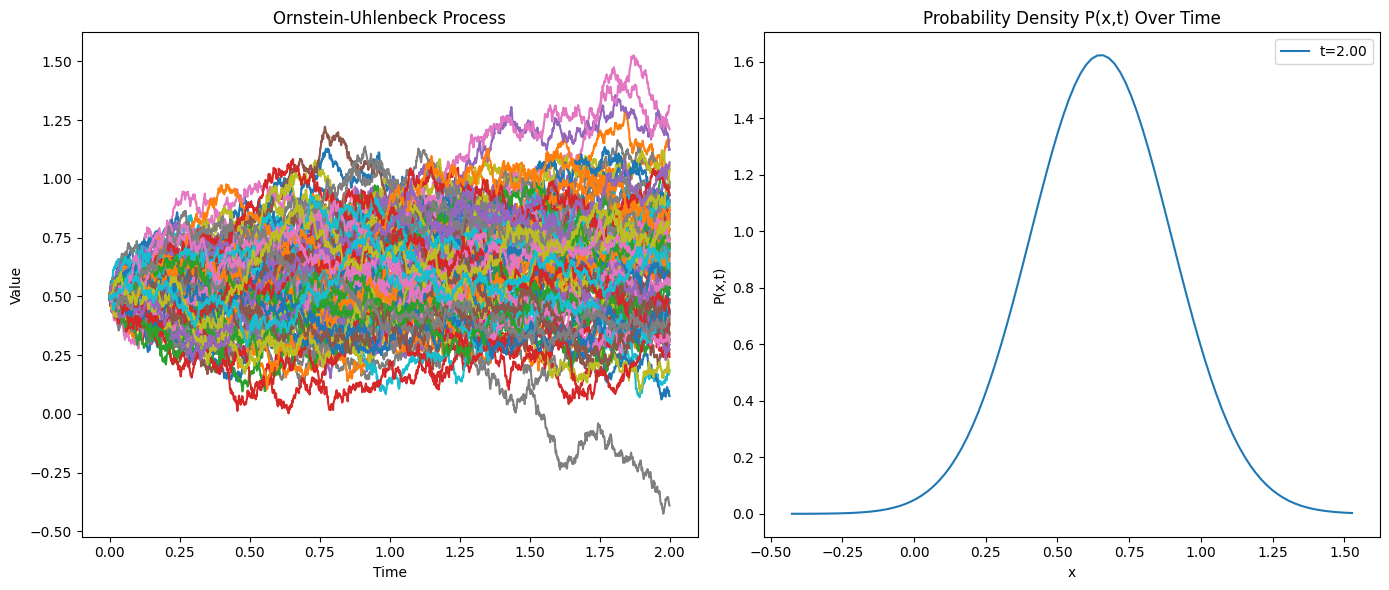

In [98]:
def generate_ou_process_data(theta, mu, sigma, X0, T, dt, num_paths):
    """
    Generate time series data from an Ornstein-Uhlenbeck process and calculate the corresponding P(x,t).

    Parameters:
    - theta (float): Rate of mean reversion (θ).
    - mu (float): Long-term mean (μ).
    - sigma (float): Volatility (σ).
    - X0 (float): Initial value (X₀).
    - T (float): Total time (T).
    - dt (float): Time step (Δt).
    - num_paths (int): Number of paths to generate.

    Returns:
    - t (np.ndarray): Array of time points.
    - X (np.ndarray): Array of generated paths, shape (num_paths, len(t)).
    - P_xt (np.ndarray): Array of P(x,t) values, shape (len(x_grid), len(t)).
    - x_grid (np.ndarray): The grid of x values used to calculate P(x,t).
    """
    # Calculate the number of time steps
    num_steps = int(T / dt)
    
    # Create an array of time points from 0 to T
    t = np.linspace(0, T, num_steps)
    
    # Initialize arrays to store the paths
    X = np.zeros((num_paths, num_steps))
    
    # Set the initial value for all paths
    X[:, 0] = X0

    for i in range(1, num_steps):
        # Generate random increments (Wiener process) for the Brownian motion term
        dW = np.sqrt(dt) * np.random.randn(num_paths)
        
        # Update the process using the Euler-Maruyama method
        X[:, i] = X[:, i-1] + theta * (mu - X[:, i-1]) * dt + sigma * dW
    
    # Calculate the P(x,t) for a range of x values using the known mean and variance
    x_grid = np.linspace(np.min(X), np.max(X), 100)
    P_xt = np.zeros((len(x_grid), num_steps))
    
    for i in range(1, num_steps):  # Start from 1 to avoid t=0
        # Calculate the known theoretical mean and variance at time t[i]
        mean = X0 * np.exp(-theta * t[i]) + mu * (1 - np.exp(-theta * t[i]))
        variance = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t[i]))
        
        # Avoid division by zero by checking variance
        if variance > 1e-10:
            P_xt[:, i] = (1.0 / np.sqrt(2 * np.pi * variance)) * np.exp(-0.5 * ((x_grid - mean)**2) / variance)
        else:
            P_xt[:, i] = 0  # Set P(x,t) to 0 where variance is too small to avoid numerical issues
    
    # Return time points, generated paths, and corresponding P(x,t) values
    return t, X, P_xt, x_grid

# Example usage
theta = 0.7
mu = 0.7
sigma = 0.3
X0 = 0.5
T = 2.0
dt = 0.001
num_paths = 100

t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, X0, T, dt, num_paths)

# Display the plot of the generated data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, X.T)  # Plot paths with transparency for better visibility
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Ornstein-Uhlenbeck Process')


# Plot P(x,t) at specific time points
plt.subplot(1, 2, 2)
#time_indices = [int(T / dt * 0.25) - 1, int(T / dt * 0.5) - 1, int(T / dt * 0.75) - 1, int(T / dt) - 1, int(T / dt * 0.05) - 1, int(T / dt * 0.10) - 1, int(T / dt * 0.15) - 1]
time_indices = [int(T / dt * 1) - 1]

for i in time_indices:
    plt.plot(x_grid, P_xt[:, i], label=f't={t[i]:.2f}')
plt.xlabel('x')
plt.ylabel('P(x,t)')
plt.title('Probability Density P(x,t) Over Time')
plt.legend()

plt.tight_layout()
plt.show()






## estimation using KDE

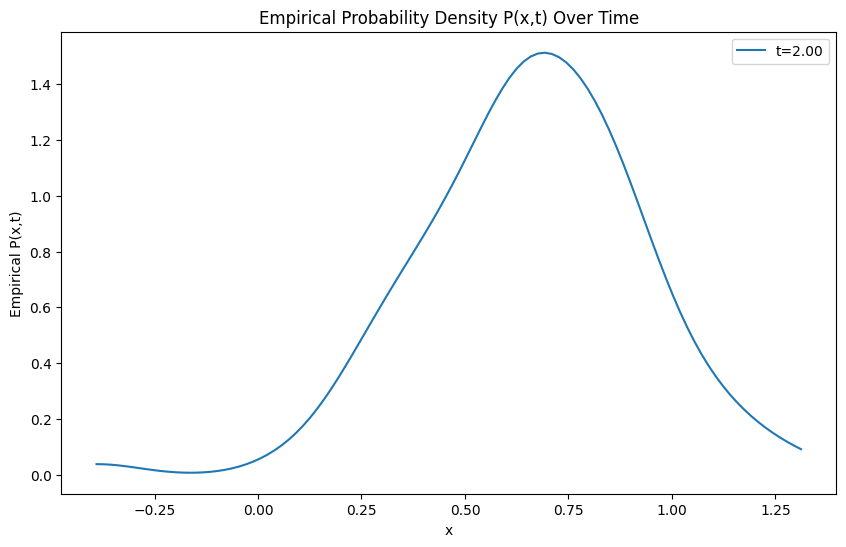

In [99]:

def plot_empirical_pdf(X, t, time_points):
    plt.figure(figsize=(10, 6))
    for time_point in time_points:
        time_index = min(int(time_point / t[-1] * len(t)), len(t) - 1)
        data_at_t = X[:, time_index]
        
        # Use KDE to estimate the empirical PDF
        kde = gaussian_kde(data_at_t)
        x_grid = np.linspace(np.min(data_at_t), np.max(data_at_t), 100)
        plt.plot(x_grid, kde(x_grid), label=f't={time_point:.2f}')
    
    plt.xlabel('x')
    plt.ylabel('Empirical P(x,t)')
    plt.title('Empirical Probability Density P(x,t) Over Time')
    plt.legend()
    plt.show()

# Example usage
#time_points = [0.5, 1.0, 1.5, 2.0]  # Time points to plot
time_points = [2]  # Time points to plot
plot_empirical_pdf(X, t, time_points)


## DATA GENERATION


In [4]:
def generate_ou_process_data(theta, mu, sigma,  T, dt, num_paths, X0=0.5):
    num_steps = int(T / dt)
    t = np.linspace(0, T, num_steps)
    X = np.zeros((num_paths, num_steps))
    X[:, 0] = X0

    for i in range(1, num_steps):
        dW = np.sqrt(dt) * np.random.randn(num_paths)
        X[:, i] = X[:, i-1] + theta * (mu - X[:, i-1]) * dt + sigma * dW
    
    # Generate x_grid based on a wide enough range of X values to reflect variability
    x_min, x_max = np.min(X), np.max(X)
    x_grid = np.linspace(x_min, x_max, 100)
    
    # Calculate P(x,t) over the x_grid
    P_xt = np.zeros((len(x_grid), num_steps))
    for i in range(num_steps):
        mean = mu * (1 - np.exp(-theta * t[i])) + X0 * np.exp(-theta * t[i])
        variance = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t[i]))
        
        if variance > 1e-10:
            P_xt[:, i] = (1.0 / np.sqrt(2 * np.pi * variance)) * \
                         np.exp(-0.5 * ((x_grid - mean)**2) / variance)
        else:
            P_xt[:, i] = np.zeros_like(x_grid)
    
    # Stack x_grid and t for inputs and flatten P_xt for targets
    inputs = np.stack(np.meshgrid(x_grid, t), axis=-1).reshape(-1, 2)
    targets = P_xt.T.flatten()  # Transpose to match the shape of inputs

    return inputs, targets, t, X, P_xt, x_grid 

def generate_random_parameters_univariate():
    """Generates random combinations of mu, theta, and sigma for a univariate OU process."""
    mu = np.random.uniform(0, 1)  # Random value for mu in range [-1, 1]
    theta = np.random.uniform(0.1, 2.0)  # Random scalar for theta, positive for stability
    sigma = np.random.uniform(0.1, 1.0)  # Random scalar for sigma, representing volatility
    return mu, theta, sigma



def generate_training_data_with_random_params(num_datasets, num_paths, T, dt, seed=None):

    if seed is None:
        seed = 42
    np.random.seed(seed)
    
    all_inputs = []
    all_targets = []
    all_mus = []
    all_sigmas = []
    all_thetas = []

    for dataset_index in range(num_datasets):
        mu = np.random.uniform(0.5, 1.5)
        sigma = np.random.uniform(0.2, 0.5)
        theta = np.random.uniform(0.5, 1.0)
        X0 = 0  # Initial value
        
        inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
        
        all_inputs.append(inputs)
        all_targets.append(targets)
        all_mus.append(np.full(inputs.shape[0], mu))
        all_sigmas.append(np.full(inputs.shape[0], sigma))
        all_thetas.append(np.full(inputs.shape[0], theta))

        if dataset_index < 3:
            plot_all_paths_and_P_xt(t, X, P_xt, x_grid, dataset_index, mu, sigma, theta)
    
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_mus = np.concatenate(all_mus, axis=0)
    all_sigmas = np.concatenate(all_sigmas, axis=0)
    all_thetas = np.concatenate(all_thetas, axis=0)
    
    return all_inputs, all_targets, all_mus, all_sigmas, all_thetas


def plot_all_paths_and_P_xt(t, X, P_xt, x_grid, dataset_index, mu, sigma, theta):
    plt.figure(figsize=(14, 6))
    
    # Plot the first 3 paths
    plt.subplot(1, 2, 1)
    for i in range(X.shape[0]):
        plt.plot(t, X[i], alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Dataset {dataset_index + 1}: First 3 Paths (μ={mu:.2f}, σ={sigma:.2f}, θ={theta:.2f})')
    plt.grid(True)
    
    # Plot P(x,t) for the last time step
    plt.subplot(1, 2, 2)
    P_xt_last_time = P_xt[:, -1]  # Select the last time step
    plt.plot(x_grid, P_xt_last_time, label=f'P(x,t) at t={t[-1]:.2f}')
    plt.xlabel('x')
    plt.ylabel('P(x,t)')
    plt.title(f'Dataset {dataset_index + 1}: P(x,t) (μ={mu:.2f}, σ={sigma:.2f}, θ={theta:.2f})')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



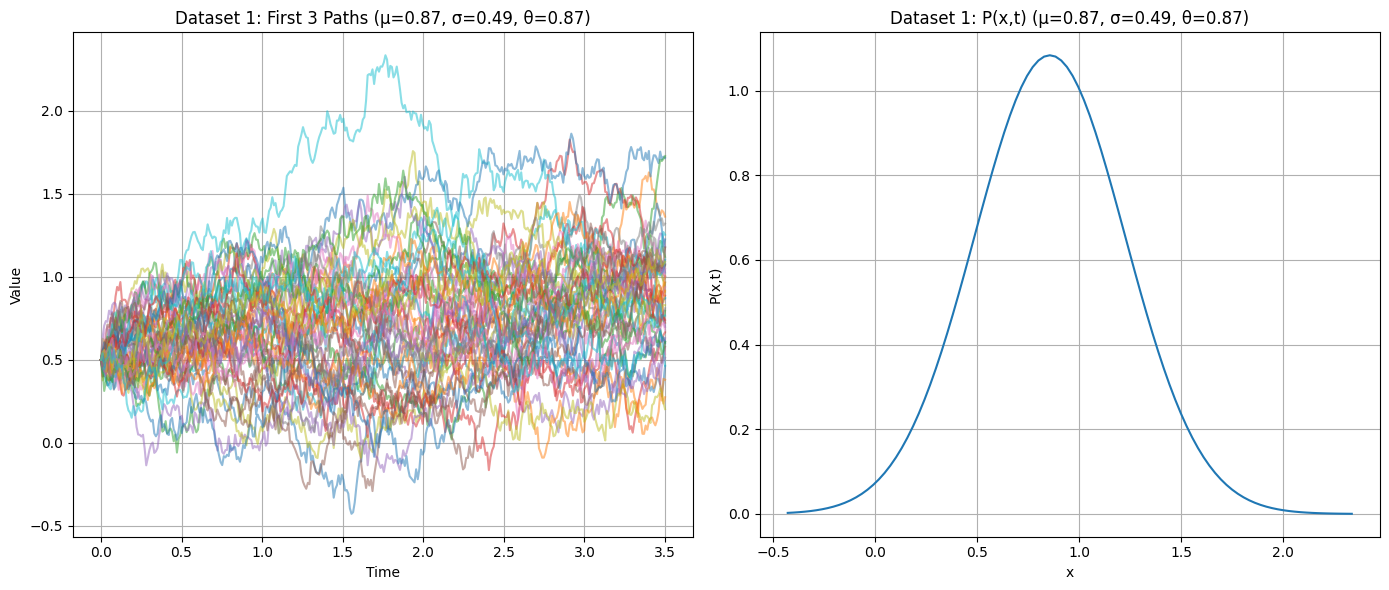

In [101]:

# Example usage
num_datasets = 1  # Number of different mean/variance combinations
num_paths = 50  # Number of paths per combination
T = 3.5           # Total time
dt = 0.01         # Time step

input, target, mus, sigmas, thetas = generate_training_data_with_random_params(num_datasets, num_paths, T, dt)



In [102]:

# prin the shape of the input and target
print(f'inputs: {input.shape}')
print(f'target: {target.shape}')


inputs: (35000, 2)
target: (35000,)


## **Section 2**: Loss Function Definition

In [5]:
def spatial_derivatives(fn, x):
    """
    Compute first and second order spatial derivatives of the function.

    Parameters:
    - fn: The function whose derivatives are to be computed.
    - x: Input data points.

    Returns:
    - dx1: First order derivatives with respect to x.
    - d2x1: Second order derivatives with respect to x.
    """
    f = lambda x: fn(x).sum()
    f_dK = lambda x: grad(f)(x).sum()
    dx = vmap(grad(f), 0)(x)
    #print(f"Computed first-order derivatives, dx shape: {dx.shape}")
    d2x = vmap(grad(f_dK), 0)(x)
    #print(f"Computed second-order derivatives, d2x shape: {d2x.shape}")
    dx1 = dx[:, 0]
    d2x1 = d2x[:, 0]
    #print(f"spatial_derivatives: dx1 shape: {dx1.shape}, d2x1 shape: {d2x1.shape}")
    return dx1, d2x1

def time_derivative(fn, t, x):
    """
    Compute the first order time derivative of the function.

    Parameters:
    - fn: The function whose derivatives are to be computed.
    - t: Time points.
    - x: Input data points.

    Returns:
    - dt: First order derivatives with respect to time.
    """
    t_expanded = jnp.expand_dims(t, axis=-1) if t.ndim == 1 else t
    x_expanded = x if x.ndim == 2 else jnp.expand_dims(x, axis=-1)
    combined = jnp.concatenate([t_expanded, x_expanded], axis=-1)
    f = lambda t: fn(combined).sum()
    dt = vmap(grad(f), 0)(t)
    #print(f"time_derivative: dt shape: {dt.shape}")
    return dt[:, 0]



# Loss functions
l_acc = lambda x, y, degree=2: (x.flatten() - y.ravel())**degree

def l_pde_fp(dt, dx, d2x, p, x, mu_values, sigma_values, theta_values, degree=2):
    """
    Compute the PDE residual loss for the Fokker-Planck equation.

    Parameters:
    - dt: First order derivatives with respect to time.
    - dx: First order derivatives with respect to space (x).
    - d2x: Second order derivatives with respect to space (x).
    - p: Probability density function values.
    - theta: Drift coefficient.
    - sigma: Diffusion coefficient.
    - x: Input data points.
    - mu: Long-term mean.
    - degree: Degree of the loss (default is 2).

    Returns:
    - Residual loss for the Fokker-Planck equation.
    """
    drift_term = theta_values * (mu_values - x[:, 0]) * dx - theta_values * p
    diffusion_term = 0.5 * sigma_values**2 * d2x
    residual = dt + drift_term - diffusion_term
    return jnp.abs(residual**degree)



# Error functions
def errors_fp(fn, x_train, y_train, x_mesh, x_val, y_val, theta_values, sigma_values, mu_values):
    """
    Compute the error metrics for the Fokker-Planck equation.

    Parameters:
    - fn: The function representing the model.
    - data: Training and validation data.
    - theta: Drift coefficient.
    - sigma: Diffusion coefficient.
    - mu: Long-term mean.

    Returns:
    - Dictionary of error metrics.
    """

    # Extract time and space dimensions
    x = x_mesh[:, 0:1]
    t = x_mesh[:, 1:]

    print(f"Calling spatial_derivatives with x shape: {x.shape}")
    dx, d2x = spatial_derivatives(fn, x_mesh)
    print(f"Calling time_derivative with t shape: {t.shape} and x shape: {x.shape}")
    dt = time_derivative(fn, t, x)

    #print(f"errors_fp: dx shape: {dx.shape}, d2x shape: {d2x.shape}, dt shape: {dt.shape}")

    e_acc = l_acc(fn(x_train).reshape(-1), y_train)
    #print(f"Calling l_pde_fp")
    e_pde = l_pde_fp(dt, dx, d2x, fn(x_mesh), x_mesh, mu_values, sigma_values, theta_values)

    #print(f"errors_fp: e_acc shape: {e_acc.shape}, e_pde shape: {e_pde.shape}")

    val_acc = l_acc(fn(x_val).reshape(-1), y_val)
    #print(f"errors_fp: val_acc shape: {val_acc.shape}")

    return {
        'e_acc': jnp.mean(e_acc).sum(),
        'e_pde': jnp.mean(e_pde).sum(),
        'val_acc': jnp.mean(val_acc).sum()
    }





# Loss functions
def loss_MLP(fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu, efunc):
    """
    Compute the MLP loss.

    Parameters:
    - fn: The function representing the model.
    - data: Training and validation data.
    - theta: Drift coefficient.
    - sigma: Diffusion coefficient.
    - mu: Long-term mean.
    - efunc: Error function to compute error metrics.

    Returns:
    - loss: Computed loss.
    - err: Dictionary of error metrics.
    """
    err = efunc(fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu)
    loss = err['e_acc']
    return loss, err


def loss_pinn(fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu, efunc, alpha, beta):
    """
    Compute the PINN loss.

    Parameters:
    - fn: The function representing the model.
    - data: Training and validation data.
    - theta: Drift coefficient.
    - sigma: Diffusion coefficient.
    - mu: Long-term mean.
    - efunc: Error function to compute error metrics.
    - alpha: Weight for accuracy error.
    - beta: Weight for PDE residual error.

    Returns:
    - loss: Computed loss.
    - err: Dictionary of error metrics.
    """
    err = efunc(fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu)
    loss = alpha * err['e_acc'] + beta * err['e_pde']

    return loss, err


# Dictionary to map loss functions
loss_fn = {
    "MLP": lambda fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu, efunc: loss_MLP(fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu, efunc),
    "PINN": lambda fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu, efunc, alpha, beta: loss_pinn(fn, x_train, y_train, x_mesh, x_val, y_val, theta, sigma, mu, efunc, alpha, beta)
}

# Error function for the Fokker-Planck equation
error_fn = {"FP_OU": errors_fp}


## **Section 3**: Neural Network Model Architecture

In [6]:
# Define the Config class to hold configuration parameters
# Define the Config class to hold configuration parameters
class Config:
    def __init__(self, seed, ann_in_dim, hidden_layers, loss_str, data_source, num_epochs, log_interval, alpha=None, beta=None, patience=10, min_delta=0.001,
                 learning_rate=1e-4, weight_decay=1e-2, beta1=0.9, beta2=0.999, eps=1e-8, decay_rate=0.9, decay_steps=2000, batch_size=64):
        """
        Configuration for the model and training process.

        Parameters:
        - seed: Random seed for initialization.
        - ann_in_dim: Input dimension for the ANN model.
        - hidden_layers: List of integers representing the number of units in each hidden layer.
        - loss_str: String identifier for the loss function.
        - data_source: Identifier for the data source.
        - num_epochs: Number of epochs for training.
        - log_interval: Interval for logging training progress.
        - alpha: Weight for data fitting loss.
        - beta: Weight for PDE loss.
        - patience: Number of epochs to wait for improvement before stopping.
        - min_delta: Minimum change in validation loss to qualify as an improvement.
        - learning_rate: Learning rate for the optimizer.
        - weight_decay: L2 regularization term.
        - beta1: First moment decay rate for the Adam optimizer.
        - beta2: Second moment decay rate for the Adam optimizer.
        - eps: Epsilon value to prevent division by zero in the optimizer.
        - decay_rate: Rate at which the learning rate decays.
        - decay_steps: Number of steps before applying decay to the learning rate.
        """
        self.seed = seed
        self.ann_in_dim = ann_in_dim
        self.hidden_layers = hidden_layers
        self.loss_str = loss_str
        self.data_source = data_source
        self.num_epochs = num_epochs
        self.log_interval = log_interval
        self.alpha = alpha
        self.beta = beta
        self.patience = patience
        self.min_delta = min_delta
        
        # Optimizer parameters
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        
        # batch size
        self.batch_size = batch_size



# Define the ANN class with a flexible architecture
class ANN(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, x):
        """
        Forward pass through the ANN.

        Parameters:
        - x: Input tensor.

        Returns:
        - Output tensor with non-negative values.
        """
        for feature in self.hidden_layers:
            x = nn.Dense(feature)(x)
            x = nn.tanh(x)
        x = nn.Dense(1)(x)
        x = nn.softplus(x)  # Ensuring the output is non-negative
        return x

# Function to generate the ANN model and optimizer based on the config
def ann_gen(config):
    """
    Generate an ANN model and optimizer based on the configuration.

    Parameters:
    - config: Configuration object.

    Returns:
    - model: ANN model instance.
    - tx: Optimizer instance.
    """
    # Initialize the model
    model = ANN(hidden_layers=config.hidden_layers)
    
    # Learning rate schedule
    lr_schedule = optax.exponential_decay(
        init_value=config.learning_rate,
        transition_steps=config.decay_steps,
        decay_rate=config.decay_rate,
    )
    
    # Optimizer setup
    tx = optax.chain(
        optax.add_decayed_weights(config.weight_decay),  # L2 regularization
        optax.adam(
            learning_rate=lr_schedule, b1=config.beta1, b2=config.beta2, eps=config.eps
        )
    )
    
    return model, tx




# Function to initialize the model
def initialize_model(rng_key, input_dim, hidden_layers):
    """
    Initialize the ANN model.

    Parameters:
    - rng_key: Random key for initialization.
    - input_dim: Dimension of the input.
    - hidden_layers: List of integers representing the number of units in each hidden layer.

    Returns:
    - model: Initialized ANN model instance.
    - params: Initialized parameters of the model.
    """
    model = ANN(hidden_layers=hidden_layers)
    dummy_input = jnp.ones((1, input_dim))  # Ensure input_dim is set correctly
    #print(f"Initializing model with dummy input shape: {dummy_input.shape}")
    params = model.init(rng_key, dummy_input)['params']
    #print(f"Initialized params shape: {jax.tree_map(lambda x: x.shape, params)}")
    return model, params



# Utility functions for saving and loading model parameters
def to_state_dict(params):
    """
    Convert model parameters to a state dictionary.

    Parameters:
    - params: Model parameters.

    Returns:
    - State dictionary of model parameters.
    """
    return params

def from_state_dict(state_dict, params):
    """
    Load model parameters from a state dictionary.

    Parameters:
    - state_dict: State dictionary of model parameters.
    - params: Initialized model parameters.

    Returns:
    - Model parameters loaded from the state dictionary.
    """
    return state_dict

def save_params(params, path_item: str):
    """
    Save model parameters to a file.

    Parameters:
    - params: Model parameters to be saved.
    - path_item: File path where parameters should be saved.
    """
    with open(path_item, 'wb') as f:
        pickle.dump(to_state_dict(params), f)

def load_params(params_initialized, path_item: str):
    """
    Load model parameters from a file.

    Parameters:
    - params_initialized: Initialized model parameters.
    - path_item: File path from where parameters should be loaded.

    Returns:
    - Loaded model parameters.
    """
    with open(path_item, 'rb') as f:
        loaded_dict = pickle.load(f)
    return from_state_dict(loaded_dict, params_initialized)

def load_trained_params(path_item):
    """
    Load the trained model parameters from a file.

    Parameters:
    - path_item: File path from where parameters should be loaded.

    Returns:
    - Loaded model parameters.
    """
    with open(path_item, 'rb') as f:
        params = pickle.load(f)
    return params

def build_model(config):
    """
    Build the ANN model based on the configuration provided.

    Parameters:
    - config: Configuration object containing model parameters.

    Returns:
    - model: Initialized ANN model instance.
    """
    # Initialize the model with the hidden layers specified in the config
    model = ANN(hidden_layers=config.hidden_layers)
    return model

# Function to load the trained model parameters
def load_trained_model(weights_file, config):
    """
    Loads the trained model using the saved weights and hyperparameters.
    
    Parameters:
    - weights_file: Path to the file where model weights are stored.
    - config: Configuration object containing model parameters.
    
    Returns:
    - model: ANN model instance.
    - params: Loaded model parameters.
    """
    # Build the model architecture from config
    model = build_model(config)
    
    # Initialize model parameters
    rng_key = jax.random.PRNGKey(config.seed)  # Use config.seed to generate a reproducible key
    _, params_initialized = initialize_model(rng_key, config.ann_in_dim, config.hidden_layers)
    
    # Load the trained model parameters from file
    params_trained = load_params(params_initialized, weights_file)  # Loading the actual trained parameters
    
    return model, params_trained  # Return the model and the loaded parameters


## **Section 4**: Neural Network Calibration and Training Functions

In [7]:
# Calibration function to set up the training step
def calibration(config):
    """
    Set up the training step for model calibration.
    """
    ann, tx = ann_gen(config)

    ofunc = loss_fn[config.loss_str]
    efunc = error_fn[config.data_source]

    @jjit
    def train_step(state, batch_x, batch_y, x_mesh, x_val, y_val, batch_theta_values, batch_sigma_values, batch_mu_values):
        
        def loss_fn(params):
            def fn(x):
                result = ann.apply({'params': params}, x)
                return result

            if config.loss_str == "PINN":
                loss, metrics = ofunc(fn, batch_x, batch_y, x_mesh, x_val, y_val, batch_theta_values, batch_sigma_values, batch_mu_values, efunc, config.alpha, config.beta)
                return loss, metrics
            else:
                loss, metrics = ofunc(fn, batch_x, batch_y, x_mesh, x_val, y_val, batch_theta_values, batch_sigma_values, batch_mu_values, efunc)
                return loss, metrics

        params = state.params
        (loss, metric), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        state = state.apply_gradients(grads=grads)
        return state, loss, metric

    return train_step




# Batch Generator Function
def batch_generator(x_data, y_data, x_mesh, mu_values, theta_values, sigma_values, batch_size):
    """
    Generator function to yield batches of data including mu, theta, and sigma.

    Parameters:
    - x_data: The input features dataset.
    - y_data: The target values dataset.
    - mu_values: Long-term mean values.
    - theta_values: Drift coefficient values.
    - sigma_values: Diffusion coefficient values.
    - batch_size: The size of each batch.

    Yields:
    - A batch of data including x, y, mu, theta, and sigma.
    """
    for i in range(0, len(x_data), batch_size):
        yield (x_data[i:i + batch_size],
               y_data[i:i + batch_size],
               x_mesh[i:i + batch_size],
               mu_values[i:i + batch_size],
               theta_values[i:i + batch_size],
               sigma_values[i:i + batch_size])


def train_model(config, data, theta_values, sigma_values, mu_values, batch_size=32):
    """
    Train the model using the provided data and configuration with batching.

    Parameters:
    - config: Configuration for the model and training.
    - data: Training data as a tuple (x_train, y_train, x_mesh, x_val, y_val).
    - theta_values: Drift coefficient.
    - sigma_values: Diffusion coefficient.
    - mu_values: Long-term mean.
    - batch_size: The size of each batch.

    Returns:
    - fn: Trained model function.
    - metrics: Dictionary of training metrics.
    """
    # Unpack the data
    x_train, y_train, x_mesh, x_val, y_val = data
    
    # Generate the ANN model and optimizer
    ann, tx = ann_gen(config)
    
    # Initialize the train step function
    train_step = calibration(config)

    # Initialize the model's parameters
    key = jax.random.PRNGKey(config.seed)
    key, key_init = jax.random.split(key, 2)
    dummy = jnp.ones((1, config.ann_in_dim))
    
    state = train_state.TrainState.create(
        apply_fn=ann.apply,
        params=ann.init(key_init, dummy)['params'], 
        tx=tx
    )

    metrics = {
        'loss': [], 'e_acc': [], 'e_pde': [], 'val_acc': []
    }

    best_val_loss = float('inf')
    best_params = None
    patience_counter = 0

    print("------ Calibration {} start ------".format(config.loss_str))
    start_time = time.time()

    for epoch in range(config.num_epochs):
        print(f"Epoch {epoch} start")
        '''
        # Get GPU temperature, memory usage, and utilization
        gpu_temp, gpu_mem_used, gpu_mem_total, gpu_utilization = get_gpu_info()
        if gpu_temp is not None and gpu_mem_used is not None and gpu_utilization is not None:
            print(f"GPU temperature: {gpu_temp}°C, GPU memory usage: {gpu_mem_used}MB/{gpu_mem_total}MB, GPU utilization: {gpu_utilization}%")
        
        # Get CPU memory usage
        cpu_mem_used, cpu_mem_total = get_cpu_memory_usage()
        if cpu_mem_used is not None:
            print(f"CPU memory usage: {cpu_mem_used:.2f}GB/{cpu_mem_total:.2f}GB")
        
        # Check for overheating or excessive memory usage
        if gpu_temp > 85:
            print(f"Warning: GPU temperature exceeded 85°C. Stopping training.")
            break
        if gpu_mem_used > 0.95 * gpu_mem_total:
            print(f"Warning: GPU memory usage exceeded 95%. Stopping training.")
            break
        if gpu_utilization > 95:
            print(f"Warning: GPU utilization exceeded 95%.")
        if cpu_mem_used > 0.95 * cpu_mem_total:
            print(f"Warning: CPU memory usage exceeded 95%. Stopping training.")
            break
        '''
        
        
        batch_gen = batch_generator(x_train, y_train, x_mesh, mu_values, theta_values, sigma_values, batch_size)
        
        epoch_loss = 0
        epoch_metrics = {k: 0 for k in ['e_acc', 'e_pde', 'val_acc']}  # Initialize epoch metrics
        num_batches = 0
        
        for batch_x, batch_y, batch_x_mesh, batch_mu_values, batch_theta_values, batch_sigma_values in batch_gen:
            state, loss, metric = train_step(state, batch_x, batch_y, batch_x_mesh, x_val, y_val, batch_theta_values, batch_sigma_values, batch_mu_values)
            epoch_loss += loss
            for k, v in metric.items():
                epoch_metrics[k] += v
            num_batches += 1

        # Average the loss and metrics over the number of batches
        epoch_loss /= num_batches
        for k in epoch_metrics:
            epoch_metrics[k] /= num_batches

        # Append metrics after each epoch
        metrics['loss'].append(epoch_loss)
        metrics['e_acc'].append(epoch_metrics['e_acc'])
        metrics['e_pde'].append(epoch_metrics['e_pde'])
        metrics['val_acc'].append(epoch_metrics['val_acc'])

        print(f"Epoch {epoch} end: Loss = {epoch_loss}, Metric = {epoch_metrics}")

        if epoch % config.log_interval == 0:
            print(f"Epoch {epoch}: Loss = {epoch_loss}, Val Acc = {epoch_metrics['val_acc']}")

        val_loss = epoch_metrics['val_acc']
        print(f"Epoch {epoch}: Best Val Loss = {best_val_loss}, Current Val Loss = {val_loss}, Delta = {(best_val_loss - val_loss)}")

        if val_loss < best_val_loss - config.min_delta:
            best_val_loss = val_loss
            best_params = state.params
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= config.patience:
            print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss}")
            state = state.replace(params=best_params)
            break

    comp_time = time.time() - start_time
    print("----- Calibration {} epoch {} in {:0.2f} sec ------".format(config.loss_str, epoch, comp_time))

    return state.params, metrics

## **Section 6**: Plots

In [8]:
def plot_training_history(metrics, config):
    """
    Plot the training history for the given metrics in log scale.

    Parameters:
    - metrics: Dictionary of training metrics.
    - config: Configuration object containing the number of epochs and loss type.
    """
    epochs = range(len(metrics['loss']))  # Adjust epochs to match actual number of training epochs
    fig, axs = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 3))
    fig.suptitle(f'Training History for {config.loss_str}')
    axs = [axs] if len(metrics) == 1 else axs
    for i, (metric_name, values) in enumerate(metrics.items()):
        axs[i].plot(epochs, values, label=metric_name)
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric_name)
        axs[i].set_yscale('log')  # Set y-axis to log scale
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()


def plot_model_predictions(fn, x_test, t_test, true_P, config):
    """
    Plot the model's predictions for P(x,t) and compare them with the true values.

    Parameters:
    - fn: Trained model function.
    - x_test: Test input data (space).
    - t_test: Test input data (time).
    - true_P: True values of P(x,t) for comparison.
    - config: Configuration object containing the loss type.
    """
    # Create a meshgrid for x and t
    xs, ts = jnp.meshgrid(x_test, t_test)
    x_vec = jnp.array([xs.flatten(), ts.flatten()]).T
    
    # Predict P(x,t) using the trained model
    pred_P = fn(x_vec).reshape(xs.shape)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot true P(x,t)
    pcm = axs[0].pcolormesh(xs, ts, true_P, cmap='viridis', shading='auto')
    axs[0].set_title('True P(x,t)')
    fig.colorbar(pcm, ax=axs[0])
    
    # Plot predicted P(x,t)
    pcm = axs[1].pcolormesh(xs, ts, pred_P, cmap='viridis', shading='auto')
    axs[1].set_title(f'Predicted P(x,t) - {config.loss_str}')
    fig.colorbar(pcm, ax=axs[1])
    
    plt.tight_layout()
    plt.show()


def plot_parameter_estimates(true_theta, true_sigma, estimated_theta, estimated_sigma):
    """
    Plot the estimated drift and diffusion parameters compared to their true values.

    Parameters:
    - true_theta: True drift parameter.
    - true_sigma: True diffusion parameter.
    - estimated_theta: Estimated drift parameter.
    - estimated_sigma: Estimated diffusion parameter.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot theta
    axs[0].bar(['True Theta', 'Estimated Theta'], [true_theta, estimated_theta], color=['blue', 'orange'])
    axs[0].set_title('Drift Parameter (Theta)')
    
    # Plot sigma
    axs[1].bar(['True Sigma', 'Estimated Sigma'], [true_sigma, estimated_sigma], color=['blue', 'orange'])
    axs[1].set_title('Diffusion Parameter (Sigma)')
    
    plt.tight_layout()
    plt.show()
    
    
def plot_predictions(fn, x_grid, P_xt, t, config, mu, sigma, theta, model_name):
    """
    Plot the model's predictions vs actual P(x,t) at the last time step.

    Parameters:
    - fn: Trained model function.
    - x_grid: Grid of x values.
    - P_xt: True P(x,t) values for the entire time grid.
    - t: Array of time values.
    - config: Configuration object containing the loss type.
    - dataset_index: Index of the dataset (for labeling purposes).
    - mu, sigma, theta: Parameters used to generate the dataset.
    """
    plt.figure(figsize=(14, 6))
    
    # Select the last time step
    last_time = t[-1]
    P_xt_last_time = P_xt[:, -1]  # True P(x,t) at the last time step
    
    # Create input for the model using x_grid and the last time step
    x_vec = jnp.column_stack((x_grid, jnp.full_like(x_grid, last_time)))

    # Predict P(x,t) using the trained model at the last time step
    pred_P = fn(x_vec).reshape(-1)  # Reshape to make it 1D for plotting

    # Plot true P(x,t)
    plt.plot(x_grid, P_xt_last_time, label=f"True P(x,t) at t={last_time:.2f}")
    
    # Plot predicted P(x,t)
    plt.plot(x_grid, pred_P, '--', label=f"Predicted P(x,t) at t={last_time:.2f} ({config.loss_str})")
    
    plt.xlabel('x')
    plt.ylabel('P(x,t)')
    plt.title(f'{model_name} estimation of P(x,t) Comparison at Last Time Step\n(μ={mu:.2f}, σ={sigma:.2f}, θ={theta:.2f})')
    plt.grid(True)
    plt.legend()
    plt.show()
    
def plot_predictions_normalized(fn, x_grid, P_xt, t, config, mu, sigma, theta, model_name, target_scaler, input_scaler):
    """
    Plot the model's predictions vs actual P(x,t) at the last time step.

    Parameters:
    - fn: Trained model function.
    - x_grid: Grid of x values.
    - P_xt: True P(x,t) values for the entire time grid.
    - t: Array of time values.
    - config: Configuration object containing the loss type.
    - mu, sigma, theta: Parameters used to generate the dataset.
    - target_scaler: Scaler used to normalize and inverse transform the target data.
    - input_scaler: Scaler used to normalize the input data.
    """
    plt.figure(figsize=(14, 6))
    
    # Select the last time step
    last_time = t[-1]
    P_xt_last_time = P_xt[:, -1]  # True P(x,t) at the last time step
    
    # Create input for the model using x_grid and the last time step
    x_vec = jnp.column_stack((x_grid, jnp.full_like(x_grid, last_time)))

    # Normalize the input using the same scaler as during training
    x_vec_normalized = input_scaler.transform(x_vec)

    # Predict P(x,t) using the trained model at the last time step
    pred_P = fn(x_vec_normalized)
    
    # Debugging output: check prediction shape and first few values
    print("Shape of pred_P before reshaping:", pred_P.shape)
    print("First few values of pred_P before inverse transform:", pred_P[:5])

    # Scale predictions back to original range
    pred_P = target_scaler.inverse_transform(pred_P.reshape(-1, 1)).flatten()
    
    # Debugging output: check first few values after inverse transform
    print("First few values of pred_P after inverse transform:", pred_P[:5])

    # Plot true P(x,t)
    plt.plot(x_grid, P_xt_last_time, label=f"True P(x,t) at t={last_time:.2f}")
    
    # Plot predicted P(x,t)
    plt.plot(x_grid, pred_P, '--', label=f"Predicted P(x,t) at t={last_time:.2f} ({config.loss_str})")
    
    plt.xlabel('x')
    plt.ylabel('P(x,t)')
    plt.title(f'{model_name} estimation of P(x,t) Comparison at Last Time Step\n(μ={mu:.2f}, σ={sigma:.2f}, θ={theta:.2f})')
    plt.grid(True)
    plt.legend()
    plt.show()




## **Section 7**: Evaluation and Results

data generation and dataset preparation

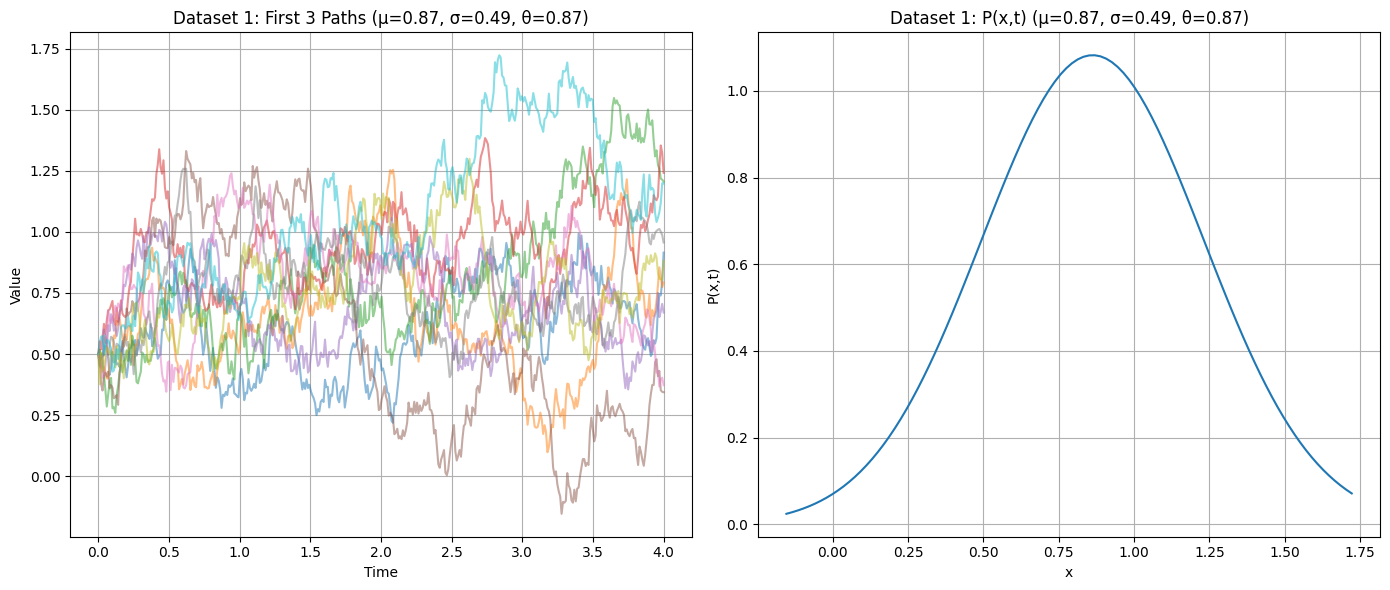

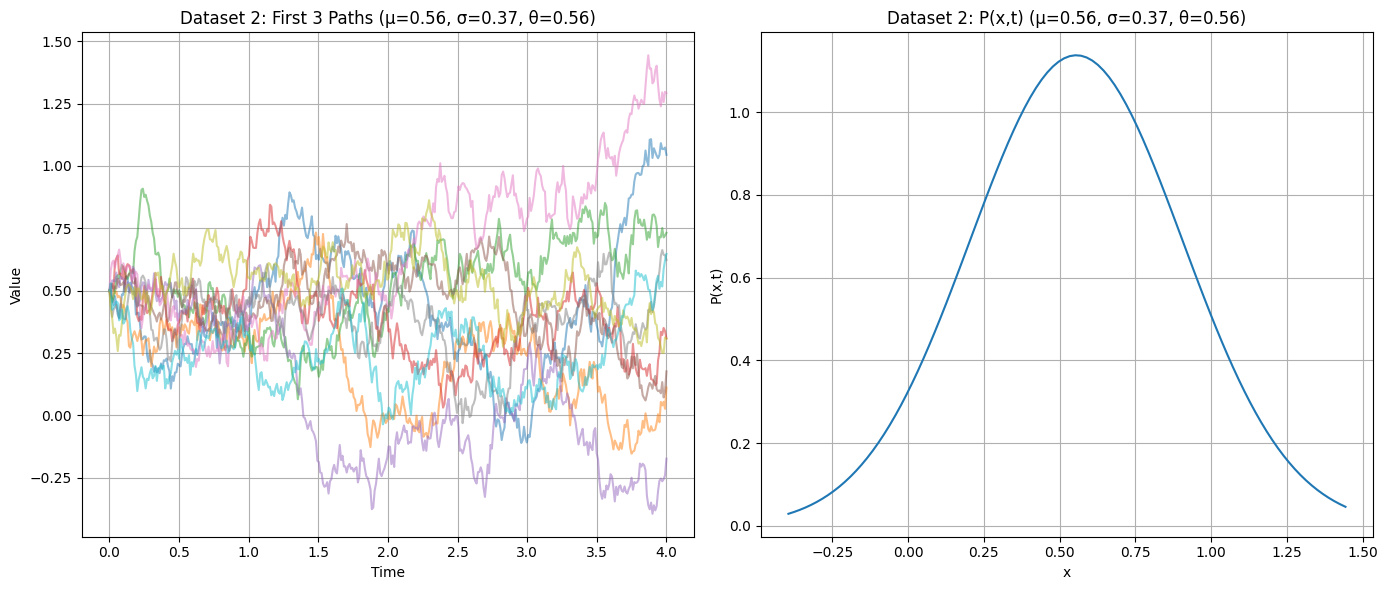

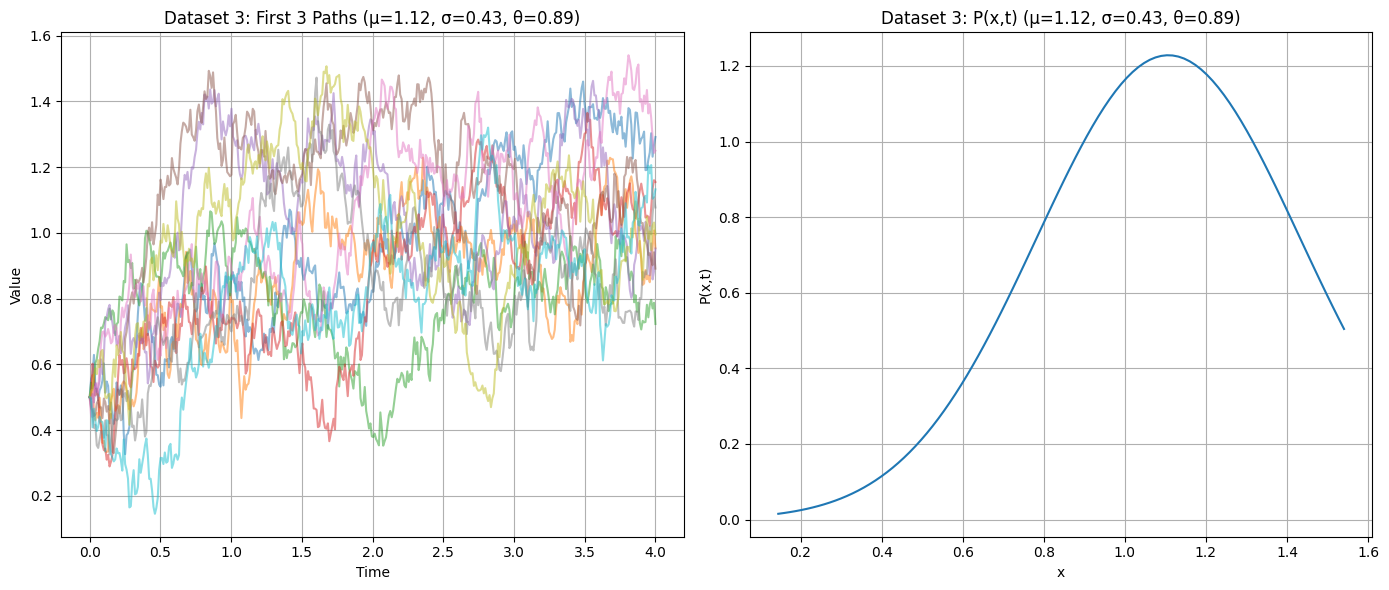

In [115]:
## DATA GENERATION FOR TRAINING THE MODEL

# Example usage
num_datasets = 35  # Number of different mean/variance combinations
num_paths = 10   # Number of paths per combination
T = 4       # Total time
dt = 0.01         # Time step

inputs, targets, mus, sigmas, thetas = generate_training_data_with_random_params(num_datasets, num_paths, T, dt)




In [116]:
# printin the shapes of the inputs and targets
print(f'input shape: {inputs.shape}')
print(f'targets shape: {targets.shape}')


input shape: (1400000, 2)
targets shape: (1400000,)


In [117]:

# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(inputs))
val_size = len(inputs) - train_size

x_train = inputs[:train_size]
y_train = targets[:train_size]
mu_train = mus[:train_size]
sigma_train = sigmas[:train_size]
theta_train = thetas[:train_size]

x_val_train = inputs[train_size:]
y_val_train = targets[train_size:]

data_train = (x_train, y_train, x_train, x_val_train, y_val_train)


'''
# Splitting the dataset and mu sigma and theta into training and validation sets randomly using sklearn 
# Combine the features and associated attributes into a single dataset
combined_inputs = np.hstack((inputs, mus.reshape(-1, 1), sigmas.reshape(-1, 1), thetas.reshape(-1, 1)))

# Perform the split
x_train, x_val, y_train, y_val = train_test_split(combined_inputs, targets, test_size=0.2, random_state=42)

# Separate the features and attributes again
inputs_train = x_train[:, :-3]
mu_train = x_train[:, -3]
sigma_train = x_train[:, -2]
theta_train = x_train[:, -1]

inputs_val = x_val[:, :-3]
mus_val = x_val[:, -3]
sigmas_val = x_val[:, -2]
thetas_val = x_val[:, -1]

data_train = (inputs_train, y_train, inputs_train, inputs_val, y_val)
'''

'\n# Splitting the dataset and mu sigma and theta into training and validation sets randomly using sklearn \n# Combine the features and associated attributes into a single dataset\ncombined_inputs = np.hstack((inputs, mus.reshape(-1, 1), sigmas.reshape(-1, 1), thetas.reshape(-1, 1)))\n\n# Perform the split\nx_train, x_val, y_train, y_val = train_test_split(combined_inputs, targets, test_size=0.2, random_state=42)\n\n# Separate the features and attributes again\ninputs_train = x_train[:, :-3]\nmu_train = x_train[:, -3]\nsigma_train = x_train[:, -2]\ntheta_train = x_train[:, -1]\n\ninputs_val = x_val[:, :-3]\nmus_val = x_val[:, -3]\nsigmas_val = x_val[:, -2]\nthetas_val = x_val[:, -1]\n\ndata_train = (inputs_train, y_train, inputs_train, inputs_val, y_val)\n'

In [ ]:
def kl_divergence(P_actual, P_pred):
    """
    Calculate the Kullback-Leibler Divergence between two probability distributions.

    Parameters:
    P_actual (np.ndarray): Actual probability distribution (shape: (n, m))
    P_pred (np.ndarray): Predicted probability distribution (shape: (n, m))

    Returns:
    float: KL divergence value
    """
    # Ensure the predicted and actual values are non-zero to avoid log(0)
    # Adding a small epsilon to prevent issues with zero values
    epsilon = 1e-10
    P_actual = np.clip(P_actual, epsilon, None)
    P_pred = np.clip(P_pred, epsilon, None)
    
    # Compute the element-wise KL divergence
    kl_values = P_actual * np.log(P_actual / P_pred)
    
    # Sum over all elements to get the total divergence
    kl_div = np.sum(kl_values)
    return kl_div


In [118]:
# print data train shapes 
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'mu_train: {mu_train.shape}')
print(f'sigma_train: {sigma_train.shape}')
print(f'theta_train: {theta_train.shape}')
print(f'x_val_train: {x_val_train.shape}')
print(f'y_val_train: {y_val_train.shape}')


x_train: (1120000, 2)
y_train: (1120000,)
mu_train: (1120000,)
sigma_train: (1120000,)
theta_train: (1120000,)
x_val_train: (280000, 2)
y_val_train: (280000,)


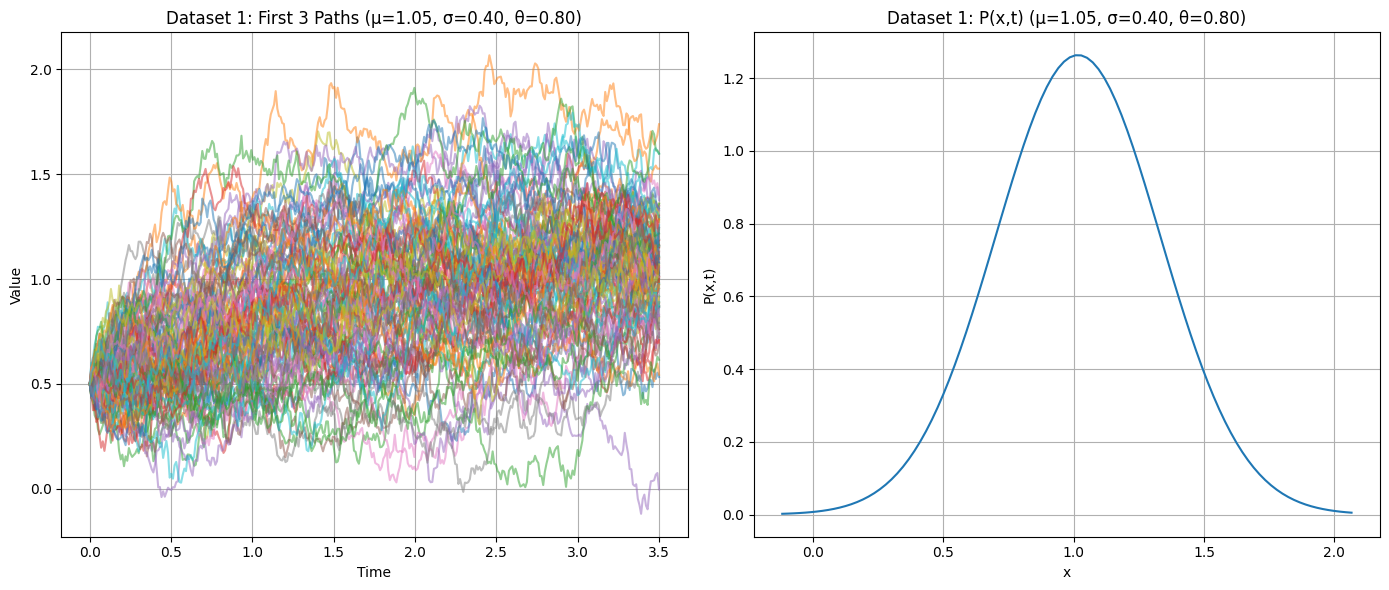

In [119]:
# Assuming `inputs_test`, `targets_test`, `t_values`, `X`, `P_xt`, and `x_grid` are generated beforehand
inputs_test, targets_test, t_values, X, P_xt, x_grid = generate_ou_process_data(
    theta=0.8, mu=1.05, sigma=0.4, X0=0.5, T=3.5, dt=0.01, num_paths=100
)


plot_all_paths_and_P_xt(t_values, X, P_xt, x_grid, 0, mu=1.05, sigma=0.4, theta=0.8)



## PINN HYPERPARAMETERS OPTIMIZATION

In [9]:
def decode_hidden_layers(encoded_layers):
    # Convert encoded string back to tuple of integers
    return tuple(map(int, encoded_layers.split("-")))

In [139]:
def objective(trial):
    hidden_layers = trial.suggest_categorical('hidden_layers', [
        "256-128-64-32",
        "128-64-32-16",
        "64-32-16-8",
        "256-128-64",
        "128-64-32",
    ])
    num_epochs = trial.suggest_int('num_epochs', 50, 150)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    beta = trial.suggest_float('beta', 0.1, 1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-1, log=True)
    patience = trial.suggest_int('patience', 10, 20)
    batch_size = trial.suggest_int('batch_size', 512, 1536)

    hidden_layers_decoded = decode_hidden_layers(hidden_layers)
    
    # print the hyperparameters
    print(f"Trial number: {trial.number}, hidden_layers: {hidden_layers_decoded}, num_epochs: {num_epochs}, alpha: {alpha}, beta: {beta}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}, batch_size: {batch_size}")

    #!nvidia-smi

    config = Config(
        seed=42,
        ann_in_dim=2,
        hidden_layers=hidden_layers_decoded,
        loss_str='PINN',
        data_source='FP_OU',
        num_epochs=num_epochs,
        log_interval=100,
        alpha=alpha,
        beta=beta,
        patience=patience,
        min_delta=1e-4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        batch_size=batch_size
    )

    params, metrics = train_model(config, data_train, theta_train, sigma_train, mu_train, batch_size)
    
    if 'val_acc' not in metrics or not metrics['val_acc']:
        # Handle the case where val_acc is missing or empty
        print("Warning: 'val_acc' is missing or empty in metrics. Metrics content: ", metrics)
        return float('inf')
    
    val_loss = metrics['val_acc'][-1]
    
    #print('val loss is correctly stored:', val_loss)
    
    return val_loss



# Create a study object and specify the direction as "minimize"
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())

# Start the optimization
study.optimize(objective, n_trials=20)

# Get the best trial and its hyperparameters
best_trial_pinn = study.best_trial

print("Best trial:")
print(f"  Value: {best_trial_pinn.value}")
print("  Params: ")
for key, value in best_trial_pinn.params.items():
    print(f"    {key}: {value}")


[I 2024-09-17 16:25:04,737] A new study created in memory with name: no-name-d094b2c9-2524-451b-85d3-e3cbd30faaf1


Trial number: 0, hidden_layers: (256, 128, 64, 32), num_epochs: 124, alpha: 0.8671969709643641, beta: 0.4854042244166782, learning_rate: 0.0009161068189482617, weight_decay: 0.0003617424669085305, patience: 20, batch_size: 759
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (759, 1)
Calling time_derivative with t shape: (759, 1) and x shape: (759, 1)
Calling spatial_derivatives with x shape: (475, 1)
Calling time_derivative with t shape: (475, 1) and x shape: (475, 1)
Epoch 0 end: Loss = 0.31068581342697144, Metric = {'e_acc': Array(0.296793, dtype=float32), 'e_pde': Array(0.10982065, dtype=float32), 'val_acc': Array(0.38654342, dtype=float32)}
Epoch 0: Loss = 0.31068581342697144, Val Acc = 0.3865434229373932
Epoch 0: Best Val Loss = inf, Current Val Loss = 0.3865434229373932, Delta = inf
Epoch 1 start
Epoch 1 end: Loss = 0.32028669118881226, Metric = {'e_acc': Array(0.30893558, dtype=float32), 'e_pde': Array(0.10790806, dtype=float32), 'val

[I 2024-09-17 16:35:37,300] Trial 0 finished with value: 0.20400796830654144 and parameters: {'hidden_layers': '256-128-64-32', 'num_epochs': 124, 'alpha': 0.8671969709643641, 'beta': 0.4854042244166782, 'learning_rate': 0.0009161068189482617, 'weight_decay': 0.0003617424669085305, 'patience': 20, 'batch_size': 759}. Best is trial 0 with value: 0.20400796830654144.


Epoch 121 end: Loss = 0.2894250750541687, Metric = {'e_acc': Array(0.2642857, dtype=float32), 'e_pde': Array(0.12409749, dtype=float32), 'val_acc': Array(0.20400797, dtype=float32)}
Epoch 121: Best Val Loss = 0.20407231152057648, Current Val Loss = 0.20400796830654144, Delta = 6.434321403503418e-05
Early stopping at epoch 121. Best validation loss: 0.20407231152057648
----- Calibration PINN epoch 121 in 632.51 sec ------
Trial number: 1, hidden_layers: (128, 64, 32), num_epochs: 124, alpha: 0.9415534491971348, beta: 0.2196277088990514, learning_rate: 0.0007843390238277896, weight_decay: 0.00017158952501582664, patience: 20, batch_size: 529
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (529, 1)
Calling time_derivative with t shape: (529, 1) and x shape: (529, 1)
Calling spatial_derivatives with x shape: (107, 1)
Calling time_derivative with t shape: (107, 1) and x shape: (107, 1)
Epoch 0 end: Loss = 0.24552184343338013, Metric = {'e_acc': A

[I 2024-09-17 16:41:33,107] Trial 1 finished with value: 0.17056965827941895 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 124, 'alpha': 0.9415534491971348, 'beta': 0.2196277088990514, 'learning_rate': 0.0007843390238277896, 'weight_decay': 0.00017158952501582664, 'patience': 20, 'batch_size': 529}. Best is trial 1 with value: 0.17056965827941895.


Epoch 90 end: Loss = 0.2615492343902588, Metric = {'e_acc': Array(0.23249657, dtype=float32), 'e_pde': Array(0.1941521, dtype=float32), 'val_acc': Array(0.17056966, dtype=float32)}
Epoch 90: Best Val Loss = 0.17059950530529022, Current Val Loss = 0.17056965827941895, Delta = 2.9847025871276855e-05
Early stopping at epoch 90. Best validation loss: 0.17059950530529022
----- Calibration PINN epoch 90 in 355.78 sec ------
Trial number: 2, hidden_layers: (128, 64, 32), num_epochs: 136, alpha: 0.740547064153833, beta: 0.22159302141518275, learning_rate: 0.0006679475468872075, weight_decay: 0.03643119983340645, patience: 10, batch_size: 757
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (757, 1)
Calling time_derivative with t shape: (757, 1) and x shape: (757, 1)
Calling spatial_derivatives with x shape: (397, 1)
Calling time_derivative with t shape: (397, 1) and x shape: (397, 1)
Epoch 0 end: Loss = 0.26628297567367554, Metric = {'e_acc': Array(0

[I 2024-09-17 16:42:07,566] Trial 2 finished with value: 0.3705208897590637 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 136, 'alpha': 0.740547064153833, 'beta': 0.22159302141518275, 'learning_rate': 0.0006679475468872075, 'weight_decay': 0.03643119983340645, 'patience': 10, 'batch_size': 757}. Best is trial 1 with value: 0.17056965827941895.


Epoch 10 end: Loss = 0.340890496969223, Metric = {'e_acc': Array(0.4110843, dtype=float32), 'e_pde': Array(0.16455166, dtype=float32), 'val_acc': Array(0.3705209, dtype=float32)}
Epoch 10: Best Val Loss = 0.3532193601131439, Current Val Loss = 0.3705208897590637, Delta = -0.0173015296459198
Early stopping at epoch 10. Best validation loss: 0.3532193601131439
----- Calibration PINN epoch 10 in 34.44 sec ------
Trial number: 3, hidden_layers: (128, 64, 32), num_epochs: 131, alpha: 0.5337653813691401, beta: 0.14237186194042414, learning_rate: 0.0003982092169446097, weight_decay: 0.00031925884879556167, patience: 13, batch_size: 982
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (982, 1)
Calling time_derivative with t shape: (982, 1) and x shape: (982, 1)
Calling spatial_derivatives with x shape: (520, 1)
Calling time_derivative with t shape: (520, 1) and x shape: (520, 1)
Epoch 0 end: Loss = 0.17379218339920044, Metric = {'e_acc': Array(0.2788

[I 2024-09-17 16:45:55,349] Trial 3 finished with value: 0.17510198056697845 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 131, 'alpha': 0.5337653813691401, 'beta': 0.14237186194042414, 'learning_rate': 0.0003982092169446097, 'weight_decay': 0.00031925884879556167, 'patience': 13, 'batch_size': 982}. Best is trial 1 with value: 0.17056965827941895.


Epoch 107 end: Loss = 0.15249207615852356, Metric = {'e_acc': Array(0.23673448, dtype=float32), 'e_pde': Array(0.18354262, dtype=float32), 'val_acc': Array(0.17510198, dtype=float32)}
Epoch 107: Best Val Loss = 0.17514841258525848, Current Val Loss = 0.17510198056697845, Delta = 4.64320182800293e-05
Early stopping at epoch 107. Best validation loss: 0.17514841258525848
----- Calibration PINN epoch 107 in 227.75 sec ------
Trial number: 4, hidden_layers: (128, 64, 32), num_epochs: 59, alpha: 0.4268817115857506, beta: 0.3208072205952994, learning_rate: 0.0009267479258486032, weight_decay: 0.013820318934909861, patience: 12, batch_size: 593
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (593, 1)
Calling time_derivative with t shape: (593, 1) and x shape: (593, 1)
Calling spatial_derivatives with x shape: (416, 1)
Calling time_derivative with t shape: (416, 1) and x shape: (416, 1)
Epoch 0 end: Loss = 0.1357177346944809, Metric = {'e_acc': Arra

[I 2024-09-17 16:49:26,860] Trial 4 finished with value: 0.2763434052467346 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 59, 'alpha': 0.4268817115857506, 'beta': 0.3208072205952994, 'learning_rate': 0.0009267479258486032, 'weight_decay': 0.013820318934909861, 'patience': 12, 'batch_size': 593}. Best is trial 1 with value: 0.17056965827941895.


Epoch 58 end: Loss = 0.16874352097511292, Metric = {'e_acc': Array(0.32429934, dtype=float32), 'e_pde': Array(0.09446815, dtype=float32), 'val_acc': Array(0.2763434, dtype=float32)}
Epoch 58: Best Val Loss = 0.2764303386211395, Current Val Loss = 0.2763434052467346, Delta = 8.693337440490723e-05
----- Calibration PINN epoch 58 in 211.49 sec ------
Trial number: 5, hidden_layers: (256, 128, 64, 32), num_epochs: 122, alpha: 0.8339919750393375, beta: 0.3275416576251553, learning_rate: 0.00031898815286440714, weight_decay: 0.00024038726145038952, patience: 11, batch_size: 1530
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1530, 1)
Calling time_derivative with t shape: (1530, 1) and x shape: (1530, 1)
Calling spatial_derivatives with x shape: (40, 1)
Calling time_derivative with t shape: (40, 1) and x shape: (40, 1)
Epoch 0 end: Loss = 0.31762784719467163, Metric = {'e_acc': Array(0.3205323, dtype=float32), 'e_pde': Array(0.153588, dtype=float

[I 2024-09-17 16:54:35,451] Trial 5 finished with value: 0.18351629376411438 and parameters: {'hidden_layers': '256-128-64-32', 'num_epochs': 122, 'alpha': 0.8339919750393375, 'beta': 0.3275416576251553, 'learning_rate': 0.00031898815286440714, 'weight_decay': 0.00024038726145038952, 'patience': 11, 'batch_size': 1530}. Best is trial 1 with value: 0.17056965827941895.


Epoch 121 end: Loss = 0.25515633821487427, Metric = {'e_acc': Array(0.24589369, dtype=float32), 'e_pde': Array(0.15290488, dtype=float32), 'val_acc': Array(0.1835163, dtype=float32)}
Epoch 121: Best Val Loss = 0.18360602855682373, Current Val Loss = 0.18351629376411438, Delta = 8.973479270935059e-05
----- Calibration PINN epoch 121 in 308.56 sec ------
Trial number: 6, hidden_layers: (128, 64, 32), num_epochs: 71, alpha: 0.5859406809237743, beta: 0.5801573340081589, learning_rate: 0.00022306422945165167, weight_decay: 0.09264779585513239, patience: 13, batch_size: 999
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (999, 1)
Calling time_derivative with t shape: (999, 1) and x shape: (999, 1)
Calling spatial_derivatives with x shape: (121, 1)
Calling time_derivative with t shape: (121, 1) and x shape: (121, 1)
Epoch 0 end: Loss = 0.3164011836051941, Metric = {'e_acc': Array(0.4129732, dtype=float32), 'e_pde': Array(0.12828118, dtype=float32),

[I 2024-09-17 16:55:12,743] Trial 6 finished with value: 0.3822926878929138 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 71, 'alpha': 0.5859406809237743, 'beta': 0.5801573340081589, 'learning_rate': 0.00022306422945165167, 'weight_decay': 0.09264779585513239, 'patience': 13, 'batch_size': 999}. Best is trial 1 with value: 0.17056965827941895.


Epoch 16 end: Loss = 0.3216882348060608, Metric = {'e_acc': Array(0.42835337, dtype=float32), 'e_pde': Array(0.12186148, dtype=float32), 'val_acc': Array(0.3822927, dtype=float32)}
Epoch 16: Best Val Loss = 0.37569788098335266, Current Val Loss = 0.3822926878929138, Delta = -0.006594806909561157
Early stopping at epoch 16. Best validation loss: 0.37569788098335266
----- Calibration PINN epoch 16 in 37.26 sec ------
Trial number: 7, hidden_layers: (256, 128, 64), num_epochs: 108, alpha: 0.6831194359134434, beta: 0.1684694922303634, learning_rate: 0.00023384062358004104, weight_decay: 0.05394825370724871, patience: 12, batch_size: 1423
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1423, 1)
Calling time_derivative with t shape: (1423, 1) and x shape: (1423, 1)
Calling spatial_derivatives with x shape: (99, 1)
Calling time_derivative with t shape: (99, 1) and x shape: (99, 1)
Epoch 0 end: Loss = 0.26191774010658264, Metric = {'e_acc': Array(0

[I 2024-09-17 16:55:49,519] Trial 7 finished with value: 0.3688097298145294 and parameters: {'hidden_layers': '256-128-64', 'num_epochs': 108, 'alpha': 0.6831194359134434, 'beta': 0.1684694922303634, 'learning_rate': 0.00023384062358004104, 'weight_decay': 0.05394825370724871, 'patience': 12, 'batch_size': 1423}. Best is trial 1 with value: 0.17056965827941895.


Epoch 13 end: Loss = 0.3087634742259979, Metric = {'e_acc': Array(0.40796646, dtype=float32), 'e_pde': Array(0.17851117, dtype=float32), 'val_acc': Array(0.36880973, dtype=float32)}
Epoch 13: Best Val Loss = 0.35731154680252075, Current Val Loss = 0.3688097298145294, Delta = -0.011498183012008667
Early stopping at epoch 13. Best validation loss: 0.35731154680252075
----- Calibration PINN epoch 13 in 36.75 sec ------
Trial number: 8, hidden_layers: (128, 64, 32), num_epochs: 71, alpha: 0.2997894681274581, beta: 0.3308700443148462, learning_rate: 0.0002874861742955087, weight_decay: 0.01282335498477499, patience: 13, batch_size: 1246
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1246, 1)
Calling time_derivative with t shape: (1246, 1) and x shape: (1246, 1)
Calling spatial_derivatives with x shape: (1092, 1)
Calling time_derivative with t shape: (1092, 1) and x shape: (1092, 1)
Epoch 0 end: Loss = 0.14954990148544312, Metric = {'e_acc': Arr

[I 2024-09-17 16:56:19,081] Trial 8 finished with value: 0.3962239921092987 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 71, 'alpha': 0.2997894681274581, 'beta': 0.3308700443148462, 'learning_rate': 0.0002874861742955087, 'weight_decay': 0.01282335498477499, 'patience': 13, 'batch_size': 1246}. Best is trial 1 with value: 0.17056965827941895.


Epoch 16 end: Loss = 0.16614285111427307, Metric = {'e_acc': Array(0.44629404, dtype=float32), 'e_pde': Array(0.09776767, dtype=float32), 'val_acc': Array(0.396224, dtype=float32)}
Epoch 16: Best Val Loss = 0.332645058631897, Current Val Loss = 0.3962239921092987, Delta = -0.06357893347740173
Early stopping at epoch 16. Best validation loss: 0.332645058631897
----- Calibration PINN epoch 16 in 29.54 sec ------
Trial number: 9, hidden_layers: (128, 64, 32, 16), num_epochs: 146, alpha: 0.6844603078100089, beta: 0.39681483995196964, learning_rate: 0.000610722306067073, weight_decay: 0.0019967739089188103, patience: 16, batch_size: 1336
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1336, 1)
Calling time_derivative with t shape: (1336, 1) and x shape: (1336, 1)
Calling spatial_derivatives with x shape: (432, 1)
Calling time_derivative with t shape: (432, 1) and x shape: (432, 1)
Epoch 0 end: Loss = 0.28105491399765015, Metric = {'e_acc': Array

[I 2024-09-17 17:00:52,209] Trial 9 finished with value: 0.21332696080207825 and parameters: {'hidden_layers': '128-64-32-16', 'num_epochs': 146, 'alpha': 0.6844603078100089, 'beta': 0.39681483995196964, 'learning_rate': 0.000610722306067073, 'weight_decay': 0.0019967739089188103, 'patience': 16, 'batch_size': 1336}. Best is trial 1 with value: 0.17056965827941895.


Epoch 145 end: Loss = 0.2349654883146286, Metric = {'e_acc': Array(0.27493393, dtype=float32), 'e_pde': Array(0.11789943, dtype=float32), 'val_acc': Array(0.21332696, dtype=float32)}
Epoch 145: Best Val Loss = 0.21340791881084442, Current Val Loss = 0.21332696080207825, Delta = 8.095800876617432e-05
----- Calibration PINN epoch 145 in 273.10 sec ------
Trial number: 10, hidden_layers: (64, 32, 16, 8), num_epochs: 99, alpha: 0.9863817242904472, beta: 0.8139372131977709, learning_rate: 0.00010967636734892412, weight_decay: 0.00133918215301932, patience: 20, batch_size: 512
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (512, 1)
Calling time_derivative with t shape: (512, 1) and x shape: (512, 1)
Calling spatial_derivatives with x shape: (256, 1)
Calling time_derivative with t shape: (256, 1) and x shape: (256, 1)
Epoch 0 end: Loss = 0.4238801598548889, Metric = {'e_acc': Array(0.3371145, dtype=float32), 'e_pde': Array(0.11223929, dtype=float3

[I 2024-09-17 17:05:06,769] Trial 10 finished with value: 0.2200104147195816 and parameters: {'hidden_layers': '64-32-16-8', 'num_epochs': 99, 'alpha': 0.9863817242904472, 'beta': 0.8139372131977709, 'learning_rate': 0.00010967636734892412, 'weight_decay': 0.00133918215301932, 'patience': 20, 'batch_size': 512}. Best is trial 1 with value: 0.17056965827941895.


Epoch 71 end: Loss = 0.3630843758583069, Metric = {'e_acc': Array(0.28052902, dtype=float32), 'e_pde': Array(0.10612022, dtype=float32), 'val_acc': Array(0.22001041, dtype=float32)}
Epoch 71: Best Val Loss = 0.22008788585662842, Current Val Loss = 0.2200104147195816, Delta = 7.747113704681396e-05
Early stopping at epoch 71. Best validation loss: 0.22008788585662842
----- Calibration PINN epoch 71 in 254.52 sec ------
Trial number: 11, hidden_layers: (128, 64, 32), num_epochs: 101, alpha: 0.48898508346692976, beta: 0.10310571531396488, learning_rate: 0.00045376955839067097, weight_decay: 0.00010149619324767664, patience: 16, batch_size: 1069
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1069, 1)
Calling time_derivative with t shape: (1069, 1) and x shape: (1069, 1)
Calling spatial_derivatives with x shape: (757, 1)
Calling time_derivative with t shape: (757, 1) and x shape: (757, 1)
Epoch 0 end: Loss = 0.15702791512012482, Metric = {'e_acc

[I 2024-09-17 17:08:09,984] Trial 11 finished with value: 0.16712066531181335 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 101, 'alpha': 0.48898508346692976, 'beta': 0.10310571531396488, 'learning_rate': 0.00045376955839067097, 'weight_decay': 0.00010149619324767664, 'patience': 16, 'batch_size': 1069}. Best is trial 11 with value: 0.16712066531181335.


Epoch 100 end: Loss = 0.13360029458999634, Metric = {'e_acc': Array(0.2290377, dtype=float32), 'e_pde': Array(0.20953412, dtype=float32), 'val_acc': Array(0.16712067, dtype=float32)}
Epoch 100: Loss = 0.13360029458999634, Val Acc = 0.16712066531181335
Epoch 100: Best Val Loss = 0.16719117760658264, Current Val Loss = 0.16712066531181335, Delta = 7.051229476928711e-05
----- Calibration PINN epoch 100 in 183.18 sec ------
Trial number: 12, hidden_layers: (64, 32, 16, 8), num_epochs: 97, alpha: 0.2295737050464035, beta: 0.6733941175731756, learning_rate: 0.0004983790817519311, weight_decay: 0.00010395814710161222, patience: 17, batch_size: 1139
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1139, 1)
Calling time_derivative with t shape: (1139, 1) and x shape: (1139, 1)
Calling spatial_derivatives with x shape: (363, 1)
Calling time_derivative with t shape: (363, 1) and x shape: (363, 1)
Epoch 0 end: Loss = 0.1340116262435913, Metric = {'e_acc

[I 2024-09-17 17:10:49,911] Trial 12 finished with value: 0.3086671531200409 and parameters: {'hidden_layers': '64-32-16-8', 'num_epochs': 97, 'alpha': 0.2295737050464035, 'beta': 0.6733941175731756, 'learning_rate': 0.0004983790817519311, 'weight_decay': 0.00010395814710161222, 'patience': 17, 'batch_size': 1139}. Best is trial 11 with value: 0.16712066531181335.


Epoch 96 end: Loss = 0.11482737958431244, Metric = {'e_acc': Array(0.3728422, dtype=float32), 'e_pde': Array(0.04341082, dtype=float32), 'val_acc': Array(0.30866715, dtype=float32)}
Epoch 96: Best Val Loss = 0.30868634581565857, Current Val Loss = 0.3086671531200409, Delta = 1.919269561767578e-05
----- Calibration PINN epoch 96 in 159.89 sec ------
Trial number: 13, hidden_layers: (256, 128, 64), num_epochs: 109, alpha: 0.11683184312359401, beta: 0.10379830892752218, learning_rate: 0.0006767224326454008, weight_decay: 0.00011581503962009143, patience: 18, batch_size: 822
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (822, 1)
Calling time_derivative with t shape: (822, 1) and x shape: (822, 1)
Calling spatial_derivatives with x shape: (436, 1)
Calling time_derivative with t shape: (436, 1) and x shape: (436, 1)
Epoch 0 end: Loss = 0.04758290573954582, Metric = {'e_acc': Array(0.32662183, dtype=float32), 'e_pde': Array(0.09078281, dtype=floa

[I 2024-09-17 17:18:14,485] Trial 13 finished with value: 0.2281699925661087 and parameters: {'hidden_layers': '256-128-64', 'num_epochs': 109, 'alpha': 0.11683184312359401, 'beta': 0.10379830892752218, 'learning_rate': 0.0006767224326454008, 'weight_decay': 0.00011581503962009143, 'patience': 18, 'batch_size': 822}. Best is trial 11 with value: 0.16712066531181335.


Epoch 108 end: Loss = 0.04386300966143608, Metric = {'e_acc': Array(0.28821006, dtype=float32), 'e_pde': Array(0.09817941, dtype=float32), 'val_acc': Array(0.22817, dtype=float32)}
Epoch 108: Best Val Loss = 0.2282700538635254, Current Val Loss = 0.2281699925661087, Delta = 0.00010006129741668701
----- Calibration PINN epoch 108 in 444.53 sec ------
Trial number: 14, hidden_layers: (128, 64, 32, 16), num_epochs: 88, alpha: 0.4407042768464176, beta: 0.2416747543135337, learning_rate: 0.00044640722062442363, weight_decay: 0.0007662334126216988, patience: 18, batch_size: 895
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (895, 1)
Calling time_derivative with t shape: (895, 1) and x shape: (895, 1)
Calling spatial_derivatives with x shape: (355, 1)
Calling time_derivative with t shape: (355, 1) and x shape: (355, 1)
Epoch 0 end: Loss = 0.16597996652126312, Metric = {'e_acc': Array(0.30854994, dtype=float32), 'e_pde': Array(0.12413576, dtype=flo

[I 2024-09-17 17:23:05,071] Trial 14 finished with value: 0.200484961271286 and parameters: {'hidden_layers': '128-64-32-16', 'num_epochs': 88, 'alpha': 0.4407042768464176, 'beta': 0.2416747543135337, 'learning_rate': 0.00044640722062442363, 'weight_decay': 0.0007662334126216988, 'patience': 18, 'batch_size': 895}. Best is trial 11 with value: 0.16712066531181335.


Epoch 87 end: Loss = 0.14633356034755707, Metric = {'e_acc': Array(0.26245248, dtype=float32), 'e_pde': Array(0.1269045, dtype=float32), 'val_acc': Array(0.20048496, dtype=float32)}
Epoch 87: Best Val Loss = 0.20051750540733337, Current Val Loss = 0.200484961271286, Delta = 3.254413604736328e-05
----- Calibration PINN epoch 87 in 290.54 sec ------
Trial number: 15, hidden_layers: (128, 64, 32), num_epochs: 115, alpha: 0.9590966318700346, beta: 0.8876018852824675, learning_rate: 0.00013950705808376136, weight_decay: 0.0006103754766812873, patience: 15, batch_size: 1190
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1190, 1)
Calling time_derivative with t shape: (1190, 1) and x shape: (1190, 1)
Calling spatial_derivatives with x shape: (210, 1)
Calling time_derivative with t shape: (210, 1) and x shape: (210, 1)
Epoch 0 end: Loss = 0.4343089461326599, Metric = {'e_acc': Array(0.35562533, dtype=float32), 'e_pde': Array(0.10503583, dtype=float

[I 2024-09-17 17:26:16,421] Trial 15 finished with value: 0.2181842029094696 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 115, 'alpha': 0.9590966318700346, 'beta': 0.8876018852824675, 'learning_rate': 0.00013950705808376136, 'weight_decay': 0.0006103754766812873, 'patience': 15, 'batch_size': 1190}. Best is trial 11 with value: 0.16712066531181335.


Epoch 114 end: Loss = 0.3562087416648865, Metric = {'e_acc': Array(0.27957708, dtype=float32), 'e_pde': Array(0.09921931, dtype=float32), 'val_acc': Array(0.2181842, dtype=float32)}
Epoch 114: Best Val Loss = 0.21823588013648987, Current Val Loss = 0.2181842029094696, Delta = 5.167722702026367e-05
----- Calibration PINN epoch 114 in 191.32 sec ------
Trial number: 16, hidden_layers: (128, 64, 32), num_epochs: 85, alpha: 0.38032136718898596, beta: 0.48627747364124096, learning_rate: 0.000988256113436497, weight_decay: 0.005462797576497075, patience: 19, batch_size: 1080
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1080, 1)
Calling time_derivative with t shape: (1080, 1) and x shape: (1080, 1)
Calling spatial_derivatives with x shape: (40, 1)
Calling time_derivative with t shape: (40, 1) and x shape: (40, 1)
Epoch 0 end: Loss = 0.16593262553215027, Metric = {'e_acc': Array(0.3359302, dtype=float32), 'e_pde': Array(0.07849646, dtype=float32

[I 2024-09-17 17:28:50,372] Trial 16 finished with value: 0.2611122727394104 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 85, 'alpha': 0.38032136718898596, 'beta': 0.48627747364124096, 'learning_rate': 0.000988256113436497, 'weight_decay': 0.005462797576497075, 'patience': 19, 'batch_size': 1080}. Best is trial 11 with value: 0.16712066531181335.


Epoch 84 end: Loss = 0.1597858965396881, Metric = {'e_acc': Array(0.31955677, dtype=float32), 'e_pde': Array(0.07866251, dtype=float32), 'val_acc': Array(0.26111227, dtype=float32)}
Epoch 84: Best Val Loss = 0.2612048089504242, Current Val Loss = 0.2611122727394104, Delta = 9.253621101379395e-05
----- Calibration PINN epoch 84 in 153.92 sec ------
Trial number: 17, hidden_layers: (128, 64, 32), num_epochs: 150, alpha: 0.5558789613033269, beta: 0.25957125478622106, learning_rate: 0.0005562087015308898, weight_decay: 0.000216959740711658, patience: 15, batch_size: 681
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (681, 1)
Calling time_derivative with t shape: (681, 1) and x shape: (681, 1)
Calling spatial_derivatives with x shape: (436, 1)
Calling time_derivative with t shape: (436, 1) and x shape: (436, 1)
Epoch 0 end: Loss = 0.1849754899740219, Metric = {'e_acc': Array(0.2710221, dtype=float32), 'e_pde': Array(0.13221844, dtype=float32), '

[I 2024-09-17 17:33:38,221] Trial 17 finished with value: 0.19093620777130127 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 150, 'alpha': 0.5558789613033269, 'beta': 0.25957125478622106, 'learning_rate': 0.0005562087015308898, 'weight_decay': 0.000216959740711658, 'patience': 15, 'batch_size': 681}. Best is trial 11 with value: 0.16712066531181335.


Epoch 90 end: Loss = 0.17656323313713074, Metric = {'e_acc': Array(0.25266612, dtype=float32), 'e_pde': Array(0.13911928, dtype=float32), 'val_acc': Array(0.19093621, dtype=float32)}
Epoch 90: Best Val Loss = 0.19100965559482574, Current Val Loss = 0.19093620777130127, Delta = 7.34478235244751e-05
Early stopping at epoch 90. Best validation loss: 0.19100965559482574
----- Calibration PINN epoch 90 in 287.81 sec ------
Trial number: 18, hidden_layers: (256, 128, 64), num_epochs: 87, alpha: 0.8060688949778174, beta: 0.10847539042978625, learning_rate: 0.0007384984732477898, weight_decay: 0.00010096684101720352, patience: 16, batch_size: 913
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (913, 1)
Calling time_derivative with t shape: (913, 1) and x shape: (913, 1)
Calling spatial_derivatives with x shape: (662, 1)
Calling time_derivative with t shape: (662, 1) and x shape: (662, 1)
Epoch 0 end: Loss = 0.23079131543636322, Metric = {'e_acc': Ar

[I 2024-09-17 17:39:00,731] Trial 18 finished with value: 0.15906447172164917 and parameters: {'hidden_layers': '256-128-64', 'num_epochs': 87, 'alpha': 0.8060688949778174, 'beta': 0.10847539042978625, 'learning_rate': 0.0007384984732477898, 'weight_decay': 0.00010096684101720352, 'patience': 16, 'batch_size': 913}. Best is trial 18 with value: 0.15906447172164917.


Epoch 86 end: Loss = 0.20669709146022797, Metric = {'e_acc': Array(0.22057249, dtype=float32), 'e_pde': Array(0.26642597, dtype=float32), 'val_acc': Array(0.15906447, dtype=float32)}
Epoch 86: Best Val Loss = 0.1591016799211502, Current Val Loss = 0.15906447172164917, Delta = 3.72081995010376e-05
----- Calibration PINN epoch 86 in 322.47 sec ------
Trial number: 19, hidden_layers: (256, 128, 64), num_epochs: 83, alpha: 0.8191325155986227, beta: 0.9778238031852499, learning_rate: 0.00036928726911482053, weight_decay: 0.0006360702445910064, patience: 15, batch_size: 884
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (884, 1)
Calling time_derivative with t shape: (884, 1) and x shape: (884, 1)
Calling spatial_derivatives with x shape: (856, 1)
Calling time_derivative with t shape: (856, 1) and x shape: (856, 1)
Epoch 0 end: Loss = 0.36893323063850403, Metric = {'e_acc': Array(0.35326406, dtype=float32), 'e_pde': Array(0.08136762, dtype=float32

[I 2024-09-17 17:44:16,845] Trial 19 finished with value: 0.23715370893478394 and parameters: {'hidden_layers': '256-128-64', 'num_epochs': 83, 'alpha': 0.8191325155986227, 'beta': 0.9778238031852499, 'learning_rate': 0.00036928726911482053, 'weight_decay': 0.0006360702445910064, 'patience': 15, 'batch_size': 884}. Best is trial 18 with value: 0.15906447172164917.


Epoch 82 end: Loss = 0.3269861042499542, Metric = {'e_acc': Array(0.29867312, dtype=float32), 'e_pde': Array(0.08420011, dtype=float32), 'val_acc': Array(0.23715371, dtype=float32)}
Epoch 82: Best Val Loss = 0.23724991083145142, Current Val Loss = 0.23715370893478394, Delta = 9.620189666748047e-05
----- Calibration PINN epoch 82 in 316.07 sec ------
Best trial:
  Value: 0.15906447172164917
  Params: 
    hidden_layers: 256-128-64
    num_epochs: 87
    alpha: 0.8060688949778174
    beta: 0.10847539042978625
    learning_rate: 0.0007384984732477898
    weight_decay: 0.00010096684101720352
    patience: 16
    batch_size: 913


In [140]:
print("Best trial PINN:")
print(f"  Value: {best_trial_pinn.value}")
print("  Params: ")
for key, value in best_trial_pinn.params.items():
    print(f"    {key}: {value}")


Best trial PINN:
  Value: 0.15906447172164917
  Params: 
    hidden_layers: 256-128-64
    num_epochs: 87
    alpha: 0.8060688949778174
    beta: 0.10847539042978625
    learning_rate: 0.0007384984732477898
    weight_decay: 0.00010096684101720352
    patience: 16
    batch_size: 913


In [10]:
best_params_pinn = {
    'hidden_layers': '256-128-64',  # Use a string instead of an expression
    'num_epochs': 87,
    'alpha': 0.8060688949778174,
    'beta': 0.10847539042978625,
    'learning_rate': 0.0007384984732477898,
    'weight_decay': 0.00010096684101720352,
    'patience': 16,
    'batch_size': 913
}

In [11]:
# Get the best trial and its hyperparameters
'''
best_params_pinn = {}
for key, value in best_trial_pinn.params.items():
    print(f"    {key}: {value}")
    best_params_pinn[key] = value
'''

batch_size=best_params_pinn['batch_size']  # Using the value from best_params

# Decode the hidden layers
decoded_hidden_layers = decode_hidden_layers(best_params_pinn['hidden_layers'])

# Create the Config using the best hyperparameters
config_pinn = Config(
    seed=42,
    ann_in_dim=2,
    hidden_layers=decoded_hidden_layers,  # Using the value from best_params
    loss_str='PINN',
    data_source='FP_OU',
    num_epochs=best_params_pinn['num_epochs'],  # Using the value from best_params
    log_interval=100,
    alpha=best_params_pinn['alpha'],  # Using the value from best_params
    beta=best_params_pinn['beta'],  # Using the value from best_params
    patience=best_params_pinn['patience'],  # Using the value from best_params
    min_delta=1e-6,
    learning_rate=best_params_pinn['learning_rate'],  # Using the value from best_params
    weight_decay=best_params_pinn['weight_decay'],  # Using the value from best_params
)




In [141]:

params_pinn, metrics_pinn = train_model(config_pinn, data_train, theta_train, sigma_train, mu_train, batch_size)


    hidden_layers: 256-128-64
    num_epochs: 87
    alpha: 0.8060688949778174
    beta: 0.10847539042978625
    learning_rate: 0.0007384984732477898
    weight_decay: 0.00010096684101720352
    patience: 16
    batch_size: 913
------ Calibration PINN start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (913, 1)
Calling time_derivative with t shape: (913, 1) and x shape: (913, 1)
Calling spatial_derivatives with x shape: (662, 1)
Calling time_derivative with t shape: (662, 1) and x shape: (662, 1)
Epoch 0 end: Loss = 0.23079131543636322, Metric = {'e_acc': Array(0.25681326, dtype=float32), 'e_pde': Array(0.21924202, dtype=float32), 'val_acc': Array(0.3784045, dtype=float32)}
Epoch 0: Loss = 0.23079131543636322, Val Acc = 0.37840449810028076
Epoch 0: Best Val Loss = inf, Current Val Loss = 0.37840449810028076, Delta = inf
Epoch 1 start
Epoch 1 end: Loss = 0.17171970009803772, Metric = {'e_acc': Array(0.17824988, dtype=float32), 'e_pde': Array(0.2584723, dtype=float32), '

Epoch 16 end: Loss = 0.1765732765197754, Metric = {'e_acc': Array(0.185709, dtype=float32), 'e_pde': Array(0.24779086, dtype=float32), 'val_acc': Array(0.24816982, dtype=float32)}
Epoch 16: Best Val Loss = 0.2438625991344452, Current Val Loss = 0.24816982448101044, Delta = -0.004307225346565247
Epoch 17 start
Epoch 17 end: Loss = 0.17066915333271027, Metric = {'e_acc': Array(0.1786136, dtype=float32), 'e_pde': Array(0.24608634, dtype=float32), 'val_acc': Array(0.24804631, dtype=float32)}
Epoch 17: Best Val Loss = 0.2438625991344452, Current Val Loss = 0.24804630875587463, Delta = -0.004183709621429443
Epoch 18 start
Epoch 18 end: Loss = 0.1800089180469513, Metric = {'e_acc': Array(0.19047594, dtype=float32), 'e_pde': Array(0.24403812, dtype=float32), 'val_acc': Array(0.2427943, dtype=float32)}
Epoch 18: Best Val Loss = 0.2438625991344452, Current Val Loss = 0.24279430508613586, Delta = 0.0010682940483093262
Epoch 19 start
Epoch 19 end: Loss = 0.17687781155109406, Metric = {'e_acc': Arr

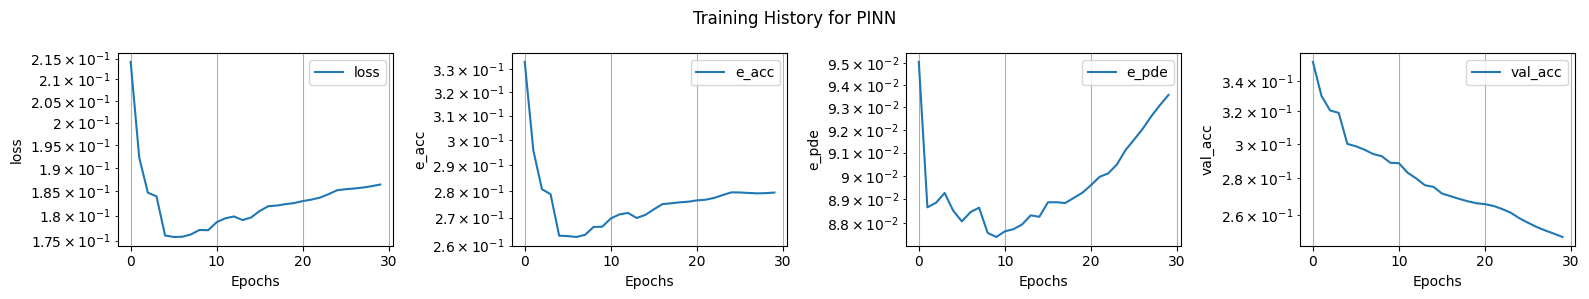

In [ ]:
plot_training_history(metrics_pinn, config_pinn)


In [142]:
save_params(params_pinn, f"model_params_{config_pinn.loss_str}_p_estimation.pkl")


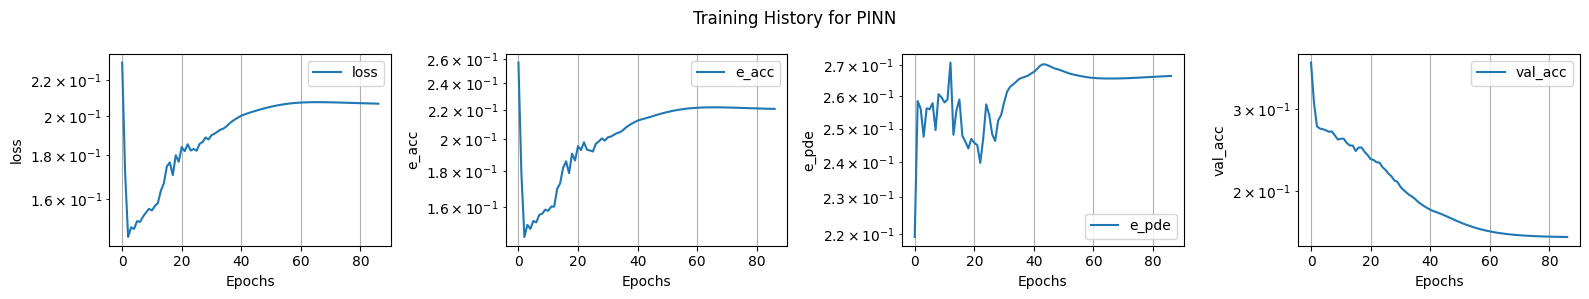

In [143]:
plot_training_history(metrics_pinn, config_pinn)


TESTING


In [12]:
# Generate 10 combinations of mu, theta, and sigma
params_dict = {}
for i in range(10):
    mu, theta, sigma = generate_random_parameters_univariate()  # Reproducibility with seed
    params_dict[f'combination_{i+1}'] = {'mu': mu, 'theta': theta, 'sigma': sigma}


In [13]:
print(params_dict)

{'combination_1': {'mu': 0.3745401188473625, 'theta': 1.9063571821788408, 'sigma': 0.7587945476302645}, 'combination_2': {'mu': 0.5986584841970366, 'theta': 0.39643541684062933, 'sigma': 0.2403950683025824}, 'combination_3': {'mu': 0.05808361216819946, 'theta': 1.745734676972377, 'sigma': 0.6410035105688879}, 'combination_4': {'mu': 0.7080725777960455, 'theta': 0.13911053916202465, 'sigma': 0.9729188669457949}, 'combination_5': {'mu': 0.8324426408004217, 'theta': 0.5034443102887247, 'sigma': 0.26364247048639056}, 'combination_6': {'mu': 0.18340450985343382, 'theta': 0.6780602616231216, 'sigma': 0.5722807884690141}, 'combination_7': {'mu': 0.43194501864211576, 'theta': 0.6533353663762795, 'sigma': 0.6506676052501416}, 'combination_8': {'mu': 0.13949386065204183, 'theta': 0.6550748322169144, 'sigma': 0.4297256589643226}, 'combination_9': {'mu': 0.45606998421703593, 'theta': 1.5918343266467259, 'sigma': 0.2797064039425238}, 'combination_10': {'mu': 0.5142344384136116, 'theta': 1.225587680

In [14]:
# Generate 10 combinations of mu, theta, and sigma
params_dict_20 = {}
for i in range(20):
    mu, theta, sigma = generate_random_parameters_univariate()  # Reproducibility with seed
    params_dict_20[f'combination_{i+1}'] = {'mu': mu, 'theta': theta, 'sigma': sigma}

In [15]:
print(params_dict_20)

{'combination_1': {'mu': 0.6075448519014384, 'theta': 0.4239958350058539, 'sigma': 0.1585464336867516}, 'combination_2': {'mu': 0.9488855372533332, 'theta': 1.9347008628416629, 'sigma': 0.827557613304815}, 'combination_3': {'mu': 0.3046137691733707, 'theta': 0.2855770166121293, 'sigma': 0.7158097238609412}, 'combination_4': {'mu': 0.4401524937396013, 'theta': 0.3318726462050797, 'sigma': 0.5456592191001431}, 'combination_5': {'mu': 0.034388521115218396, 'theta': 1.8277087639496858, 'sigma': 0.3329019834400152}, 'combination_6': {'mu': 0.662522284353982, 'theta': 0.6922510445698807, 'sigma': 0.5680612190600297}, 'combination_7': {'mu': 0.5467102793432796, 'theta': 0.45122346549850134, 'sigma': 0.9726261649881027}, 'combination_8': {'mu': 0.7751328233611146, 'theta': 1.8850479889719594, 'sigma': 0.905344615384884}, 'combination_9': {'mu': 0.5978999788110851, 'theta': 1.851561046543922, 'sigma': 0.17964325184672755}, 'combination_10': {'mu': 0.1959828624191452, 'theta': 0.1859318489300223

In [16]:
# Generate 30 combinations of mu, theta, and sigma
params_dict_30 = {}
for i in range(30):
    mu, theta, sigma = generate_random_parameters_univariate()  # Reproducibility with seed
    params_dict_30[f'combination_{i+1}'] = {'mu': mu, 'theta': theta, 'sigma': sigma}


In [17]:
print(params_dict_30)

{'combination_1': {'mu': 0.1195942459383017, 'theta': 1.4551650957236906, 'sigma': 0.7847065437552077}, 'combination_2': {'mu': 0.5612771975694962, 'theta': 1.5648376419136658, 'sigma': 0.5444160367279517}, 'combination_3': {'mu': 0.5227328293819941, 'theta': 0.9123279348812442, 'sigma': 0.12287721406968567}, 'combination_4': {'mu': 0.10789142699330445, 'theta': 0.15971545280479507, 'sigma': 0.6727693701374023}, 'combination_5': {'mu': 0.3143559810763267, 'theta': 1.0662843132129352, 'sigma': 0.9168098265334838}, 'combination_6': {'mu': 0.24929222914887494, 'theta': 0.8797275537676964, 'sigma': 0.7799960246887438}, 'combination_7': {'mu': 0.22879816549162246, 'theta': 0.2462618286747067, 'sigma': 0.3607763076223912}, 'combination_8': {'mu': 0.16122128725400442, 'theta': 1.8664255394508888, 'sigma': 0.8273083416079753}, 'combination_9': {'mu': 0.6334037565104235, 'theta': 1.7557751213566637, 'sigma': 0.823304869209203}, 'combination_10': {'mu': 0.18657005888603584, 'theta': 1.7958620971

In [18]:
# Generate 150 combinations of mu, theta, and sigma
params_dict_150 = {}
for i in range(150):
    mu, theta, sigma = generate_random_parameters_univariate()  # Reproducibility with seed
    params_dict_150[f'combination_{i+1}'] = {'mu': mu, 'theta': theta, 'sigma': sigma}

In [19]:
print(params_dict_150)

{'combination_1': {'mu': 0.3410663510502585, 'theta': 0.3155996903571192, 'sigma': 0.9322242564507065}, 'combination_2': {'mu': 0.877339353380981, 'theta': 0.5900890926587956, 'sigma': 0.6939856414307611}, 'combination_3': {'mu': 0.8172222002012158, 'theta': 1.1548815420389784, 'sigma': 0.5766855205204059}, 'combination_4': {'mu': 0.24185229090045168, 'theta': 0.27689525883120847, 'sigma': 0.907494182157994}, 'combination_5': {'mu': 0.9004180571633305, 'theta': 1.3028927688192091, 'sigma': 0.4051268119438306}, 'combination_6': {'mu': 0.3492095746126609, 'theta': 1.4793157898534548, 'sigma': 0.9073992339573194}, 'combination_7': {'mu': 0.8870864242651173, 'theta': 1.5817635371294854, 'sigma': 0.677828481538859}, 'combination_8': {'mu': 0.08413996499504883, 'theta': 0.40709455677976614, 'sigma': 0.9086987696743714}, 'combination_9': {'mu': 0.6064290596595899, 'theta': 0.11747439807159633, 'sigma': 0.1913243885794289}, 'combination_10': {'mu': 0.6635017691080558, 'theta': 0.10961700930781

TEST 10 SAMPLE WITH PINN

In [13]:
def kl_divergence(P_actual, P_pred):
    """
    Calculate the Kullback-Leibler Divergence between two probability distributions.

    Parameters:
    P_actual (np.ndarray): Actual probability distribution (shape: (n, m))
    P_pred (np.ndarray): Predicted probability distribution (shape: (n, m))

    Returns:
    float: KL divergence value
    """
    # Ensure the predicted and actual values are non-zero to avoid log(0)
    # Adding a small epsilon to prevent issues with zero values
    epsilon = 1e-10
    P_actual = np.clip(P_actual, epsilon, None)
    P_pred = np.clip(P_pred, epsilon, None)
    
    # Compute the element-wise KL divergence
    kl_values = P_actual * np.log(P_actual / P_pred)
    
    # Sum over all elements to get the total divergence
    kl_div = np.sum(kl_values)
    return kl_div



In [26]:
# Set start time 
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_PINN_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_pinn)

# Initialize a list to store MSE and K1 values
mse_pinn_10 = []
# store predictions and actua values
predictions_pinn_10 = []
targets_pinn_10 = []


k1_scores_pinn_10 = [] 

# Loop over the 10 parameter combinations
for key, param_set in params_dict.items():  # Assuming params_dict_10 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly
    
    # store predictions and actual values
    predictions_pinn_10.append(predictions)
    targets_pinn_10.append(targets)

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_pinn_10.append(mse)


    print(f"{key}: MSE = {mse}")
    #print(f"{key}: K1 Score = {k1_score}")

# Store the MSE scores for all combinations
mse_results_pinn_10 = {key: mse for key, mse in zip(params_dict.keys(), mse_pinn_10)}

# store predictions and actual values for all combinations
predictions_pinn_10 = {key: pred for key, pred in zip(params_dict.keys(), predictions_pinn_10)}

# store actual values for all combinations
targets_pinn_10 = {key: target for key, target in zip(params_dict.keys(), targets_pinn_10)}

# Save or print the results
# print(mse_results)

# Measure the mean and standard deviation of the MSE scores
mse_pinn_10 = np.array(mse_pinn_10)
mean_mse_10 = np.mean(mse_pinn_10)
std_mse_10 = np.std(mse_pinn_10)



# Print the scores
print(f"Mean MSE PINN 10 samples: {mean_mse_10}, Std. Dev. MSE PINN 10 samples: {std_mse_10}")

# Print execution time
print(f"Execution time PINN 10 samples: {time.time() - start_time:.2f} seconds")




combination_1: MSE = 0.09990360368183876
combination_2: MSE = 0.3156500779063966
combination_3: MSE = 0.2740375677242993
combination_4: MSE = 0.03341536474688874
combination_5: MSE = 0.19233009335906448
combination_6: MSE = 0.09735182733161442
combination_7: MSE = 0.0470233538389735
combination_8: MSE = 0.2032711265527133
combination_9: MSE = 0.7804444448814924
combination_10: MSE = 2.914647633500235
Mean MSE PINN 10 samples: 0.4958075093523516, Std. Dev. MSE PINN 10 samples: 0.83197601902591
Execution time PINN 10 samples: 2.50 seconds


In [27]:
# measure the K1 score for all the combinations
k1_scores_pinn_10 = []
for key, pred in predictions_pinn_10.items():
    k1_score = kl_divergence(targets_pinn_10[key], pred)
    k1_scores_pinn_10.append(k1_score)
    print(f"{key}: K1 Score = {k1_score}")

# Store the K1 scores for all combinations
k1_results_pinn_10 = {key: k1 for key, k1 in zip(params_dict.keys(), k1_scores_pinn_10)}

# Measure the mean and standard deviation of the K1 scores
k1_scores_pinn_10 = np.array(k1_scores_pinn_10)
mean_k1_10 = np.mean(k1_scores_pinn_10)
std_k1_10 = np.std(k1_scores_pinn_10)


combination_1: K1 Score = 496358539.7161878


KeyboardInterrupt: 

In [ ]:
# Print the scores
print(f"Mean MSE PINN 10 samples: {mean_mse_10}, Std. Dev. MSE PINN 10 samples: {std_mse_10}")
print(f"Mean K1 PINN 10 samples: {mean_k1_10}, Std. Dev. K1 PINN 10 samples: {std_k1_10}")

# Print execution time
print(f"Execution time PINN 10 samples: {time.time() - start_time:.2f} seconds")


Mean MSE PINN 10 sample: 0.5331948834706894, Std. Dev. MSE PINN 10 sample: 1.0650163189895139


TEST PINN 20 SAMPLES 

In [ ]:
# Set start time 
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_PINN_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_pinn)

# Initialize a list to store MSE and K1 values
mse_pinn_20 = []
k1_scores_pinn_20 = [] 

# Loop over the 10 parameter combinations
for key, param_set in params_dict_20.items():  # Assuming params_dict_20 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_pinn_20.append(mse)
    
    # Evaluate the K1 score
    k1_score = kl_divergence(targets, predictions)
    k1_scores_pinn_20.append(k1_score)

    print(f"{key}: MSE = {mse}")
    print(f"{key}: K1 Score = {k1_score}")

# Store the MSE scores for all combinations
mse_results_pinn_20 = {key: mse for key, mse in zip(params_dict_20.keys(), mse_pinn_20)}

# Store the K1 scores for all combinations
k1_results_pinn_20 = {key: k1 for key, k1 in zip(params_dict_20.keys(), k1_scores_pinn_20)}

# Save or print the results
# print(mse_results)

# Measure the mean and standard deviation of the MSE scores
mse_pinn_20 = np.array(mse_pinn_20)
mean_mse_20 = np.mean(mse_pinn_20)
std_mse_20 = np.std(mse_pinn_20)

# Measure the mean and standard deviation of the K1 scores
k1_scores_pinn_20 = np.array(k1_scores_pinn_20)
mean_k1_20 = np.mean(k1_scores_pinn_20)
std_k1_20 = np.std(k1_scores_pinn_20)

# Print the scores
print(f"Mean MSE PINN 20 samples: {mean_mse_20}, Std. Dev. MSE PINN 20 samples: {std_mse_20}")
print(f"Mean K1 PINN 20 samples: {mean_k1_20}, Std. Dev. K1 PINN 20 samples: {std_k1_20}")

# Print execution time
print(f"Execution time PINN 20 samples: {time.time() - start_time:.2f} seconds")



combination_1: MSE = 0.6555157084732766
combination_2: MSE = 0.2438721256728303
combination_3: MSE = 0.03331300192591927
combination_4: MSE = 1.7429786160380571
combination_5: MSE = 0.23711185157619008
combination_6: MSE = 0.018279624918963247
combination_7: MSE = 0.02941773654889884
combination_8: MSE = 0.07629691878877524
combination_9: MSE = 0.03261871642566005
combination_10: MSE = 1.337209540519659
combination_11: MSE = 0.01829007955673701
combination_12: MSE = 0.1244295978226694
combination_13: MSE = 2.619356385738676
combination_14: MSE = 0.03727502332515267
combination_15: MSE = 0.04006311475582521
combination_16: MSE = 0.013132069019807497
combination_17: MSE = 0.5919738982314039
combination_18: MSE = 0.1252471675458458
combination_19: MSE = 0.4420841495683886
combination_20: MSE = 0.04994751032634012
Mean MSE PINN 20 samples: 0.42342064183895384, Std. Dev. MSE PINN 20 samples: 0.6796712132438697
Execution time PINN 20 samples: 1.27 seconds


In [ ]:
# Print the scores
print(f"Mean MSE PINN 20 samples: {mean_mse_20}, Std. Dev. MSE PINN 20 samples: {std_mse_20}")
print(f"Mean K1 PINN 20 samples: {mean_k1_20}, Std. Dev. K1 PINN 20 samples: {std_k1_20}")

# Print execution time
print(f"Execution time PINN 20 samples: {time.time() - start_time:.2f} seconds")

Mean MSE PINN 20 samples: 0.42342064183895384, Std. Dev. MSE PINN 20 samples: 0.6796712132438697


TEST PINN 30 SAMPLES

In [ ]:
# Set start time 
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_PINN_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_pinn)

# Initialize a list to store MSE and K1 values
mse_pinn_30 = []
k1_scores_pinn_30 = [] 

# Loop over the 10 parameter combinations
for key, param_set in params_dict_30.items():  # Assuming params_dict_30 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_pinn_30.append(mse)
    
    # Evaluate the K1 score
    k1_score = kl_divergence(targets, predictions)
    k1_scores_pinn_30.append(k1_score)

    print(f"{key}: MSE = {mse}")
    print(f"{key}: K1 Score = {k1_score}")

# Store the MSE scores for all combinations
mse_results_pinn_30 = {key: mse for key, mse in zip(params_dict_30.keys(), mse_pinn_30)}

# Store the K1 scores for all combinations
k1_results_pinn_30 = {key: k1 for key, k1 in zip(params_dict_30.keys(), k1_scores_pinn_30)}

# Save or print the results
# print(mse_results)

# Measure the mean and standard deviation of the MSE scores
mse_pinn_30 = np.array(mse_pinn_30)
mean_mse_30 = np.mean(mse_pinn_30)
std_mse_30 = np.std(mse_pinn_30)

# Measure the mean and standard deviation of the K1 scores
k1_scores_pinn_30 = np.array(k1_scores_pinn_30)
mean_k1_30 = np.mean(k1_scores_pinn_30)
std_k1_30 = np.std(k1_scores_pinn_30)

# Print the scores
print(f"Mean MSE PINN 30 samples: {mean_mse_30}, Std. Dev. MSE PINN 30 samples: {std_mse_30}")
print(f"Mean K1 PINN 30 samples: {mean_k1_30}, Std. Dev. K1 PINN 30 samples: {std_k1_30}")

# Print execution time
print(f"Execution time PINN 30 samples: {time.time() - start_time:.2f} seconds")


combination_1: MSE = 0.12376071100592136
combination_2: MSE = 0.045194561950979144
combination_3: MSE = 0.8258093709927982
combination_4: MSE = 0.04091504567174475
combination_5: MSE = 0.19658515308080568
combination_6: MSE = 2.9151157496616076
combination_7: MSE = 0.01713917433083399
combination_8: MSE = 0.04733129402758454
combination_9: MSE = 0.01778392211917236
combination_10: MSE = 1.4672088743386589
combination_11: MSE = 0.06613717125261963
combination_12: MSE = 0.03934247876865108
combination_13: MSE = 0.033935981415959576
combination_14: MSE = 3.4279982282089807
combination_15: MSE = 0.05161851631354066
combination_16: MSE = 0.14374128405146386
combination_17: MSE = 0.4699807825755437
combination_18: MSE = 0.02920230088820874
combination_19: MSE = 0.12809647411849157
combination_20: MSE = 0.05123020345629826
combination_21: MSE = 0.8552738634422926
combination_22: MSE = 0.21469034459831884
combination_23: MSE = 0.3837721215125848
combination_24: MSE = 0.036492128370606516
combi

In [ ]:
# Print the scores
print(f"Mean MSE PINN 30 samples: {mean_mse_30}, Std. Dev. MSE PINN 30 samples: {std_mse_30}")
print(f"Mean K1 PINN 30 samples: {mean_k1_30}, Std. Dev. K1 PINN 30 samples: {std_k1_30}")

# Print execution time
print(f"Execution time PINN 30 samples: {time.time() - start_time:.2f} seconds")

Mean MSE PINN 30 samples: 0.5675279793461857, Std. Dev. MSE PINN 30 samples: 1.0295039258017582


TEST PINN WITH 150 SAMPLE

In [ ]:
# Set start time 
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_PINN_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_pinn)

# Initialize a list to store MSE and K1 values
mse_pinn_150 = []
k1_scores_pinn_150 = [] 

# Loop over the 10 parameter combinations
for key, param_set in params_dict_150.items():  # Assuming params_dict_150 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_pinn_150.append(mse)
    
    # evaluate the K1 score
    k1_score = kl_divergence(targets, predictions)
    k1_scores_pinn_150.append(k1_score)
    

    print(f"{key}: MSE = {mse}")
    
    print(f"{key}: K1 Score = {k1_score}")

# Store the MSE scores for all combinations
mse_results_pinn_150 = {key: mse for key, mse in zip(params_dict_150.keys(), mse_pinn_150)}

# store the K1 scores for all combinations
k1_results_pinn_150 = {key: k1 for key, k1 in zip(params_dict_150.keys(), k1_scores_pinn_150)}


# Save or print the results
# print(mse_results)

# Measure the mean and standard deviation of the MSE scores
mse_pinn_150 = np.array(mse_pinn_150)
mean_mse_150 = np.mean(mse_pinn_150)
std_mse_150 = np.std(mse_pinn_150)

# measure the mean and standard deviation of the K1 scores
k1_scores_pinn_150 = np.array(k1_scores_pinn_150)
mean_k1_150 = np.mean(k1_scores_pinn_150)
std_k1_150 = np.std(k1_scores_pinn_150)


# Print the scores
print(f"Mean MSE PINN 150 samples: {mean_mse_150}, Std. Dev. MSE PINN 150 samples: {std_mse_150}")

print(f"Mean K1 PINN 150 samples: {mean_k1_150}, Std. Dev. K1 PINN 150 samples: {std_k1_150}")

# Print execution time
print(f"Execution time PINN 150 samples: {time.time() - start_time:.2f} seconds")


combination_1: MSE = 0.04357853427624867
combination_2: MSE = 0.4967314577547484
combination_3: MSE = 0.03197065523592072
combination_4: MSE = 0.02696904202541809
combination_5: MSE = 0.060034178395950336
combination_6: MSE = 0.3479920942812434
combination_7: MSE = 0.03869277181745475
combination_8: MSE = 2.2530814092089932
combination_9: MSE = 0.4745110091512786
combination_10: MSE = 0.03150551811999678
combination_11: MSE = 0.7554889608040565
combination_12: MSE = 0.4011831315161364
combination_13: MSE = 0.036442190440542636
combination_14: MSE = 5.304106402798586
combination_15: MSE = 4.147932407900607
combination_16: MSE = 0.46256818359751417
combination_17: MSE = 0.0899037859183171
combination_18: MSE = 0.27540316941293347
combination_19: MSE = 0.035206686194154596
combination_20: MSE = 0.01325183450676438
combination_21: MSE = 0.13963763558423423
combination_22: MSE = 0.062123084474023184
combination_23: MSE = 0.023752925699701014
combination_24: MSE = 0.017535888225173345
combin

In [ ]:
# Print the scores
print(f"Mean MSE PINN 150 samples: {mean_mse_150}, Std. Dev. MSE PINN 150 samples: {std_mse_150}")

print(f"Mean K1 PINN 150 samples: {mean_k1_150}, Std. Dev. K1 PINN 150 samples: {std_k1_150}")

# Print execution time
print(f"Execution time PINN 150 samples: {time.time() - start_time:.2f} seconds")

Mean MSE PINN 150 samples: 0.4542545342738676, Std. Dev. MSE PINN 150 samples: 1.0567713665876026


/Users/francescostocchi/anaconda3/envs/thesis/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/francescostocchi/anaconda3/envs/thesis/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


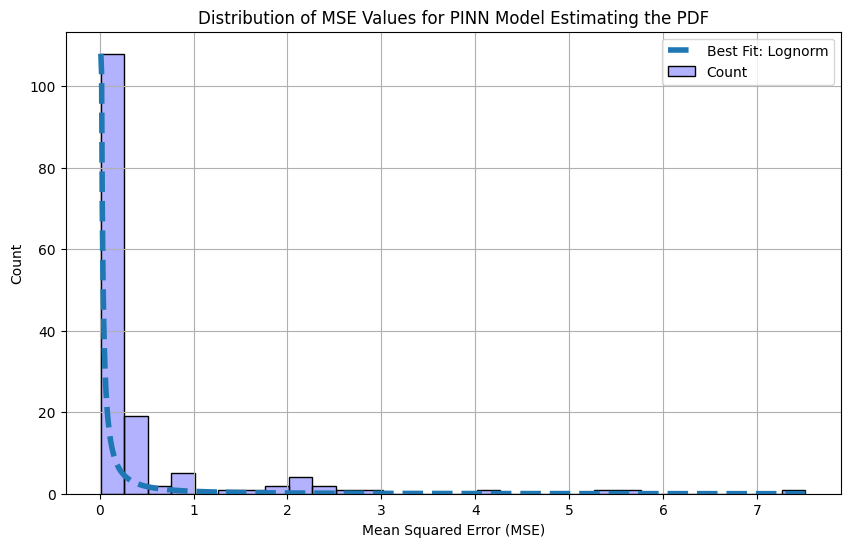

Kolmogorov-Smirnov Test for Lognorm:
KS Statistic: 0.0992
P-Value: 0.0974
Fail to reject the null hypothesis: The data follows the fitted distribution.


In [210]:


# Example MSE values (replace with your data)
mse_values_pinn = list(mse_results_pinn_150.values())

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram to get the bin heights
hist = sns.histplot(mse_values_pinn, kde=False, stat="count", bins=30, color='blue', alpha=0.3, label='Count')

# Extract bin heights to find the maximum count for scaling
bin_heights = [h.get_height() for h in hist.patches]
max_hist = max(bin_heights)

# Define possible distributions to fit
distributions = [lognorm, gamma, beta, weibull_min]

# Fit each distribution and calculate the AIC
best_fit = None
best_aic = np.inf
best_distribution = None
best_params = None
x = np.linspace(min(mse_values_pinn), max(mse_values_pinn), 1000)

for distribution in distributions:
    # Fit the distribution using MLE
    params = distribution.fit(mse_values_pinn)
    
    # Calculate the fitted PDF values
    pdf_values = distribution.pdf(x, *params)
    
    # Scale the PDF to match the histogram
    scaling_factor = max_hist / max(pdf_values)
    scaled_pdf_values = pdf_values * scaling_factor
    
    # Calculate the AIC
    log_likelihood = np.sum(np.log(distribution.pdf(mse_values_pinn, *params)))
    aic = 2 * len(params) - 2 * log_likelihood
    
    # Keep track of the best fit distribution
    if aic < best_aic:
        best_aic = aic
        best_distribution = distribution
        best_fit = scaled_pdf_values
        best_params = params

# Plot the best fitting distribution
plt.plot(x, best_fit, label=f'Best Fit: {best_distribution.name.capitalize()}', linestyle='--', linewidth=4)

# Add labels and title
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Count')
plt.title('Distribution of MSE Values for PINN Model Estimating the PDF')

# Add legend
plt.legend()
plt.grid(True)
plt.show()

# Goodness-of-Fit Test
# Perform the KS test
ks_stat, p_value = kstest(mse_values_pinn, best_distribution.name, args=best_params)

# Display the test results
print(f"Kolmogorov-Smirnov Test for {best_distribution.name.capitalize()}:")
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation of the p-value
alpha = 0.05  # significance level
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data follows the fitted distribution.")
else:
    print("Reject the null hypothesis: The data does not follow the fitted distribution.")



## MLP OPTIMIZATION

In [ ]:
def objective(trial):
    hidden_layers = trial.suggest_categorical('hidden_layers', [
        "256-128-64-32",
        "128-64-32-16",
        "64-32-16-8",
        "256-128-64",
        "128-64-32",
    ])
    num_epochs = trial.suggest_int('num_epochs', 50, 150)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    patience = trial.suggest_int('patience', 10, 20)
    batch_size = trial.suggest_int('batch_size', 512, 1024)

    hidden_layers_decoded = decode_hidden_layers(hidden_layers)
    
    # print the hyperparameters
    print(f"hidden_layers: {hidden_layers_decoded}, num_epochs: {num_epochs}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}, batch_size: {batch_size}")

    config = Config(
        seed=42,
        ann_in_dim=2,
        hidden_layers=hidden_layers_decoded,
        loss_str='MLP',
        data_source='FP_OU',
        num_epochs=num_epochs,
        log_interval=100,
        patience=patience,
        min_delta=1e-4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        batch_size=batch_size
    )

    params, metrics = train_model(config, data_train, theta_train, sigma_train, mu_train, batch_size)

    val_loss = metrics['val_acc'][-1]
    
    return val_loss


# Create a study object and specify the direction as "minimize"
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())

# Start the optimization
study.optimize(objective, n_trials=20)

# Get the best trial and its hyperparameters
best_trial_mlp = study.best_trial

print("Best trial:")
print(f"  Value: {best_trial_mlp.value}")
print("  Params: ")
for key, value in best_trial_mlp.params.items():
    print(f"    {key}: {value}")


[I 2024-09-17 12:56:49,968] A new study created in memory with name: no-name-34a7c93b-315f-49db-a8b4-b279665475bc


hidden_layers: (64, 32, 16, 8), num_epochs: 107, learning_rate: 0.000495015600351306, weight_decay: 0.0006736783905428062, patience: 12, batch_size: 644
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (644, 1)
Calling time_derivative with t shape: (644, 1) and x shape: (644, 1)
Calling spatial_derivatives with x shape: (112, 1)
Calling time_derivative with t shape: (112, 1) and x shape: (112, 1)
Epoch 0 end: Loss = 0.3444863557815552, Metric = {'e_acc': Array(0.34448636, dtype=float32), 'e_pde': Array(0.24469495, dtype=float32), 'val_acc': Array(0.6022274, dtype=float32)}
Epoch 0: Loss = 0.3444863557815552, Val Acc = 0.6022273898124695
Epoch 0: Best Val Loss = inf, Current Val Loss = 0.6022273898124695, Delta = inf
Epoch 1 start
Epoch 1 end: Loss = 0.2830776870250702, Metric = {'e_acc': Array(0.2830777, dtype=float32), 'e_pde': Array(0.6015958, dtype=float32), 'val_acc': Array(0.518382, dtype=float32)}
Epoch 1: Best Val Loss = 0.6022273898124

[I 2024-09-17 12:57:31,442] Trial 0 finished with value: 0.2568194568157196 and parameters: {'hidden_layers': '64-32-16-8', 'num_epochs': 107, 'learning_rate': 0.000495015600351306, 'weight_decay': 0.0006736783905428062, 'patience': 12, 'batch_size': 644}. Best is trial 0 with value: 0.2568194568157196.


Epoch 106 end: Loss = 0.1837027370929718, Metric = {'e_acc': Array(0.18370274, dtype=float32), 'e_pde': Array(1.9427608, dtype=float32), 'val_acc': Array(0.25681946, dtype=float32)}
Epoch 106: Best Val Loss = 0.25691962242126465, Current Val Loss = 0.2568194568157196, Delta = 0.00010016560554504395
----- Calibration MLP epoch 106 in 41.44 sec ------
hidden_layers: (128, 64, 32, 16), num_epochs: 52, learning_rate: 3.530520756450739e-05, weight_decay: 0.007578613322894021, patience: 15, batch_size: 775
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (775, 1)
Calling time_derivative with t shape: (775, 1) and x shape: (775, 1)
Calling spatial_derivatives with x shape: (725, 1)
Calling time_derivative with t shape: (725, 1) and x shape: (725, 1)
Epoch 0 end: Loss = 0.43381786346435547, Metric = {'e_acc': Array(0.43381786, dtype=float32), 'e_pde': Array(0.24149281, dtype=float32), 'val_acc': Array(0.64911, dtype=float32)}
Epoch 0: Loss = 0.4338178

[I 2024-09-17 12:57:55,552] Trial 1 finished with value: 0.33542153239250183 and parameters: {'hidden_layers': '128-64-32-16', 'num_epochs': 52, 'learning_rate': 3.530520756450739e-05, 'weight_decay': 0.007578613322894021, 'patience': 15, 'batch_size': 775}. Best is trial 0 with value: 0.2568194568157196.


Epoch 51 end: Loss = 0.23150797188282013, Metric = {'e_acc': Array(0.23150797, dtype=float32), 'e_pde': Array(0.3862319, dtype=float32), 'val_acc': Array(0.33542153, dtype=float32)}
Epoch 51: Best Val Loss = 0.3359725773334503, Current Val Loss = 0.33542153239250183, Delta = 0.0005510449409484863
----- Calibration MLP epoch 51 in 24.09 sec ------
hidden_layers: (128, 64, 32), num_epochs: 123, learning_rate: 5.6769908518728495e-05, weight_decay: 0.0055146224824532035, patience: 12, batch_size: 953
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (953, 1)
Calling time_derivative with t shape: (953, 1) and x shape: (953, 1)
Calling spatial_derivatives with x shape: (680, 1)
Calling time_derivative with t shape: (680, 1) and x shape: (680, 1)
Epoch 0 end: Loss = 0.4105759263038635, Metric = {'e_acc': Array(0.41057593, dtype=float32), 'e_pde': Array(0.20866556, dtype=float32), 'val_acc': Array(0.63425124, dtype=float32)}
Epoch 0: Loss = 0.410575926

[I 2024-09-17 12:58:33,446] Trial 2 finished with value: 0.31180575489997864 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 123, 'learning_rate': 5.6769908518728495e-05, 'weight_decay': 0.0055146224824532035, 'patience': 12, 'batch_size': 953}. Best is trial 0 with value: 0.2568194568157196.


Epoch 122 end: Loss = 0.2217271476984024, Metric = {'e_acc': Array(0.22172715, dtype=float32), 'e_pde': Array(0.44855702, dtype=float32), 'val_acc': Array(0.31180575, dtype=float32)}
Epoch 122: Best Val Loss = 0.31187495589256287, Current Val Loss = 0.31180575489997864, Delta = 6.920099258422852e-05
----- Calibration MLP epoch 122 in 37.88 sec ------
hidden_layers: (128, 64, 32, 16), num_epochs: 140, learning_rate: 1.588991613726289e-05, weight_decay: 0.049713787880426734, patience: 13, batch_size: 641
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (641, 1)
Calling time_derivative with t shape: (641, 1) and x shape: (641, 1)
Calling spatial_derivatives with x shape: (145, 1)
Calling time_derivative with t shape: (145, 1) and x shape: (145, 1)
Epoch 0 end: Loss = 0.4524674713611603, Metric = {'e_acc': Array(0.45246747, dtype=float32), 'e_pde': Array(0.2764662, dtype=float32), 'val_acc': Array(0.6569953, dtype=float32)}
Epoch 0: Loss = 0.45246

[I 2024-09-17 12:59:46,727] Trial 3 finished with value: 0.5388545989990234 and parameters: {'hidden_layers': '128-64-32-16', 'num_epochs': 140, 'learning_rate': 1.588991613726289e-05, 'weight_decay': 0.049713787880426734, 'patience': 13, 'batch_size': 641}. Best is trial 0 with value: 0.2568194568157196.


Epoch 139 end: Loss = 0.3515428900718689, Metric = {'e_acc': Array(0.3515429, dtype=float32), 'e_pde': Array(0.16837427, dtype=float32), 'val_acc': Array(0.5388546, dtype=float32)}
Epoch 139: Best Val Loss = 0.5389261841773987, Current Val Loss = 0.5388545989990234, Delta = 7.158517837524414e-05
----- Calibration MLP epoch 139 in 73.26 sec ------
hidden_layers: (128, 64, 32), num_epochs: 108, learning_rate: 0.0005585961998007913, weight_decay: 6.638848650919829e-05, patience: 16, batch_size: 793
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (793, 1)
Calling time_derivative with t shape: (793, 1) and x shape: (793, 1)
Calling spatial_derivatives with x shape: (503, 1)
Calling time_derivative with t shape: (503, 1) and x shape: (503, 1)
Epoch 0 end: Loss = 0.3548608720302582, Metric = {'e_acc': Array(0.35486087, dtype=float32), 'e_pde': Array(0.31046912, dtype=float32), 'val_acc': Array(0.61444235, dtype=float32)}
Epoch 0: Loss = 0.3548608720

[I 2024-09-17 13:00:27,058] Trial 4 finished with value: 0.24476350843906403 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 108, 'learning_rate': 0.0005585961998007913, 'weight_decay': 6.638848650919829e-05, 'patience': 16, 'batch_size': 793}. Best is trial 4 with value: 0.24476350843906403.


Epoch 107 end: Loss = 0.17508874833583832, Metric = {'e_acc': Array(0.17508875, dtype=float32), 'e_pde': Array(6.63042, dtype=float32), 'val_acc': Array(0.24476351, dtype=float32)}
Epoch 107: Best Val Loss = 0.24493005871772766, Current Val Loss = 0.24476350843906403, Delta = 0.00016655027866363525
----- Calibration MLP epoch 107 in 40.31 sec ------
hidden_layers: (256, 128, 64), num_epochs: 131, learning_rate: 7.328820906509229e-05, weight_decay: 0.0004844565958652671, patience: 14, batch_size: 598
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (598, 1)
Calling time_derivative with t shape: (598, 1) and x shape: (598, 1)
Calling spatial_derivatives with x shape: (204, 1)
Calling time_derivative with t shape: (204, 1) and x shape: (204, 1)
Epoch 0 end: Loss = 0.33522263169288635, Metric = {'e_acc': Array(0.33522263, dtype=float32), 'e_pde': Array(0.17796665, dtype=float32), 'val_acc': Array(0.57756233, dtype=float32)}
Epoch 0: Loss = 0.33522

[I 2024-09-17 13:02:07,462] Trial 5 finished with value: 0.2854922413825989 and parameters: {'hidden_layers': '256-128-64', 'num_epochs': 131, 'learning_rate': 7.328820906509229e-05, 'weight_decay': 0.0004844565958652671, 'patience': 14, 'batch_size': 598}. Best is trial 4 with value: 0.24476350843906403.


Epoch 130 end: Loss = 0.19695986807346344, Metric = {'e_acc': Array(0.19695987, dtype=float32), 'e_pde': Array(0.8248047, dtype=float32), 'val_acc': Array(0.28549224, dtype=float32)}
Epoch 130: Best Val Loss = 0.2856241762638092, Current Val Loss = 0.2854922413825989, Delta = 0.00013193488121032715
----- Calibration MLP epoch 130 in 100.39 sec ------
hidden_layers: (256, 128, 64, 32), num_epochs: 143, learning_rate: 0.0003378729276281554, weight_decay: 0.0022757330417184553, patience: 19, batch_size: 901
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (901, 1)
Calling time_derivative with t shape: (901, 1) and x shape: (901, 1)
Calling spatial_derivatives with x shape: (134, 1)
Calling time_derivative with t shape: (134, 1) and x shape: (134, 1)
Epoch 0 end: Loss = 0.3354925215244293, Metric = {'e_acc': Array(0.33549252, dtype=float32), 'e_pde': Array(0.31461868, dtype=float32), 'val_acc': Array(0.59750223, dtype=float32)}
Epoch 0: Loss = 0.3

[I 2024-09-17 13:03:36,595] Trial 6 finished with value: 0.27614471316337585 and parameters: {'hidden_layers': '256-128-64-32', 'num_epochs': 143, 'learning_rate': 0.0003378729276281554, 'weight_decay': 0.0022757330417184553, 'patience': 19, 'batch_size': 901}. Best is trial 4 with value: 0.24476350843906403.


Epoch 142 end: Loss = 0.19582964479923248, Metric = {'e_acc': Array(0.19582964, dtype=float32), 'e_pde': Array(0.93561894, dtype=float32), 'val_acc': Array(0.2761447, dtype=float32)}
Epoch 142: Best Val Loss = 0.276339054107666, Current Val Loss = 0.27614471316337585, Delta = 0.00019434094429016113
----- Calibration MLP epoch 142 in 89.11 sec ------
hidden_layers: (128, 64, 32, 16), num_epochs: 59, learning_rate: 0.00020152128386650658, weight_decay: 0.00028204033592917733, patience: 18, batch_size: 873
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (873, 1)
Calling time_derivative with t shape: (873, 1) and x shape: (873, 1)
Calling spatial_derivatives with x shape: (87, 1)
Calling time_derivative with t shape: (87, 1) and x shape: (87, 1)
Epoch 0 end: Loss = 0.38353806734085083, Metric = {'e_acc': Array(0.38353807, dtype=float32), 'e_pde': Array(0.19204102, dtype=float32), 'val_acc': Array(0.6128008, dtype=float32)}
Epoch 0: Loss = 0.38353

[I 2024-09-17 13:04:01,903] Trial 7 finished with value: 0.27284738421440125 and parameters: {'hidden_layers': '128-64-32-16', 'num_epochs': 59, 'learning_rate': 0.00020152128386650658, 'weight_decay': 0.00028204033592917733, 'patience': 18, 'batch_size': 873}. Best is trial 4 with value: 0.24476350843906403.


Epoch 58 end: Loss = 0.18831612169742584, Metric = {'e_acc': Array(0.18831612, dtype=float32), 'e_pde': Array(2.311896, dtype=float32), 'val_acc': Array(0.27284738, dtype=float32)}
Epoch 58: Best Val Loss = 0.27357766032218933, Current Val Loss = 0.27284738421440125, Delta = 0.0007302761077880859
----- Calibration MLP epoch 58 in 25.29 sec ------
hidden_layers: (64, 32, 16, 8), num_epochs: 77, learning_rate: 1.8343591385815322e-05, weight_decay: 3.4706674790118886e-05, patience: 13, batch_size: 721
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (721, 1)
Calling time_derivative with t shape: (721, 1) and x shape: (721, 1)
Calling spatial_derivatives with x shape: (378, 1)
Calling time_derivative with t shape: (378, 1) and x shape: (378, 1)
Epoch 0 end: Loss = 0.4310346841812134, Metric = {'e_acc': Array(0.43103468, dtype=float32), 'e_pde': Array(0.21921958, dtype=float32), 'val_acc': Array(0.6565117, dtype=float32)}
Epoch 0: Loss = 0.43103468

[I 2024-09-17 13:04:30,245] Trial 8 finished with value: 0.3581479787826538 and parameters: {'hidden_layers': '64-32-16-8', 'num_epochs': 77, 'learning_rate': 1.8343591385815322e-05, 'weight_decay': 3.4706674790118886e-05, 'patience': 13, 'batch_size': 721}. Best is trial 4 with value: 0.24476350843906403.


Epoch 76 end: Loss = 0.24597139656543732, Metric = {'e_acc': Array(0.2459714, dtype=float32), 'e_pde': Array(0.3363546, dtype=float32), 'val_acc': Array(0.35814798, dtype=float32)}
Epoch 76: Best Val Loss = 0.35852983593940735, Current Val Loss = 0.3581479787826538, Delta = 0.00038185715675354004
----- Calibration MLP epoch 76 in 28.32 sec ------
hidden_layers: (128, 64, 32, 16), num_epochs: 73, learning_rate: 5.7844628360017546e-05, weight_decay: 0.009399083185257923, patience: 11, batch_size: 670
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (670, 1)
Calling time_derivative with t shape: (670, 1) and x shape: (670, 1)
Calling spatial_derivatives with x shape: (580, 1)
Calling time_derivative with t shape: (580, 1) and x shape: (580, 1)
Epoch 0 end: Loss = 0.41085147857666016, Metric = {'e_acc': Array(0.41085148, dtype=float32), 'e_pde': Array(0.2163056, dtype=float32), 'val_acc': Array(0.634041, dtype=float32)}
Epoch 0: Loss = 0.410851478

[I 2024-09-17 13:05:07,823] Trial 9 finished with value: 0.32538115978240967 and parameters: {'hidden_layers': '128-64-32-16', 'num_epochs': 73, 'learning_rate': 5.7844628360017546e-05, 'weight_decay': 0.009399083185257923, 'patience': 11, 'batch_size': 670}. Best is trial 4 with value: 0.24476350843906403.


Epoch 72 end: Loss = 0.2315431386232376, Metric = {'e_acc': Array(0.23154314, dtype=float32), 'e_pde': Array(0.408378, dtype=float32), 'val_acc': Array(0.32538116, dtype=float32)}
Epoch 72: Best Val Loss = 0.32559171319007874, Current Val Loss = 0.32538115978240967, Delta = 0.00021055340766906738
----- Calibration MLP epoch 72 in 37.56 sec ------
hidden_layers: (128, 64, 32), num_epochs: 100, learning_rate: 0.0008855201995540288, weight_decay: 1.4623109105694106e-05, patience: 16, batch_size: 538
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (538, 1)
Calling time_derivative with t shape: (538, 1) and x shape: (538, 1)
Calling spatial_derivatives with x shape: (360, 1)
Calling time_derivative with t shape: (360, 1) and x shape: (360, 1)
Epoch 0 end: Loss = 0.29715496301651, Metric = {'e_acc': Array(0.29715496, dtype=float32), 'e_pde': Array(0.6033818, dtype=float32), 'val_acc': Array(0.64596295, dtype=float32)}
Epoch 0: Loss = 0.297154963016

[I 2024-09-17 13:06:00,236] Trial 10 finished with value: 0.24019241333007812 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 100, 'learning_rate': 0.0008855201995540288, 'weight_decay': 1.4623109105694106e-05, 'patience': 16, 'batch_size': 538}. Best is trial 10 with value: 0.24019241333007812.


Epoch 99 end: Loss = 0.17241474986076355, Metric = {'e_acc': Array(0.17241475, dtype=float32), 'e_pde': Array(19.205244, dtype=float32), 'val_acc': Array(0.24019241, dtype=float32)}
Epoch 99: Best Val Loss = 0.24032339453697205, Current Val Loss = 0.24019241333007812, Delta = 0.0001309812068939209
----- Calibration MLP epoch 99 in 52.39 sec ------
hidden_layers: (128, 64, 32), num_epochs: 101, learning_rate: 0.000926777045812581, weight_decay: 1.2573309465183368e-05, patience: 16, batch_size: 529
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (529, 1)
Calling time_derivative with t shape: (529, 1) and x shape: (529, 1)
Calling spatial_derivatives with x shape: (503, 1)
Calling time_derivative with t shape: (503, 1) and x shape: (503, 1)
Epoch 0 end: Loss = 0.23442292213439941, Metric = {'e_acc': Array(0.23442292, dtype=float32), 'e_pde': Array(0.5794302, dtype=float32), 'val_acc': Array(0.60633796, dtype=float32)}
Epoch 0: Loss = 0.234422922

[I 2024-09-17 13:06:53,794] Trial 11 finished with value: 0.24231423437595367 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 101, 'learning_rate': 0.000926777045812581, 'weight_decay': 1.2573309465183368e-05, 'patience': 16, 'batch_size': 529}. Best is trial 10 with value: 0.24019241333007812.


Epoch 100 end: Loss = 0.1739189326763153, Metric = {'e_acc': Array(0.17391893, dtype=float32), 'e_pde': Array(20.359484, dtype=float32), 'val_acc': Array(0.24231423, dtype=float32)}
Epoch 100: Loss = 0.1739189326763153, Val Acc = 0.24231423437595367
Epoch 100: Best Val Loss = 0.24251136183738708, Current Val Loss = 0.24231423437595367, Delta = 0.00019712746143341064
----- Calibration MLP epoch 100 in 53.53 sec ------
hidden_layers: (128, 64, 32), num_epochs: 90, learning_rate: 0.0009538956353692393, weight_decay: 1.0277147228274277e-05, patience: 17, batch_size: 517
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (517, 1)
Calling time_derivative with t shape: (517, 1) and x shape: (517, 1)
Calling spatial_derivatives with x shape: (196, 1)
Calling time_derivative with t shape: (196, 1) and x shape: (196, 1)
Epoch 0 end: Loss = 0.22940225899219513, Metric = {'e_acc': Array(0.22940226, dtype=float32), 'e_pde': Array(0.5719483, dtype=float32), '

[I 2024-09-17 13:07:42,706] Trial 12 finished with value: 0.23854053020477295 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 90, 'learning_rate': 0.0009538956353692393, 'weight_decay': 1.0277147228274277e-05, 'patience': 17, 'batch_size': 517}. Best is trial 12 with value: 0.23854053020477295.


Epoch 89 end: Loss = 0.17156030237674713, Metric = {'e_acc': Array(0.1715603, dtype=float32), 'e_pde': Array(31.242249, dtype=float32), 'val_acc': Array(0.23854053, dtype=float32)}
Epoch 89: Best Val Loss = 0.23874516785144806, Current Val Loss = 0.23854053020477295, Delta = 0.00020463764667510986
----- Calibration MLP epoch 89 in 48.89 sec ------
hidden_layers: (128, 64, 32), num_epochs: 85, learning_rate: 0.00018842411709326835, weight_decay: 1.0502411922496019e-05, patience: 17, batch_size: 529
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (529, 1)
Calling time_derivative with t shape: (529, 1) and x shape: (529, 1)
Calling spatial_derivatives with x shape: (503, 1)
Calling time_derivative with t shape: (503, 1) and x shape: (503, 1)
Epoch 0 end: Loss = 0.34815093874931335, Metric = {'e_acc': Array(0.34815094, dtype=float32), 'e_pde': Array(0.2244837, dtype=float32), 'val_acc': Array(0.5967798, dtype=float32)}
Epoch 0: Loss = 0.348150938

[I 2024-09-17 13:08:27,837] Trial 13 finished with value: 0.24919666349887848 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 85, 'learning_rate': 0.00018842411709326835, 'weight_decay': 1.0502411922496019e-05, 'patience': 17, 'batch_size': 529}. Best is trial 12 with value: 0.23854053020477295.


Epoch 84 end: Loss = 0.17857855558395386, Metric = {'e_acc': Array(0.17857856, dtype=float32), 'e_pde': Array(2.8571541, dtype=float32), 'val_acc': Array(0.24919666, dtype=float32)}
Epoch 84: Best Val Loss = 0.24932260811328888, Current Val Loss = 0.24919666349887848, Delta = 0.0001259446144104004
----- Calibration MLP epoch 84 in 45.11 sec ------
hidden_layers: (128, 64, 32), num_epochs: 92, learning_rate: 0.0009570253806639643, weight_decay: 0.00010604208922039444, patience: 20, batch_size: 586
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (586, 1)
Calling time_derivative with t shape: (586, 1) and x shape: (586, 1)
Calling spatial_derivatives with x shape: (424, 1)
Calling time_derivative with t shape: (424, 1) and x shape: (424, 1)
Epoch 0 end: Loss = 0.30926159024238586, Metric = {'e_acc': Array(0.3092616, dtype=float32), 'e_pde': Array(0.637858, dtype=float32), 'val_acc': Array(0.640974, dtype=float32)}
Epoch 0: Loss = 0.3092615902423

[I 2024-09-17 13:09:13,157] Trial 14 finished with value: 0.24754895269870758 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 92, 'learning_rate': 0.0009570253806639643, 'weight_decay': 0.00010604208922039444, 'patience': 20, 'batch_size': 586}. Best is trial 12 with value: 0.23854053020477295.


Epoch 91 end: Loss = 0.17806507647037506, Metric = {'e_acc': Array(0.17806508, dtype=float32), 'e_pde': Array(8.564432, dtype=float32), 'val_acc': Array(0.24754895, dtype=float32)}
Epoch 91: Best Val Loss = 0.24786251783370972, Current Val Loss = 0.24754895269870758, Delta = 0.00031356513500213623
----- Calibration MLP epoch 91 in 45.29 sec ------
hidden_layers: (256, 128, 64, 32), num_epochs: 120, learning_rate: 0.00019609960367768546, weight_decay: 3.1080228562663324e-05, patience: 18, batch_size: 513
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (513, 1)
Calling time_derivative with t shape: (513, 1) and x shape: (513, 1)
Calling spatial_derivatives with x shape: (366, 1)
Calling time_derivative with t shape: (366, 1) and x shape: (366, 1)
Epoch 0 end: Loss = 0.2714206278324127, Metric = {'e_acc': Array(0.27142063, dtype=float32), 'e_pde': Array(0.41571438, dtype=float32), 'val_acc': Array(0.5889394, dtype=float32)}
Epoch 0: Loss = 0.271

[I 2024-09-17 13:11:16,570] Trial 15 finished with value: 0.2406345158815384 and parameters: {'hidden_layers': '256-128-64-32', 'num_epochs': 120, 'learning_rate': 0.00019609960367768546, 'weight_decay': 3.1080228562663324e-05, 'patience': 18, 'batch_size': 513}. Best is trial 12 with value: 0.23854053020477295.


Epoch 119 end: Loss = 0.17058689892292023, Metric = {'e_acc': Array(0.1705869, dtype=float32), 'e_pde': Array(7.3871565, dtype=float32), 'val_acc': Array(0.24063452, dtype=float32)}
Epoch 119: Best Val Loss = 0.24068722128868103, Current Val Loss = 0.2406345158815384, Delta = 5.270540714263916e-05
----- Calibration MLP epoch 119 in 123.38 sec ------
hidden_layers: (256, 128, 64), num_epochs: 91, learning_rate: 0.00039994373918929375, weight_decay: 0.00016665028344682952, patience: 16, batch_size: 591
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (591, 1)
Calling time_derivative with t shape: (591, 1) and x shape: (591, 1)
Calling spatial_derivatives with x shape: (390, 1)
Calling time_derivative with t shape: (390, 1) and x shape: (390, 1)
Epoch 0 end: Loss = 0.27994900941848755, Metric = {'e_acc': Array(0.279949, dtype=float32), 'e_pde': Array(0.40837565, dtype=float32), 'val_acc': Array(0.63301134, dtype=float32)}
Epoch 0: Loss = 0.279949

[I 2024-09-17 13:12:27,745] Trial 16 finished with value: 0.24705977737903595 and parameters: {'hidden_layers': '256-128-64', 'num_epochs': 91, 'learning_rate': 0.00039994373918929375, 'weight_decay': 0.00016665028344682952, 'patience': 16, 'batch_size': 591}. Best is trial 12 with value: 0.23854053020477295.


Epoch 90 end: Loss = 0.17687968909740448, Metric = {'e_acc': Array(0.17687969, dtype=float32), 'e_pde': Array(4.3292584, dtype=float32), 'val_acc': Array(0.24705978, dtype=float32)}
Epoch 90: Best Val Loss = 0.24729283154010773, Current Val Loss = 0.24705977737903595, Delta = 0.00023305416107177734
----- Calibration MLP epoch 90 in 71.15 sec ------
hidden_layers: (128, 64, 32), num_epochs: 69, learning_rate: 0.0009893641497328658, weight_decay: 2.988591607303499e-05, patience: 18, batch_size: 718
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (718, 1)
Calling time_derivative with t shape: (718, 1) and x shape: (718, 1)
Calling spatial_derivatives with x shape: (688, 1)
Calling time_derivative with t shape: (688, 1) and x shape: (688, 1)
Epoch 0 end: Loss = 0.35426366329193115, Metric = {'e_acc': Array(0.35426366, dtype=float32), 'e_pde': Array(0.4452238, dtype=float32), 'val_acc': Array(0.64537895, dtype=float32)}
Epoch 0: Loss = 0.354263663

[I 2024-09-17 13:12:56,323] Trial 17 finished with value: 0.26325759291648865 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 69, 'learning_rate': 0.0009893641497328658, 'weight_decay': 2.988591607303499e-05, 'patience': 18, 'batch_size': 718}. Best is trial 12 with value: 0.23854053020477295.


Epoch 68 end: Loss = 0.1831866353750229, Metric = {'e_acc': Array(0.18318664, dtype=float32), 'e_pde': Array(18.171131, dtype=float32), 'val_acc': Array(0.2632576, dtype=float32)}
Epoch 68: Best Val Loss = 0.26411110162734985, Current Val Loss = 0.26325759291648865, Delta = 0.0008535087108612061
----- Calibration MLP epoch 68 in 28.55 sec ------
hidden_layers: (128, 64, 32), num_epochs: 115, learning_rate: 0.0001320557308036765, weight_decay: 0.09699407208078004, patience: 15, batch_size: 1024
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (1024, 1)
Calling time_derivative with t shape: (1024, 1) and x shape: (1024, 1)
Calling spatial_derivatives with x shape: (160, 1)
Calling time_derivative with t shape: (160, 1) and x shape: (160, 1)
Epoch 0 end: Loss = 0.42312341928482056, Metric = {'e_acc': Array(0.42312342, dtype=float32), 'e_pde': Array(0.22568254, dtype=float32), 'val_acc': Array(0.65287954, dtype=float32)}
Epoch 0: Loss = 0.42312341

[I 2024-09-17 13:13:02,461] Trial 18 finished with value: 0.6569936871528625 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 115, 'learning_rate': 0.0001320557308036765, 'weight_decay': 0.09699407208078004, 'patience': 15, 'batch_size': 1024}. Best is trial 12 with value: 0.23854053020477295.


Epoch 15 end: Loss = 0.4356682002544403, Metric = {'e_acc': Array(0.4356682, dtype=float32), 'e_pde': Array(0.2278951, dtype=float32), 'val_acc': Array(0.6569937, dtype=float32)}
Epoch 15: Best Val Loss = 0.652879536151886, Current Val Loss = 0.6569936871528625, Delta = -0.0041141510009765625
Early stopping at epoch 15. Best validation loss: 0.652879536151886
----- Calibration MLP epoch 15 in 6.11 sec ------
hidden_layers: (128, 64, 32), num_epochs: 83, learning_rate: 0.0006208360989003338, weight_decay: 1.1973100758008662e-05, patience: 10, batch_size: 568
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (568, 1)
Calling time_derivative with t shape: (568, 1) and x shape: (568, 1)
Calling spatial_derivatives with x shape: (248, 1)
Calling time_derivative with t shape: (248, 1) and x shape: (248, 1)
Epoch 0 end: Loss = 0.3239646255970001, Metric = {'e_acc': Array(0.32396463, dtype=float32), 'e_pde': Array(0.5775537, dtype=float32), 'val_acc': 

[I 2024-09-17 13:13:44,049] Trial 19 finished with value: 0.24653972685337067 and parameters: {'hidden_layers': '128-64-32', 'num_epochs': 83, 'learning_rate': 0.0006208360989003338, 'weight_decay': 1.1973100758008662e-05, 'patience': 10, 'batch_size': 568}. Best is trial 12 with value: 0.23854053020477295.


Epoch 82 end: Loss = 0.1764751821756363, Metric = {'e_acc': Array(0.17647518, dtype=float32), 'e_pde': Array(7.669155, dtype=float32), 'val_acc': Array(0.24653973, dtype=float32)}
Epoch 82: Best Val Loss = 0.24683234095573425, Current Val Loss = 0.24653972685337067, Delta = 0.0002926141023635864
----- Calibration MLP epoch 82 in 41.56 sec ------
Best trial:
  Value: 0.23854053020477295
  Params: 
    hidden_layers: 128-64-32
    num_epochs: 90
    learning_rate: 0.0009538956353692393
    weight_decay: 1.0277147228274277e-05
    patience: 17
    batch_size: 517


In [ ]:
print("Best trial :")
print(f"  Value: {best_trial_mlp.value}")
print("  Params: ")
for key, value in best_trial_mlp.params.items():
    print(f"    {key}: {value}")


Best trial :
  Value: 0.23854053020477295
  Params: 
    hidden_layers: 128-64-32
    num_epochs: 90
    learning_rate: 0.0009538956353692393
    weight_decay: 1.0277147228274277e-05
    patience: 17
    batch_size: 517


In [20]:
best_params_mlp = {
    'hidden_layers': '128-64-32',  # Use a string
    'num_epochs': 90,
    'learning_rate': 0.0009538956353692393,
    'weight_decay': 1.0277147228274277e-05,
    'patience': 17,
    'batch_size': 517
}

In [21]:
# Extracting and printing the best hyperparameters
'''
best_params_mlp = {}
for key, value in best_trial_mlp.params.items():
    print(f"    {key}: {value}")
    best_params_mlp[key] = value

batch_size=best_params_mlp['batch_size']  # Using the value from best_params
'''

# Decode the hidden layers
decoded_hidden_layers = decode_hidden_layers(best_params_mlp['hidden_layers'])

# Create the Config using the best hyperparameters
config_mlp = Config(
    seed=42,
    ann_in_dim=2,
    hidden_layers=decoded_hidden_layers,  # Using the value from best_params
    loss_str='MLP',
    data_source='FP_OU',
    num_epochs=best_params_mlp['num_epochs'],  # Using the value from best_params
    log_interval=100,
    patience=best_params_mlp['patience'],  # Using the value from best_params
    min_delta=1e-6,
    learning_rate=best_params_mlp['learning_rate'],  # Using the value from best_params
    weight_decay=best_params_mlp['weight_decay'],  # Using the value from best_params
)



In [ ]:

params_mlp, metrics_mlp = train_model(config_mlp, data_train, theta_train, sigma_train, mu_train, batch_size)

    hidden_layers: 128-64-32
    num_epochs: 90
    learning_rate: 0.0009538956353692393
    weight_decay: 1.0277147228274277e-05
    patience: 17
    batch_size: 517
------ Calibration MLP start ------
Epoch 0 start
Calling spatial_derivatives with x shape: (517, 1)
Calling time_derivative with t shape: (517, 1) and x shape: (517, 1)
Calling spatial_derivatives with x shape: (196, 1)
Calling time_derivative with t shape: (196, 1) and x shape: (196, 1)
Epoch 0 end: Loss = 0.22940225899219513, Metric = {'e_acc': Array(0.22940226, dtype=float32), 'e_pde': Array(0.5719483, dtype=float32), 'val_acc': Array(0.6077227, dtype=float32)}
Epoch 0: Loss = 0.22940225899219513, Val Acc = 0.6077226996421814
Epoch 0: Best Val Loss = inf, Current Val Loss = 0.6077226996421814, Delta = inf
Epoch 1 start
Epoch 1 end: Loss = 0.13598555326461792, Metric = {'e_acc': Array(0.13598555, dtype=float32), 'e_pde': Array(1.4351127, dtype=float32), 'val_acc': Array(0.46962988, dtype=float32)}
Epoch 1: Best Val Los

Epoch 63 end: Loss = 0.17927402257919312, Metric = {'e_acc': Array(0.17927402, dtype=float32), 'e_pde': Array(35.423958, dtype=float32), 'val_acc': Array(0.2535702, dtype=float32)}
Epoch 63: Best Val Loss = 0.2549889385700226, Current Val Loss = 0.25357019901275635, Delta = 0.0014187395572662354
Epoch 64 start
Epoch 64 end: Loss = 0.1786492019891739, Metric = {'e_acc': Array(0.1786492, dtype=float32), 'e_pde': Array(35.504337, dtype=float32), 'val_acc': Array(0.25236124, dtype=float32)}
Epoch 64: Best Val Loss = 0.25357019901275635, Current Val Loss = 0.2523612380027771, Delta = 0.001208961009979248
Epoch 65 start
Epoch 65 end: Loss = 0.17813225090503693, Metric = {'e_acc': Array(0.17813225, dtype=float32), 'e_pde': Array(35.287334, dtype=float32), 'val_acc': Array(0.25134146, dtype=float32)}
Epoch 65: Best Val Loss = 0.2523612380027771, Current Val Loss = 0.25134146213531494, Delta = 0.0010197758674621582
Epoch 66 start
Epoch 66 end: Loss = 0.17769329249858856, Metric = {'e_acc': Arra

In [ ]:
save_params(params_mlp, f"model_params_{config_mlp.loss_str}_p_estimation.pkl")


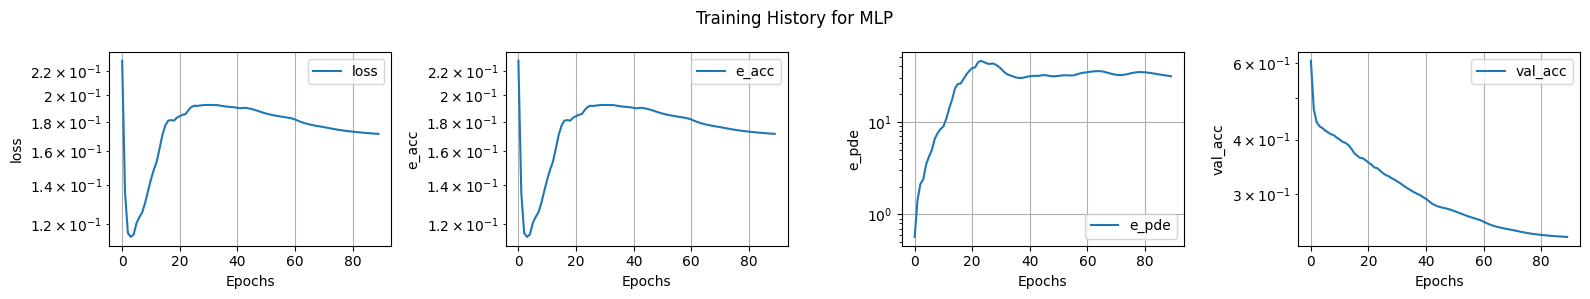

In [ ]:
plot_training_history(metrics_mlp, config_mlp)



TESTING

TEST MLP WITH 10 SAMPLES 

In [ ]:
# Set starting time
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_MLP_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_mlp)

# Initialize a list to store MSE and KD values
mse_scores_mlp_10 = []
k1_score_mlp_10 = []

# Loop over the 10 parameter combinations
for key, param_set in params_dict.items():  # Assuming params_dict_10 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_scores_mlp_10.append(mse)
    
    # Evaluate the Kullback-Leibler divergence
    kl_div = kl_divergence(targets, predictions)
    k1_score_mlp_10.append(kl_div)
    
    print(f"{key}: KL Divergence = {kl_div}")
    print(f"{key}: MSE = {mse}")

# Store the MSE scores for all combinations
mse_results_10 = {key: mse for key, mse in zip(params_dict.keys(), mse_scores_mlp_10)}

# Store KL divergence scores for all combinations
kl_results_10 = {key: kl_div for key, kl_div in zip(params_dict.keys(), k1_score_mlp_10)}

# Save or print the results
# print(mse_results_10)

# Measure the mean and standard deviation of the MSE scores
mse_scores_mlp_10 = np.array(mse_scores_mlp_10)
mean_mse_mlp_10 = np.mean(mse_scores_mlp_10)
std_mse_mlp_10 = np.std(mse_scores_mlp_10)

# Measure the mean and standard deviation of the KL scores
k1_score_mlp_10 = np.array(k1_score_mlp_10)
mean_k1_mlp_10 = np.mean(k1_score_mlp_10)
std_k1_mlp_10 = np.std(k1_score_mlp_10)

# Print the scores
print(f"Mean MSE MLP 10: {mean_mse_mlp_10}, Std. Dev. MSE MLP 10: {std_mse_mlp_10}")

# Print the KL divergence scores
print(f"Mean KL Divergence MLP 10: {mean_k1_mlp_10}, Std. Dev. KL Divergence MLP 10: {std_k1_mlp_10}")

# Print execution time
print(f"Execution time MLP 10: {time.time() - start_time:.2f} seconds")


combination_1: MSE = 3.5404445401204194
combination_2: MSE = 0.12198771613037591
combination_3: MSE = 0.03976273362800173
combination_4: MSE = 0.08446818200720478
combination_5: MSE = 0.053407245547834235
combination_6: MSE = 0.16107674030991354
combination_7: MSE = 0.06018099770779948
combination_8: MSE = 0.34650895367426143
combination_9: MSE = 0.040379582063903435
combination_10: MSE = 0.9107321202288581
Mean MSE MLP: 0.5358948811418572, Std. Dev. MSE MLP: 1.0329599711529742
Execution time MLP: 0.49 seconds


In [ ]:
print(f"Mean MSE MLP: {mean_mse_mlp_10}, Std. Dev. MSE MLP: {std_mse_mlp_10}")
# Print the KL divergence scores
print(f"Mean KL Divergence MLP 10: {mean_k1_mlp_10}, Std. Dev. KL Divergence MLP 10: {std_k1_mlp_10}")

# Print execution time
print(f"Execution time MLP 10: {time.time() - start_time:.2f} seconds")


Mean MSE MLP: 0.25800906763372805, Std. Dev. MSE MLP: 0.3104290373414271


TEST 20 SAMPLES 

In [ ]:
# Set starting time
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_MLP_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_mlp)

# Initialize a list to store MSE and KD values
mse_scores_mlp_20 = []
k1_score_mlp_20 = []

# Loop over the 10 parameter combinations
for key, param_set in params_dict_20.items():  # Assuming params_dict_20 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_scores_mlp_20.append(mse)
    
    # Evaluate the Kullback-Leibler divergence
    kl_div = kl_divergence(targets, predictions)
    k1_score_mlp_20.append(kl_div)
    
    print(f"{key}: KL Divergence = {kl_div}")
    print(f"{key}: MSE = {mse}")

# Store the MSE scores for all combinations
mse_results_20 = {key: mse for key, mse in zip(params_dict_20.keys(), mse_scores_mlp_20)}

# Store KL divergence scores for all combinations
kl_results_20 = {key: kl_div for key, kl_div in zip(params_dict_20.keys(), k1_score_mlp_20)}

# Save or print the results
# print(mse_results_20)

# Measure the mean and standard deviation of the MSE scores
mse_scores_mlp_20 = np.array(mse_scores_mlp_20)
mean_mse_mlp_20 = np.mean(mse_scores_mlp_20)
std_mse_mlp_20 = np.std(mse_scores_mlp_20)

# Measure the mean and standard deviation of the KL scores
k1_score_mlp_20 = np.array(k1_score_mlp_20)
mean_k1_mlp_20 = np.mean(k1_score_mlp_20)
std_k1_mlp_20 = np.std(k1_score_mlp_20)

# Print the scores
print(f"Mean MSE MLP 20: {mean_mse_mlp_20}, Std. Dev. MSE MLP 20: {std_mse_mlp_20}")

# Print the KL divergence scores
print(f"Mean KL Divergence MLP 20: {mean_k1_mlp_20}, Std. Dev. KL Divergence MLP 20: {std_k1_mlp_20}")

# Print execution time
print(f"Execution time MLP 20: {time.time() - start_time:.2f} seconds")



combination_1: MSE = 0.4938088731496869
combination_2: MSE = 0.281594372499141
combination_3: MSE = 0.04795925177849767
combination_4: MSE = 1.6132779404238031
combination_5: MSE = 0.13290870035200056
combination_6: MSE = 0.04497151461180206
combination_7: MSE = 0.06826973183021338
combination_8: MSE = 0.030170481288273966
combination_9: MSE = 0.06936282226963879
combination_10: MSE = 1.301030202265244
combination_11: MSE = 0.03971171454561233
combination_12: MSE = 0.1040802723477018
combination_13: MSE = 2.6809295463040184
combination_14: MSE = 0.10291411653438237
combination_15: MSE = 0.023810722731259427
combination_16: MSE = 0.024018098206906764
combination_17: MSE = 0.4297428659422271
combination_18: MSE = 0.1500241936614384
combination_19: MSE = 0.2961320104997377
combination_20: MSE = 0.07562474489217078
Mean MSE MLP 20: 0.4005171088066879, Std. Dev. MSE MLP 20: 0.669130249645843
Execution time MLP 20: 2.20 seconds


In [ ]:
print(f"Mean MSE MLP 20: {mean_mse_mlp_20}, Std. Dev. MSE MLP 20: {std_mse_mlp_20}")
print(f"Mean KL Divergence MLP 20: {mean_k1_mlp_20}, Std. Dev. KL Divergence MLP 20: {std_k1_mlp_20}")
print(f"Execution time MLP 20: {time.time() - start_time:.2f} seconds")



Mean MSE MLP 20: 0.7364857190377789, Std. Dev. MSE MLP 20: 0.9982881589865975


TEST MLP WITH 30 SAMPLES 

In [ ]:
# Set starting time
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_MLP_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_mlp)

# Initialize a list to store MSE and KD values
mse_scores_mlp_30 = []
k1_score_mlp_30 = []

# Loop over the 10 parameter combinations
for key, param_set in params_dict_30.items():  # Assuming params_dict_30 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_scores_mlp_30.append(mse)
    
    # Evaluate the Kullback-Leibler divergence
    kl_div = kl_divergence(targets, predictions)
    k1_score_mlp_30.append(kl_div)
    
    print(f"{key}: KL Divergence = {kl_div}")
    print(f"{key}: MSE = {mse}")

# Store the MSE scores for all combinations
mse_results_30 = {key: mse for key, mse in zip(params_dict_30.keys(), mse_scores_mlp_30)}

# Store KL divergence scores for all combinations
kl_results_30 = {key: kl_div for key, kl_div in zip(params_dict_30.keys(), k1_score_mlp_30)}

# Save or print the results
# print(mse_results_30)

# Measure the mean and standard deviation of the MSE scores
mse_scores_mlp_30 = np.array(mse_scores_mlp_30)
mean_mse_mlp_30 = np.mean(mse_scores_mlp_30)
std_mse_mlp_30 = np.std(mse_scores_mlp_30)

# Measure the mean and standard deviation of the KL scores
k1_score_mlp_30 = np.array(k1_score_mlp_30)
mean_k1_mlp_30 = np.mean(k1_score_mlp_30)
std_k1_mlp_30 = np.std(k1_score_mlp_30)

# Print the scores
print(f"Mean MSE MLP 30: {mean_mse_mlp_30}, Std. Dev. MSE MLP 30: {std_mse_mlp_30}")

# Print the KL divergence scores
print(f"Mean KL Divergence MLP 30: {mean_k1_mlp_30}, Std. Dev. KL Divergence MLP 30: {std_k1_mlp_30}")

# Print execution time
print(f"Execution time MLP 30: {time.time() - start_time:.2f} seconds")



combination_1: MSE = 0.09175919393347538
combination_2: MSE = 0.05123955323785507
combination_3: MSE = 0.8581184233985073
combination_4: MSE = 0.054513859442127464
combination_5: MSE = 0.2139066311197088
combination_6: MSE = 2.9818753064312733
combination_7: MSE = 0.029893574472894136
combination_8: MSE = 0.035797057201390266
combination_9: MSE = 0.044511086042668284
combination_10: MSE = 1.3707839008233904
combination_11: MSE = 0.0952750401410388
combination_12: MSE = 0.0815256073538519
combination_13: MSE = 0.0677760691747557
combination_14: MSE = 3.1864931721864576
combination_15: MSE = 0.0395286461295172
combination_16: MSE = 0.13478162297485732
combination_17: MSE = 0.516736393388365
combination_18: MSE = 0.05521470144141192
combination_19: MSE = 0.15291834508758662
combination_20: MSE = 0.07201375190189235
combination_21: MSE = 0.8141912528679406
combination_22: MSE = 0.19676296478315433
combination_23: MSE = 0.34646447434982713
combination_24: MSE = 0.07196533131390842
combinati

In [ ]:
# Print the scores
print(f"Mean MSE MLP 30: {mean_mse_mlp_30}, Std. Dev. MSE MLP 30: {std_mse_mlp_30}")

# Print the KL divergence scores
print(f"Mean KL Divergence MLP 30: {mean_k1_mlp_30}, Std. Dev. KL Divergence MLP 30: {std_k1_mlp_30}")

# Print execution time
print(f"Execution time MLP 30: {time.time() - start_time:.2f} seconds")


Mean MSE MLP 30: 0.5710687053433191, Std. Dev. MSE MLP 30: 1.0213956770173511


TEST MLP WITH 150 SAMPLES 

In [ ]:
# Set starting time
start_time = time.time()

# Load the best model configuration
weights_file = "model_params_MLP_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_mlp)

# Initialize a list to store MSE and KD values
mse_scores_mlp_150 = []
k1_score_mlp_150 = []

# Loop over the 10 parameter combinations
for key, param_set in params_dict_150.items():  # Assuming params_dict_150 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
    inputs = jnp.asarray(inputs)
    
    # Use the model to predict the targets, passing in both the parameters and inputs
    predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

    # Evaluate MSE comparing predictions to targets
    mse = mean_squared_error(targets, predictions)
    mse_scores_mlp_150.append(mse)
    
    # evaluate the kulback leibler divergence
    kl_div = kl_divergence(targets, predictions)
    k1_score_mlp_150.append(kl_div)
    
    print(f"{key}: KL Divergence = {kl_div}")
    

    print(f"{key}: MSE = {mse}")

# Store the MSE scores for all combinations
mse_results_150 = {key: mse for key, mse in zip(params_dict_150.keys(), mse_scores_mlp_150)}

# store kl divergence scores for all combinations
kl_results_150 = {key: kl_div for key, kl_div in zip(params_dict_150.keys(), k1_score_mlp_150)}

# Save or print the results
# print(mse_results_150)

# Measure the mean and standard deviation of the MSE scores
mse_scores_mlp_150 = np.array(mse_scores_mlp_150)
mean_mse_mlp_150 = np.mean(mse_scores_mlp_150)
std_mse_mlp_150 = np.std(mse_scores_mlp_150)

# measure the mean and standard deviation of the KL scores
k1_score_mlp_150 = np.array(k1_score_mlp_150)
mean_k1_mlp_150 = np.mean(k1_score_mlp_150)
std_k1_mlp_150 = np.std(k1_score_mlp_150)


# Print the scores
print(f"Mean MSE MLP 150: {mean_mse_mlp_150}, Std. Dev. MSE MLP 150: {std_mse_mlp_150}")

# print the kl divergence scores
print(f"Mean KL Divergence MLP 150: {mean_k1_mlp_150}, Std. Dev. KL Divergence MLP 150: {std_k1_mlp_150}")

# Print execution time
print(f"Execution time MLP 150: {time.time() - start_time:.2f} seconds")


combination_1: MSE = 0.026293254783613513
combination_2: MSE = 0.39792688863389636
combination_3: MSE = 0.06468537437362237
combination_4: MSE = 0.054169710086094225
combination_5: MSE = 0.0686396408268025
combination_6: MSE = 0.43255045363877037
combination_7: MSE = 0.06654805385706625
combination_8: MSE = 2.1073484247062986
combination_9: MSE = 0.4736977995276474
combination_10: MSE = 0.09760875206326697
combination_11: MSE = 0.8234991992295224
combination_12: MSE = 0.4063284262708316
combination_13: MSE = 0.06502604304833182
combination_14: MSE = 4.993485871537239
combination_15: MSE = 4.426083494886185
combination_16: MSE = 0.5264982996742378
combination_17: MSE = 0.04570974418331107
combination_18: MSE = 0.22764285742001647
combination_19: MSE = 0.062208777187313484
combination_20: MSE = 0.023155922790460897
combination_21: MSE = 0.1696365429327013
combination_22: MSE = 0.08962665962446242
combination_23: MSE = 0.054206498999433854
combination_24: MSE = 0.03568417426887459
combina

In [ ]:
# Print the scores
print(f"Mean MSE MLP 150: {mean_mse_mlp_150}, Std. Dev. MSE MLP 150: {std_mse_mlp_150}")

# print the kl divergence scores
print(f"Mean KL Divergence MLP 150: {mean_k1_mlp_150}, Std. Dev. KL Divergence MLP 150: {std_k1_mlp_150}")

# Print execution time
print(f"Execution time MLP 150: {time.time() - start_time:.2f} seconds")



Mean MSE MLP 150: 0.4542938842923572, Std. Dev. MSE MLP 150: 1.044634316347507


/Users/francescostocchi/anaconda3/envs/thesis/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/francescostocchi/anaconda3/envs/thesis/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


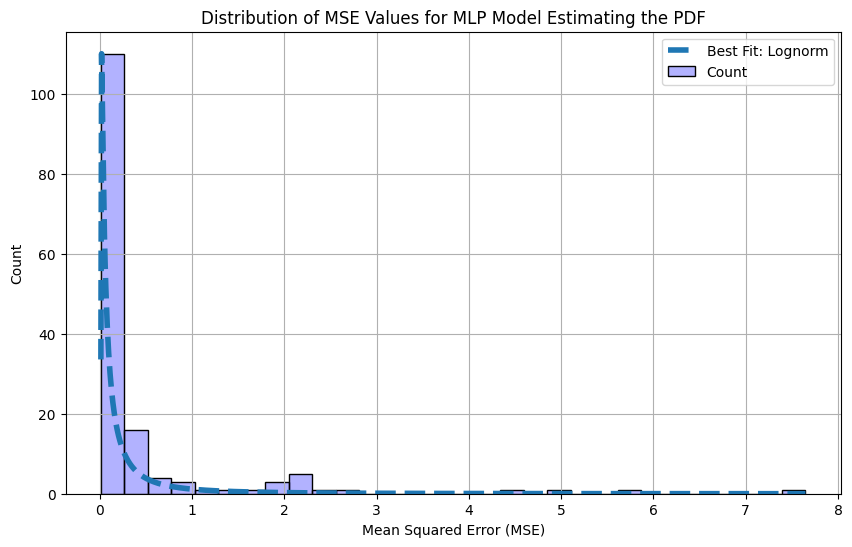

Kolmogorov-Smirnov Test for Lognorm:
KS Statistic: 0.1381
P-Value: 0.0059
Reject the null hypothesis: The data does not follow the fitted distribution.


In [229]:


# Example MSE values (replace with your data)
mse_values_mlp = list(mse_results_150.values())

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram to get the bin heights
hist = sns.histplot(mse_values_mlp, kde=False, stat="count", bins=30, color='blue', alpha=0.3, label='Count')

# Extract bin heights to find the maximum count for scaling
bin_heights = [h.get_height() for h in hist.patches]
max_hist = max(bin_heights)

# Define possible distributions to fit
distributions = [lognorm, gamma, beta, weibull_min]

# Fit each distribution and calculate the AIC
best_fit = None
best_aic = np.inf
best_distribution = None
best_params = None
x = np.linspace(min(mse_values_mlp), max(mse_values_mlp), 1000)

for distribution in distributions:
    # Fit the distribution using MLE
    params = distribution.fit(mse_values_mlp)
    
    # Calculate the fitted PDF values
    pdf_values = distribution.pdf(x, *params)
    
    # Scale the PDF to match the histogram
    scaling_factor = max_hist / max(pdf_values)
    scaled_pdf_values = pdf_values * scaling_factor
    
    # Calculate the AIC
    log_likelihood = np.sum(np.log(distribution.pdf(mse_values_mlp, *params)))
    aic = 2 * len(params) - 2 * log_likelihood
    
    # Keep track of the best fit distribution
    if aic < best_aic:
        best_aic = aic
        best_distribution = distribution
        best_fit = scaled_pdf_values
        best_params = params

# Plot the best fitting distribution
plt.plot(x, best_fit, label=f'Best Fit: {best_distribution.name.capitalize()}', linestyle='--', linewidth=4)

# Add labels and title
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Count')
plt.title('Distribution of MSE Values for MLP Model Estimating the PDF')

# Add legend
plt.legend()
plt.grid(True)
plt.show()

# Goodness-of-Fit Test
# Perform the KS test
ks_stat, p_value = kstest(mse_values_mlp, best_distribution.name, args=best_params)

# Display the test results
print(f"Kolmogorov-Smirnov Test for {best_distribution.name.capitalize()}:")
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation of the p-value
alpha = 0.05  # significance level
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data follows the fitted distribution.")
else:
    print("Reject the null hypothesis: The data does not follow the fitted distribution.")


KDE TEST

In [ ]:
# set start time 
start_time = time.time()

# Initialize a list to store MSE values for KDE
mse_scores_kde = []
k1_scores_kde_10 = []

# Loop over the 10 parameter combinations
for key, param_set in params_dict.items():
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Fit the Kernel Density Estimation model on the inputs (reshaped for KDE)
    inputs = jnp.asarray(inputs)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)  # You can adjust the bandwidth parameter
    kde.fit(inputs)
    
    # Predict log densities for the input data
    log_density_pred = kde.score_samples(inputs)
    
    # Convert log densities to actual densities
    density_pred = np.exp(log_density_pred)
    
    # Compare the KDE output (predicted density) to the actual target density using MSE
    mse = mean_squared_error(targets, density_pred)
    mse_scores_kde.append(mse)

    kl_value = kl_divergence(targets, density_pred)
    k1_scores_kde_10.append(kl_value)
    print(f"{key}: Kullback Divergence (KDE) = {kl_value}")

    print(f"{key}: MSE (KDE) = {mse}")

# Store the MSE scores for all combinations
mse_results_kde_10 = {key: mse for key, mse in zip(params_dict.keys(), mse_scores_kde)}

# Store the Kullback divergence scores for all combinations
kl_results_kde_10 = {key: kl for key, kl in zip(params_dict.keys(), k1_scores_kde_10)}

# Save or print the results
# print(mse_results_kde_10)

# Measure the mean and standard deviation of the MSE scores for KDE
mse_scores_kde_10 = np.array(mse_scores_kde)
mean_mse_kde_10 = np.mean(mse_scores_kde_10)
std_mse_kde_10 = np.std(mse_scores_kde_10)

# Measure the mean and standard deviation of the KL scores for KDE
k1_scores_kde_10 = np.array(k1_scores_kde_10)
mean_k1_kde_10 = np.mean(k1_scores_kde_10)
std_k1_kde_10 = np.std(k1_scores_kde_10)

# Print the KDE MSE scores
print(f"Mean MSE (KDE) 10: {mean_mse_kde_10}, Std. Dev. MSE (KDE) 10: {std_mse_kde_10}")

# Print the KL scores for KDE
print(f"Mean Kullback Divergence (KDE) 10: {mean_k1_kde_10}, Std. Dev. Kullback Divergence (KDE) 10: {std_k1_kde_10}")

# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")



combination_1: MSE (KDE) = 4.79581229735041
combination_2: MSE (KDE) = 0.10658603204866586
combination_3: MSE (KDE) = 0.12698768733773558
combination_4: MSE (KDE) = 0.224969007201604
combination_5: MSE (KDE) = 0.0683715761926573
combination_6: MSE (KDE) = 0.11934487732498422
combination_7: MSE (KDE) = 0.06379764828205484
combination_8: MSE (KDE) = 0.5422951358279483
combination_9: MSE (KDE) = 0.4010362861657897
combination_10: MSE (KDE) = 1.0335170502622355
Mean MSE (KDE): 0.7482717597994084, Std. Dev. MSE (KDE): 1.3793065815074284
Execution time: 442.70 seconds


In [ ]:
# Print the KDE MSE scores
print(f"Mean MSE (KDE) 10: {mean_mse_kde_10}, Std. Dev. MSE (KDE) 10: {std_mse_kde_10}")

# Print the KL scores for KDE
print(f"Mean Kullback Divergence (KDE) 10: {mean_k1_kde_10}, Std. Dev. Kullback Divergence (KDE) 10: {std_k1_kde_10}")

# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")

Mean MSE (KDE): 0.7482717597994084, Std. Dev. MSE (KDE): 1.3793065815074284


In [ ]:
# Set start time 
start_time = time.time()

# Initialize a list to store MSE values for KDE
mse_scores_kde_20 = []
k1_scores_kde_20 = []
 
# Loop over the 10 parameter combinations
for key, param_set in params_dict_20.items():  # Assuming params_dict_20 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Fit the Kernel Density Estimation model on the inputs (reshaped for KDE)
    inputs = jnp.asarray(inputs)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)  # You can adjust the bandwidth parameter
    kde.fit(inputs)
    
    # Predict log densities for the input data
    log_density_pred = kde.score_samples(inputs)
    
    # Convert log densities to actual densities
    density_pred = np.exp(log_density_pred)
    
    # Compare the KDE output (predicted density) to the actual target density using MSE
    mse = mean_squared_error(targets, density_pred)
    mse_scores_kde_20.append(mse)

    kl_value = kl_divergence(targets, density_pred)
    k1_scores_kde_20.append(kl_value)
    print(f"{key}: Kullbeck Divergence (KDE) = {kl_value}")

    print(f"{key}: MSE (KDE) = {mse}")

    # Store the MSE scores for all combinations
    mse_results_kde_20 = {key: mse for key, mse in zip(params_dict_20.keys(), mse_scores_kde_20)}

    # Store the Kullback divergence scores for all combinations
    kl_results_kde_20 = {key: kl for key, kl in zip(params_dict_20.keys(), k1_scores_kde_20)}


# Measure the mean and standard deviation of the MSE scores for KDE
mse_scores_kde_20 = np.array(mse_scores_kde_20)
mean_mse_kde_20 = np.mean(mse_scores_kde_20)
std_mse_kde_20 = np.std(mse_scores_kde_20)

# Measure the mean and standard deviation of the KL scores for KDE
k1_scores_kde_20 = np.array(k1_scores_kde_20)
mean_k1_kde_20 = np.mean(k1_scores_kde_20)
std_k1_kde_20 = np.std(k1_scores_kde_20)

# Print the KDE MSE scores
print(f"Mean MSE (KDE) 20: {mean_mse_kde_20}, Std. Dev. MSE (KDE) 20: {std_mse_kde_20}")

# Print the KL scores for KDE
print(f"Mean Kullback Divergence (KDE) 20: {mean_k1_kde_20}, Std. Dev. Kullback Divergence (KDE) 20: {std_k1_kde_20}")

# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")


combination_1: MSE (KDE) = 1.225475059341249
combination_2: MSE (KDE) = 0.31429663610648934
combination_3: MSE (KDE) = 0.11763132258008843
combination_4: MSE (KDE) = 2.6428141402384644
combination_5: MSE (KDE) = 0.4903483786966015
combination_6: MSE (KDE) = 0.09905950237840264
combination_7: MSE (KDE) = 0.043493542369775484
combination_8: MSE (KDE) = 0.41415573603819206
combination_9: MSE (KDE) = 0.031070866248374625
combination_10: MSE (KDE) = 1.7902932431127405
combination_11: MSE (KDE) = 0.12970039452795967
combination_12: MSE (KDE) = 0.3596372313855801
combination_13: MSE (KDE) = 3.0394280762937838
combination_14: MSE (KDE) = 0.03818818230542499
combination_15: MSE (KDE) = 0.2116786593749411
combination_16: MSE (KDE) = 0.17996521604455248
combination_17: MSE (KDE) = 1.2234311725169815
combination_18: MSE (KDE) = 0.11395154210203479
combination_19: MSE (KDE) = 0.9406071512633587
combination_20: MSE (KDE) = 0.06863725811869688
Mean MSE (KDE) 20: 0.6736931655521846, Std. Dev. MSE (KDE

In [ ]:
# Print the KDE MSE scores
print(f"Mean MSE (KDE) 20: {mean_mse_kde_20}, Std. Dev. MSE (KDE) 20: {std_mse_kde_20}")

# Print the KL scores for KDE
print(f"Mean Kullback Divergence (KDE) 20: {mean_k1_kde_20}, Std. Dev. Kullback Divergence (KDE) 20: {std_k1_kde_20}")

# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")

Mean MSE (KDE) 20: 0.9400189557803944, Std. Dev. MSE (KDE) 20: 1.0573724167926335


In [282]:
# Set start time 
start_time = time.time()

# Initialize a list to store MSE values for KDE
mse_scores_kde_30 = []
k1_scores_kde_30 = []   

# Loop over the 10 parameter combinations
for key, param_set in params_dict_30.items():  # Assuming params_dict_30 is defined
    mu = param_set['mu']
    theta = param_set['theta']
    sigma = param_set['sigma']
    
    # Generate the data using the bivariate OU process function
    X0 = 0.5  # Example initial values
    T = 3.5   # Total time
    dt = 0.01  # Time step
    num_paths = 1000  # Number of paths to simulate
    inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)
    
    # Fit the Kernel Density Estimation model on the inputs (reshaped for KDE)
    inputs = jnp.asarray(inputs)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)  # You can adjust the bandwidth parameter
    kde.fit(inputs)
    
    # Predict log densities for the input data
    log_density_pred = kde.score_samples(inputs)
    
    # Convert log densities to actual densities
    density_pred = np.exp(log_density_pred)
    
    # Compare the KDE output (predicted density) to the actual target density using MSE
    mse = mean_squared_error(targets, density_pred)
    mse_scores_kde_30.append(mse)
    
    kl_value = kl_divergence(targets, density_pred)
    k1_scores_kde_30.append(kl_value)
    print(f"{key}: Kullbeck Divergence (KDE) = {kl_value}")

    print(f"{key}: MSE (KDE) = {mse}")

# Store the MSE scores for all combinations
mse_results_kde_30 = {key: mse for key, mse in zip(params_dict_30.keys(), mse_scores_kde_30)}

# store the kulbeck divergence scores for all combinations
kl_results_kde_30 = {key: kl for key, kl in zip(params_dict_30.keys(), k1_scores_kde_30)}


# Save or print the results
# print(mse_results_kde_30)

# Measure the mean and standard deviation of the MSE scores for KDE
mse_scores_kde_30 = np.array(mse_scores_kde_30)
mean_mse_kde_30 = np.mean(mse_scores_kde_30)
std_mse_kde_30 = np.std(mse_scores_kde_30)

# measure the mean and standard deviation of the kl scores for KDE
k1_scores_kde_30 = np.array(k1_scores_kde_30)
mean_k1_kde_30 = np.mean(k1_scores_kde_30)
std_k1_kde_30 = np.std(k1_scores_kde_30)


# Print the KDE MSE scores
print(f"Mean MSE (KDE) 30: {mean_mse_kde_30}, Std. Dev. MSE (KDE) 30: {std_mse_kde_30}")

# print the kl scores for KDE
print(f"Mean Kullbeck Divergence (KDE) 30: {mean_k1_kde_30}, Std. Dev. Kullbeck Divergence (KDE) 30: {std_k1_kde_30}")

# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")

combination_1: Kullbeck Divergence (KDE) = 22807.055641560357
combination_1: MSE (KDE) = 0.2508079695644216
combination_2: Kullbeck Divergence (KDE) = 19687.879622252774
combination_2: MSE (KDE) = 0.16927967421654197
combination_3: Kullbeck Divergence (KDE) = 46416.59099299701
combination_3: MSE (KDE) = 0.9349367969506225
combination_4: Kullbeck Divergence (KDE) = 14392.70907912729
combination_4: MSE (KDE) = 0.09148223582691556
combination_5: Kullbeck Divergence (KDE) = 29097.065592693376
combination_5: MSE (KDE) = 0.35235224318239206
combination_6: Kullbeck Divergence (KDE) = 87826.53899178849
combination_6: MSE (KDE) = 3.222925082073869
combination_7: Kullbeck Divergence (KDE) = 19687.428524708626
combination_7: MSE (KDE) = 0.16180737664098255
combination_8: Kullbeck Divergence (KDE) = 28689.912688777742
combination_8: MSE (KDE) = 0.3391718824386592
combination_9: Kullbeck Divergence (KDE) = 14711.378236140337
combination_9: MSE (KDE) = 0.09217007335754424
combination_10: Kullbeck Di

In [283]:
# Print the KDE MSE scores
print(f"Mean MSE (KDE) 30: {mean_mse_kde_30}, Std. Dev. MSE (KDE) 30: {std_mse_kde_30}")

# print the kl scores for KDE
print(f"Mean Kullbeck Divergence (KDE) 30: {mean_k1_kde_30}, Std. Dev. Kullbeck Divergence (KDE) 30: {std_k1_kde_30}")

# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")

Mean MSE (KDE) 30: 0.7322166905211157, Std. Dev. MSE (KDE) 30: 1.1647414457193253
Mean Kullbeck Divergence (KDE) 30: 32919.06693241212, Std. Dev. Kullbeck Divergence (KDE) 30: 24882.12232739888
Execution time: 1313.45 seconds


## COMPARISON

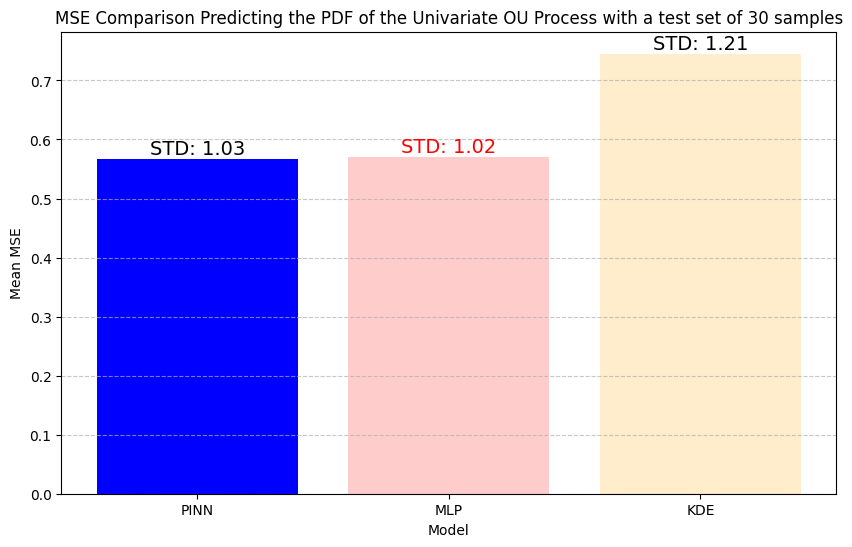

In [230]:
#Mean MSE PINN 30 samples: 0.5675279793461857, Std. Dev. MSE PINN 30 samples: 1.0295039258017582

#Mean MSE MLP 30: 0.5710687053433191, Std. Dev. MSE MLP 30: 1.0213956770173511


# Mean values and standard deviations for each model
models = ['PINN', 'MLP', 'KDE']
means = [mean_mse_30, mean_mse_mlp_30, mean_mse_kde_30]
std_devs = [std_mse_30, std_mse_mlp_30, std_mse_kde_30]

# Find the index of the model with the lowest mean MSE
min_mse_index = means.index(min(means))

# Set colors and transparency levels
colors = ['blue', 'red', 'orange']
alphas = [0.2, 0.2, 0.2]  # Default transparency
highlight_color = colors[min_mse_index]
highlight_alpha = 1.0    # More opaque for the lowest MSE bar

# Update the alpha for the highlighted bar
alphas[min_mse_index] = highlight_alpha

# Creating the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, means, color=colors, alpha=1)

# Setting individual alpha values
for i, bar in enumerate(bars):
    bar.set_alpha(alphas[i])

# Adding the standard deviation value on top of each bar
for i, (bar, std) in enumerate(zip(bars, std_devs)):
    # Set color to red for the lowest standard deviation
    text_color = 'red' if i == std_devs.index(min(std_devs)) else 'black'
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'STD: {std:.2f}',
        ha='center',
        va='bottom',
        color=text_color,
        fontsize=14
    )

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Mean MSE')
plt.title('MSE Comparison Predicting the PDF of the Univariate OU Process with a test set of 30 samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## FINAL TEST


## MLP

 ESTIMATING PDF

In [68]:
mu, theta, sigma = generate_random_parameters_univariate()  # Reproducibility with seed
print('mu =', mu)   
print('theta =', theta)
print('sigma =', sigma)


mu = 0.3507126525121791
theta = 1.70387514634538
sigma = 0.5799097255814691


In [74]:
mu = 0.5515111644977461
theta = 0.24309613392043106
sigma = 0.3100268842845988

In [75]:
# Load the best model configuration
weights_file = "model_params_MLP_p_estimation.pkl"

# Load the trained model and parameters
model, params_trained = load_trained_model(weights_file, config_mlp)


# Generate the data using the bivariate OU process function
X0 = 0.5  # Example initial values
T = 10   # Total time
dt = 0.01  # Time step
num_paths = 1000  # Number of paths to simulate
inputs, targets, t, X, P_xt, x_grid = generate_ou_process_data(theta, mu, sigma, T, dt, num_paths)

# Ensure inputs are in the right shape, e.g., [batch_size, feature_dim]
inputs = jnp.asarray(inputs)

# Use the model to predict the targets, passing in both the parameters and inputs
pxt_predictions = model.apply({'params': params_trained}, inputs)  # Pass params correctly

print("Predictions shape:", pxt_predictions.shape)
print("Targets shape:", targets.shape)
print("Inputs shape:", inputs.shape)
print('Pxt shape:', P_xt.shape) 


Predictions shape: (100000, 1)
Targets shape: (100000,)
Inputs shape: (100000, 2)
Pxt shape: (100, 1000)


In [76]:
# measure the mean squared error
mse = mean_squared_error(targets, pxt_predictions)
print(mse)

0.10277511859104241


In [77]:
# Ensure that targets have the correct size to reshape back to P_xt
if targets.size == P_xt.size:
    # Reshape using the correct order to match the original P_xt
    targets_reshaped = targets.reshape(P_xt.T.shape)

# Step 2: Transpose back to get the original P_xt
    targets_reshaped = targets_reshaped.T

# Check if P_xt_reconstructed matches P_xt
if np.allclose(targets_reshaped, P_xt):
    print("Successfully reverted targets back to P_xt.")
else:
    print("Mismatch between reconstructed P_xt and original P_xt.")






Successfully reverted targets back to P_xt.


In [78]:
predictions_flat = pxt_predictions.ravel()  # or predictions.ravel()

# Ensure that targets have the correct size to reshape back to P_xt
if predictions_flat.size == P_xt.size:
    # Reshape using the correct order to match the original P_xt
    predictions_flat = predictions_flat.reshape(P_xt.T.shape)

# Step 2: Transpose back to get the original P_xt
    predictions_flat = predictions_flat.T

# Check if P_xt_reconstructed matches P_xt
if np.allclose(predictions_flat, P_xt):
    print("Successfully reverted targets back to P_xt.")
else:
    print("Mismatch between reconstructed P_xt and original P_xt.")

Mismatch between reconstructed P_xt and original P_xt.


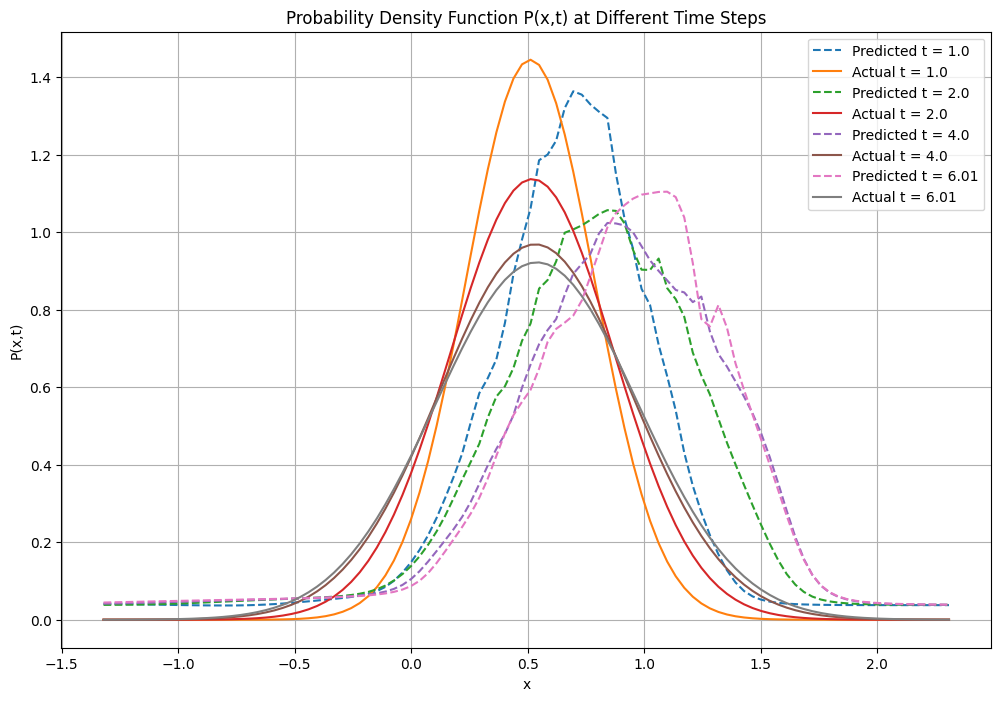

In [81]:
# Define time steps to plot
time_steps = [100, 200, 400, 600]  # Example: plot at selected time steps
time_labels = [f't = {round(t[i], 2)}' for i in time_steps]

plt.figure(figsize=(12, 8))

# Plot P(x,t) for selected time steps
for i, step in enumerate(time_steps):
    plt.plot(x_grid, predictions_flat[:, step], label=f'Predicted {time_labels[i]}', linestyle='--')
    plt.plot(x_grid, targets_reshaped[:, step], label=f'Actual {time_labels[i]}', linestyle='-')

plt.xlabel('x')
plt.ylabel('P(x,t)')
plt.title('Probability Density Function P(x,t) at Different Time Steps')
plt.legend()
plt.grid(True)
plt.show()

# 

ESTIMATING MU THETA AND SIGMA

In [ ]:
# stack to inputs the predicted values of p(x,t)
inputs_with_pxt = np.hstack((inputs, pxt_predictions))

# print shape of inputs_with_pxt (should be (x,3))
print(inputs_with_pxt.shape)


In [ ]:
def generate_ou_process_data_v2(theta, mu, sigma, X0, T, dt, num_paths):
    num_steps = int(T / dt)
    t = np.linspace(0, T, num_steps)
    X = np.zeros((num_paths, num_steps))
    X[:, 0] = X0

    for i in range(1, num_steps):
        dW = np.sqrt(dt) * np.random.randn(num_paths)
        X[:, i] = X[:, i-1] + theta * (mu - X[:, i-1]) * dt + sigma * dW
    
    # Generate x_grid based on a wide enough range of X values to reflect variability
    x_min, x_max = np.min(X), np.max(X)
    x_grid = np.linspace(x_min, x_max, 100)
    
    # Calculate P(x,t) over the x_grid
    P_xt = np.zeros((len(x_grid), num_steps))
    for i in range(num_steps):
        mean = mu * (1 - np.exp(-theta * t[i])) + X0 * np.exp(-theta * t[i])
        variance = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t[i]))
        
        if variance > 1e-10:
            P_xt[:, i] = (1.0 / np.sqrt(2 * np.pi * variance)) * \
                         np.exp(-0.5 * ((x_grid - mean)**2) / variance)
        else:
            P_xt[:, i] = np.zeros_like(x_grid)
    
    # Stack x_grid and t for inputs and flatten P_xt for targets
    inputs = np.stack(np.meshgrid(x_grid, t), axis=-1).reshape(-1, 2)
    targets = P_xt.T.flatten()  # Transpose to match the shape of inputs
    
    # Combine the inputs with P(x,t) in the same format as the training data
    inputs_with_pxt = np.hstack((inputs, targets.reshape(-1, 1)))
    
    # Create target outputs with mu, sigma, theta, consistent with training format
    targets_with_params = np.vstack((
        np.full(inputs.shape[0], mu), 
        np.full(inputs.shape[0], sigma), 
        np.full(inputs.shape[0], theta)
    )).T
    
    return inputs_with_pxt, targets_with_params, t, X, P_xt, x_grid  

inputs_with_pxt_10, targets_with_params_10, t_10, X_10, P_xt_10, x_grid_10 = generate_ou_process_data_v2(
    theta, mu, sigma, X0, T, dt, num_paths)

In [ ]:
# stack to inputs the predicted values of p(x,t)
inputs_with_pxt = np.hstack((inputs, pxt_predictions))

# Best parameters for MLP
best_params_mlp_test = {
    'hidden_layers': '256-128-64-32',
    'num_epochs': 46,
    'learning_rate': 0.00020525626048783685,
    'weight_decay': 2.0796422139105e-05,
    'patience': 9,
    'batch_size': 479
}

# Decode the hidden layers
decoded_hidden_layers = decode_hidden_layers(best_params_mlp['hidden_layers'])

# Configuration for the MLP
config_mlp_test = Config(
    seed=42,
    ann_in_dim=3,
    hidden_layers=decoded_hidden_layers,
    loss_str='MLP',
    data_source='FP_OU',
    num_epochs=best_params_mlp['num_epochs'],
    log_interval=100,
    patience=best_params_mlp['patience'],
    min_delta=1e-4,
    learning_rate=best_params_mlp['learning_rate'],
    weight_decay=best_params_mlp['weight_decay'],
    batch_size=best_params_mlp['batch_size']
)

# Load the best model configuration
weights_file_10 = "model_params_MLP_univariate_drift_diffusion.pkl"

# Load the trained model
model_10, params_trained_10 = load_trained_model(weights_file_10, config_mlp)

predictions_10 = model_10.apply({'params': params_trained_10}, inputs_with_pxt)

# Extract the predicted values for mu, sigma, and theta
pred_mu_10 = predictions_10[:, 0]    # First column corresponds to mu
pred_sigma_10 = predictions_10[:, 1]  # Second column corresponds to sigma
pred_theta_10 = predictions_10[:, 2]  # Third column corresponds to theta

# Take the average of the predictions across all paths
avg_pred_mu_10 = np.mean(pred_mu_10)
avg_pred_sigma_10 = np.mean(pred_sigma_10)
avg_pred_theta_10 = np.mean(pred_theta_10)

# Calculate MSE for each parameter
mse_mu_10 = mean_squared_error([mu], [avg_pred_mu_10])  # Compare actual mu to predicted mu
mse_sigma_10 = mean_squared_error([sigma], [avg_pred_sigma_10])  # Compare actual sigma to predicted sigma
mse_theta_10 = mean_squared_error([theta], [avg_pred_theta_10])  # Compare actual theta to predicted theta

# overall MSE
overall_mse = np.mean([mse_mu_10, mse_sigma_10, mse_theta_10])


# print the results 
print(f"Predicted mu: {avg_pred_mu_10}, Actual mu: {mu}, MSE: {mse_mu_10}")
print(f"Predicted sigma: {avg_pred_sigma_10}, Actual sigma: {sigma}, MSE: {mse_sigma_10}")
print('f"Predicted theta: {avg_pred_theta_10}, Actual theta: {theta}, MSE: {mse_theta_10}')
print(f"Overall MSE: {overall_mse}")



